# Introduction
This notebook analyses the relationship of measures against COVID-19 (Coronavirus disease 2019) and the number of infected cases. The goal is to find measures that enable us to settle the situation more quickly.

We will use SIR-F model that is a customized ODE model derived from SIR model. To evaluate the effect of measures, parameter estimation of SIR-F will be applied to subsets of time series data in each country. Parameter change points will be determined by S-R trend analysis. The details will be explained in "Method" part.

** To accerate open data science of COVID-19, I published the code as a package in [GitHub page: COVID-19 data with SIR model](https://github.com/lisphilar/covid19-sir). It may be useful when you apply the models to the data in your country. Quick usage is explained in README.md of this repository. If you find errors and ideas, please kindly tell me by comment on this notebook or pull request in GitHub.**

1. Preparation
   * [Dataset and tools](#1)
   * [Grouping by growth factor](#2)

2. Method
   * [SIR to SIR-F](#4)
   * [SIR-F with exposed/waiting cases](#5)
   * [Factors of model parameters](#6)
   * [S-R trend analysis](#10)

3. Scenario analysis
   * [Scenario in Italy](#7)
   * [Scenario in Japan](#8)

4. Monitoring
   * [Scenario in India](#12)
   * [Scenario in USA](#14)
   * [Scenario in New Zealand](#15)

5. Remarks
   * [Conclusion](#9)
   * [Acknowledgement](#3)
   * [Change log](#11)

Note:  
"Infected" means the currently infected and confirmed cases.  
This can be calculated  as "Confirmed" - "Deaths" - "Recovered" in [COVID-19 Data Repository by CSSE at Johns Hopkins University](https://github.com/CSSEGISandData/COVID-19).

In [1]:
from datetime import datetime
time_format = "%d%b%Y %H:%M"
datetime.now().strftime(time_format)

'17Jun2020 16:04'

## Updates
 * 13Feb2020-06May2020: (Please read [Change log](#11) subsection.)
 
 * 09May2020: Published the functions as a Python package
 * 30May2020: Finished refactoring of codes in the package
 * 17Jun2020: Released version 2.2.0 of CovsirPhy and ODE simulation will be done with tau-free dataset (time step [-] and ODE variables [persons])
 * 17Jun2020: Restricted tau value [min] as to the divisors of 1440 [min]


# Dataset and tools<a id="1"></a>

## Package

### Package for SIR analysis
I published a Python package [Covsirphy](https://github.com/lisphilar/covid19-sir) for this analysis in GitHub.

In [2]:
!pip install git+https://github.com/lisphilar/covid19-sir#egg=covsirphy

  Cloning https://github.com/lisphilar/covid19-sir to /tmp/pip-install-ntd8loj2/covsirphy
  Running command git clone -q https://github.com/lisphilar/covid19-sir /tmp/pip-install-ntd8loj2/covsirphy
     |████████████████████████████████| 174kB 4.0MB/s 
  Created wheel for covsirphy: filename=covsirphy-2.2.1-cp36-none-any.whl size=62220 sha256=cdd91d945ab26d1ef47af51b1575ed7cc2cb6357884b9e995a3cab39ccf7d334
  Stored in directory: /tmp/pip-ephem-wheel-cache-l3x8fwrh/wheels/0d/b1/8c/85cd1eeb2327bc5b2e27129b5dfc7725314c6fb1780ccb55f3
  Created wheel for japanmap: filename=japanmap-0.0.21-cp36-none-any.whl size=166795 sha256=33f27a8e7ccdbbd90c1701c0a38843a3fbd4f138e7ac3f05123b59fa8114024a
  Stored in directory: /root/.cache/pip/wheels/a0/7b/2b/331437760ae95113fa973e5ad7af111588ce9c7e76feb14f56
Successfully built covsirphy japanmap


In [3]:
!pip freeze | grep covsirphy
import covsirphy as cs

covsirphy==2.2.1


### General packages

In [4]:
from collections import defaultdict
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import functools
from IPython.display import display, Markdown
import math
import os
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import ScalarFormatter
%matplotlib inline
import numpy as np
import pandas as pd
import dask.dataframe as dd
pd.plotting.register_matplotlib_converters()
import seaborn as sns
import scipy as sci
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import sympy as sym

In [5]:
# Ramdam
np.random.seed(123)
os.environ["PYTHONHASHSEED"] = "123"
# Matplotlib
plt.style.use("seaborn-ticks")
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["font.size"] = 11.0
plt.rcParams["figure.figsize"] = (9, 6)
# Pandas
pd.set_option("display.max_colwidth", 1000)

## List of dataset

In [6]:
for dirname, _, filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/population-pyramid-2019/Canada-2019.csv
/kaggle/input/population-pyramid-2019/India-2019.csv
/kaggle/input/population-pyramid-2019/United States of America-2019.csv
/kaggle/input/population-pyramid-2019/Italy-2019.csv
/kaggle/input/population-pyramid-2019/France-2019.csv
/kaggle/input/population-pyramid-2019/United Kingdom-2019.csv
/kaggle/input/population-pyramid-2019/Spain-2019.csv
/kaggle/input/population-pyramid-2019/Japan-2019.csv
/kaggle/input/population-pyramid-2019/Germany-2019.csv
/kaggle/input/population-pyramid-2019/China-2019.csv
/kaggle/input/population-pyramid-2019/Iran-2019.csv
/kaggle/input/covid19-global-forecasting-locations-population/locations_population.csv
/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_confirmed.csv
/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_deaths_US.csv
/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_recovered.csv
/kaggle/input/novel-corona-virus-2019-dataset/COVID19_op

## Total population

In [7]:
pop_data = cs.Population(
    "/kaggle/input/covid19-global-forecasting-locations-population/locations_population.csv"
)
pop_data.cleaned().tail()

Country Province  Population
335             Vietnam        -    95540000
336  West Bank and Gaza        -     4776131
337      Western Sahara        -      593611
338              Zambia        -    17090000
339            Zimbabwe        -    16530000

## Population pyramid

In [8]:
pyramid_csv_list = list()
for dirname, _, filenames in os.walk("/kaggle/input/population-pyramid-2019/"):
    for filename in filenames:
        name = os.path.join(dirname, filename)
        df = pd.read_csv(name)
        df["Country"], df["Year"], _ = filename.replace(".", "-").split("-")
        pyramid_csv_list.append(df)
pyramid_raw = pd.concat(pyramid_csv_list, sort=True)
pyramid_raw.head()

Age Country        F        M  Year
0    0-4  Canada   965981  1013876  2019
1    5-9  Canada   967470  1012761  2019
2  10-14  Canada   961187  1006817  2019
3  15-19  Canada   978597  1027473  2019
4  20-24  Canada  1176141  1231211  2019

In [9]:
pyramid_raw["Country"].unique()

array(['Canada', 'India', 'United States of America', 'Italy', 'France',
       'United Kingdom', 'Spain', 'Japan', 'Germany', 'China', 'Iran'],
      dtype=object)

In [10]:
df = pyramid_raw.copy()
df["Country"] = df["Country"].replace(
    {
        "United States of America": "US",
        "United Kingdom": "UK",
    }
)
# Global (WORLD)
_male = [
    349432556, 342927576, 331497486, 316642222, 308286775, 306059387, 309236984,
    276447037, 249389688, 241232876, 222609691, 192215395, 157180267, 128939392,
    87185982, 54754941, 33648953, 15756942, 5327866, 1077791, 124144
]
_female = [
    328509234, 321511867, 309769906, 295553758, 289100903, 288632766, 296293748,
    268371754, 244399176, 238133281, 223162982, 195633743, 164961323, 140704320,
    101491347, 69026831, 48281201, 26429329, 11352182, 3055845, 449279
]
_df = pd.DataFrame(
    {
        "Age": df["Age"].unique(),
        "Country": "Global",
        "F": _female,
        "M": _male,
        "Year": 2019
    }
)
df = pd.concat([df, _df], axis=0, ignore_index=True, sort=True)
# Sweden
_male = [
    307116, 304759, 296771, 270840, 291723, 376952, 343311, 315086,
    312017, 336452, 342117, 306949, 279609, 265511, 273061, 195029,
    113166, 61775, 26170, 6768, 415
]
_female = [
    290553, 288817, 280944, 257677, 274760, 361526, 330153, 300752,
    301288, 327453, 331458, 300084, 280009, 272149, 286879, 212480,
    143654, 97633, 52624, 18130, 1771
]
_df = pd.DataFrame(
    {
        "Age": df["Age"].unique(),
        "Country": "Sweden",
        "F": _female,
        "M": _male,
        "Year": 2019
    }
)
df = pd.concat([df, _df], axis=0, ignore_index=True, sort=True)
# Philippines
_male = [
    5534962, 5820604, 5538414, 5383822, 5149849, 4710777, 4061897, 3581091, 3237426,
    2832825, 2482953, 2015857, 1556935, 1082875, 668107, 364200, 199400, 73508,
    17327, 3035, 208
]
_female = [
    5240508, 5541514, 5273495, 5029137, 4896316, 4589506, 3982681,
    3544279, 3191565, 2825286, 2521463, 2112380, 1714689, 1285782,
    895866, 567282, 360751, 155294, 57969, 13376, 1411
]
_df = pd.DataFrame(
    {
        "Age": df["Age"].unique(),
        "Country": "Philippines",
        "F": _female,
        "M": _male,
        "Year": 2019
    }
)
df = pd.concat([df, _df], axis=0, ignore_index=True, sort=True)
# Arrange
df["Population"] = df["F"] + df["M"]
df = df.pivot_table(
    index="Age", columns=["Country"], values="Population", aggfunc="last"
)
df = df.astype(np.int64).reset_index().rename({"Age": "Age_bin"}, axis=1)
series = df["Age_bin"].str.replace("+", "-122")
df[["Age_first", "Age_last"]] = series.str.split("-", expand=True).astype(np.int64)
df = df.drop("Age_bin", axis=1)
series = df["Age_last"]
df = df.apply(lambda x: x[:-2] / (x[-1] - x[-2] + 1), axis=1)
df["Age"] = series
df = pd.merge(df, pd.DataFrame({"Age": np.arange(0, 123, 1)}), on="Age", how="right", sort=True)
df = df.fillna(method="bfill").astype(np.int64)
df = df.set_index("Age")
pyramid_df = df.copy()
pyramid_df

Canada     China  France  Germany     Global     India     Iran   Italy  \
Age                                                                            
0    395971  17008206  733844   797488  135588358  23356364  1516560  476509   
1    395971  17008206  733844   797488  135588358  23356364  1516560  476509   
2    395971  17008206  733844   797488  135588358  23356364  1516560  476509   
3    395971  17008206  733844   797488  135588358  23356364  1516560  476509   
4    395971  17008206  733844   797488  135588358  23356364  1516560  476509   
..      ...       ...     ...      ...        ...       ...      ...     ...   
118     352      2949     808      769      24931      1947       21     694   
119     352      2949     808      769      24931      1947       21     694   
120     352      2949     808      769      24931      1947       21     694   
121     352      2949     808      769      24931      1947       21     694   
122     352      2949     808      769      24931      1947       21     694   

      Japan  Philippines   Spain  Sweden      UK       US  
Age                                                        
0    981106      2155094  403236  119533  790209  3920819  
1    981106      2155094  403236  119533  790209  3920819  
2    981106      2155094  403236  119533  790209  3920819  
3    981106      2155094  403236  119533  790209  3920819  
4    981106      2155094  403236  119533  790209  3920819  
..      ...          ...     ...     ...     ...      ...  
118    3182           70     535      95     667     3910  
119    3182           70     535      95     667     3910  
120    3182           70     535      95     667     3910  
121    3182           70     535      95     667     3910  
122    3182           70     535      95     667     3910  

[123 rows x 14 columns]

## The number of days go out (template data)
**As a comment of this notebook, @marcoferrante estimated the number of days persons of each age group usually go out. Thank you for your kind cooperation!!**

In [11]:
# @marcoferrante estimation
_period_of_life_list = [
    "nursery", "nursery school", "elementary school", "middle school",
    "high school", "university/work", "work", "work", "work", "work",
    "retired", "retired", "retired"
]
df = pd.DataFrame(
    {
        "Age_first": [0, 3, 6, 11, 14, 19, 26, 36, 46, 56, 66, 76, 86],
        "Age_last": [2, 5, 10, 13, 18, 25, 35, 45, 55, 65, 75, 85, 95],
        "Period_of_life": _period_of_life_list,
        "Days": [3, 5, 6, 6, 7, 7, 6, 5, 5, 5, 4, 3, 2]
    }
)
# Adjustment by author
df["Types"] = df["Period_of_life"].replace(
    {
        "nursery": "school",
        "nursery school": "school",
        "elementary school": "school",
        "middle school": "school",
        "high school": "school",
        "university/work": "school/work"
    }
)
df["School"] = df[["Types", "Days"]].apply(lambda x: x[1] if "school" in x[0] else 0, axis=1)
df["Office"] = df[["Types", "Days"]].apply(lambda x: x[1] if "work" in x[0] else 0, axis=1)
df["Others"] = df["Days"] - df[["School", "Office"]].sum(axis=1)
df.loc[df["Others"] < 0, "Others"] = 0
df.loc[df.index[1:5], "School"] -= 1
df.loc[df.index[1:5], "Others"] += 1
df.loc[df.index[5], ["School", "Office", "Others"]] = [3, 3, 1]
df[["School", "Office", "Others"]] = df[["Days", "School", "Office", "Others"]].apply(
    lambda x: x[1:] / sum(x[1:]) * x[0], axis=1
).astype(np.int64)
df.loc[df.index[6:10], "Others"] += 1
df = df.drop(["Days", "Types"], axis=1)
# Show dataset
_out_df = df.copy()
_out_df

Age_first  Age_last     Period_of_life  School  Office  Others
0           0         2            nursery       3       0       0
1           3         5     nursery school       4       0       1
2           6        10  elementary school       5       0       1
3          11        13      middle school       5       0       1
4          14        18        high school       6       0       1
5          19        25    university/work       3       3       1
6          26        35               work       0       6       1
7          36        45               work       0       5       1
8          46        55               work       0       5       1
9          56        65               work       0       5       1
10         66        75            retired       0       0       4
11         76        85            retired       0       0       3
12         86        95            retired       0       0       2

For each country, population pyramid data will be combined to the table. The columns with countriy names are the portion of the total population.

In [12]:
df = pyramid_df.cumsum()
countries = df.columns[:]
df = pd.merge(_out_df, df, left_on="Age_last", right_on="Age", how="left")
_first = df.loc[df.index[0], countries]
df[countries] = df[countries].diff()
df.loc[df.index[0], countries] = _first
df[countries] = df[countries].apply(lambda x: x / x.sum(), axis=0)
out_df = df.copy()
out_df

Age_first  Age_last     Period_of_life  School  Office  Others    Canada  \
0           0         2            nursery       3       0       0  0.031811   
1           3         5     nursery school       4       0       1  0.031813   
2           6        10  elementary school       5       0       1  0.052963   
3          11        13      middle school       5       0       1  0.031621   
4          14        18        high school       6       0       1  0.053517   
5          19        25    university/work       3       3       1  0.089688   
6          26        35               work       0       6       1  0.141335   
7          36        45               work       0       5       1  0.133597   
8          46        55               work       0       5       1  0.132237   
9          56        65               work       0       5       1  0.137679   
10         66        75            retired       0       0       4  0.097153   
11         76        85            retired       0       0       3  0.048571   
12         86        95            retired       0       0       2  0.018014   

       China    France   Germany    Global     India      Iran     Italy  \
0   0.035600  0.033901  0.028711  0.052210  0.051289  0.054879  0.023674   
1   0.035809  0.034727  0.028115  0.051864  0.051752  0.052977  0.024795   
2   0.059984  0.060787  0.045016  0.084689  0.088830  0.080195  0.045552   
3   0.035035  0.036844  0.027347  0.049386  0.055770  0.043894  0.028506   
4   0.057906  0.059948  0.048961  0.079324  0.092191  0.067379  0.047546   
5   0.087912  0.080317  0.076269  0.107659  0.124634  0.099528  0.068986   
6   0.160417  0.119402  0.124868  0.152774  0.164456  0.192333  0.110560   
7   0.140662  0.124751  0.123987  0.131630  0.135250  0.163720  0.137011   
8   0.166102  0.134609  0.150438  0.116396  0.103354  0.110998  0.161104   
9   0.116123  0.124850  0.143657  0.088096  0.074217  0.075731  0.135972   
10  0.072307  0.105084  0.099964  0.055083  0.040285  0.038935  0.110518   
11  0.026368  0.057846  0.078264  0.024309  0.015153  0.015988  0.076720   
12  0.005775  0.026933  0.024405  0.006579  0.002821  0.003443  0.029057   

       Japan  Philippines     Spain    Sweden        UK        US  
0   0.023292     0.059807  0.025943  0.035809  0.035174  0.035813  
1   0.024166     0.060893  0.027265  0.035727  0.035658  0.036229  
2   0.043395     0.104088  0.050480  0.058956  0.060363  0.062293  
3   0.026526     0.060010  0.031812  0.034614  0.034583  0.038632  
4   0.045251     0.097064  0.048522  0.053759  0.055262  0.064638  
5   0.066696     0.129404  0.068295  0.081871  0.085452  0.095708  
6   0.106875     0.156425  0.113973  0.138543  0.136443  0.139912  
7   0.134815     0.122671  0.162583  0.123699  0.129938  0.125441  
8   0.142129     0.095804  0.158071  0.132422  0.134289  0.125788  
9   0.123395     0.065197  0.128555  0.115113  0.119465  0.125640  
10  0.137152     0.033720  0.094637  0.107004  0.096797  0.089943  
11  0.089784     0.012498  0.061907  0.061383  0.056187  0.043898  
12  0.036524     0.002420  0.027957  0.021099  0.020388  0.016066

In [13]:
def go_out(country, out_df=out_df):
    """
    Return the estimated number of days people usually go out.
    @country <str>: coutry name
    @out_df <pd.DataFrame>: template dataframe
    """
    df = out_df.copy()
    try:
        series = df[country]
    except KeyError:
        raise KeyError(f"Population pyramid data of {country} is not defined!")
    df = df.iloc[:, :6]
    df["Portion"] = series
    return df

In [14]:
go_out("Global")

Age_first  Age_last     Period_of_life  School  Office  Others   Portion
0           0         2            nursery       3       0       0  0.052210
1           3         5     nursery school       4       0       1  0.051864
2           6        10  elementary school       5       0       1  0.084689
3          11        13      middle school       5       0       1  0.049386
4          14        18        high school       6       0       1  0.079324
5          19        25    university/work       3       3       1  0.107659
6          26        35               work       0       6       1  0.152774
7          36        45               work       0       5       1  0.131630
8          46        55               work       0       5       1  0.116396
9          56        65               work       0       5       1  0.088096
10         66        75            retired       0       0       4  0.055083
11         76        85            retired       0       0       3  0.024309
12         86        95            retired       0       0       2  0.006579

## The number of cases

### JHU dataset

In [15]:
jhu_data = cs.JHUData("/kaggle/input/novel-corona-virus-2019-dataset/covid_19_data.csv")
ncov_df = jhu_data.cleaned()
ncov_df.tail()

Date  Country            Province  Confirmed  Infected  Fatal  \
43716 2020-06-16   Mexico           Zacatecas        560       163     62   
43717 2020-06-16  Ukraine  Zakarpattia Oblast       1726       978     42   
43718 2020-06-16  Ukraine   Zaporizhia Oblast        531       179     16   
43719 2020-06-16    China            Zhejiang       1269         1      1   
43720 2020-06-16  Ukraine     Zhytomyr Oblast       1101       522     20   

       Recovered  
43716        335  
43717        706  
43718        336  
43719       1267  
43720        559

In [16]:
jhu_first_date, jhu_last_date = ncov_df["Date"].min(), ncov_df["Date"].max()
jhu_elapsed = (jhu_last_date - jhu_first_date).days
print(f"{jhu_elapsed} days have passed from the date of the first record.")

146 days have passed from the date of the first record.


### Japan-specific dataset

In [17]:
jpn_data = cs.CountryData("/kaggle/input/covid19-dataset-in-japan/covid_jpn_total.csv", country="Japan")
jpn_data.set_variables(
    date="Date", confirmed="Positive", fatal="Fatal", recovered="Discharged", province=None
)
jpn_data.cleaned().tail()

Date Country Province  Confirmed  Infected  Fatal  Recovered
123 2020-06-13   Japan        -      17382       878    924      15580
124 2020-06-14   Japan        -      17429       861    925      15643
125 2020-06-15   Japan        -      17502       891    925      15686
126 2020-06-16   Japan        -      17587       959    927      15701
127 2020-06-17   Japan        -      17628       847    931      15850

### Replacement of JHU data in Japan with government-announced records

In [18]:
jhu_data.replace(jpn_data)
ncov_df = jhu_data.cleaned()
ncov_df.tail()

Date Country Province  Confirmed  Infected  Fatal  Recovered
123 2020-06-13   Japan        -      17382       878    924      15580
124 2020-06-14   Japan        -      17429       861    925      15643
125 2020-06-15   Japan        -      17502       891    925      15686
126 2020-06-16   Japan        -      17587       959    927      15701
127 2020-06-17   Japan        -      17628       847    931      15850

## Visualize total data

In [19]:
data_cols = ["Infected", "Fatal", "Recovered"]
rate_cols = ["Fatal per Confirmed", "Recovered per Confirmed", "Fatal per (Fatal or Recovered)"]

In [20]:
total_df = jhu_data.total()
total_df = total_df.loc[total_df.index <= jhu_last_date, :]
total_df.tail()

Confirmed  Infected   Fatal  Recovered  Fatal per Confirmed  \
Date                                                                      
2020-06-12    7632884   3594084  425392    3613408             0.055731   
2020-06-13    7767041   3638882  429733    3698426             0.055328   
2020-06-14    7900984   3698079  433064    3769841             0.054811   
2020-06-15    8034567   3740214  436895    3857458             0.054377   
2020-06-16    8174043   3775147  443678    3955218             0.054279   

            Recovered per Confirmed  Fatal per (Fatal or Recovered)  
Date                                                                 
2020-06-12                 0.473400                        0.105326  
2020-06-13                 0.476169                        0.104098  
2020-06-14                 0.477136                        0.103039  
2020-06-15                 0.480108                        0.101737  
2020-06-16                 0.483875                        0.100861

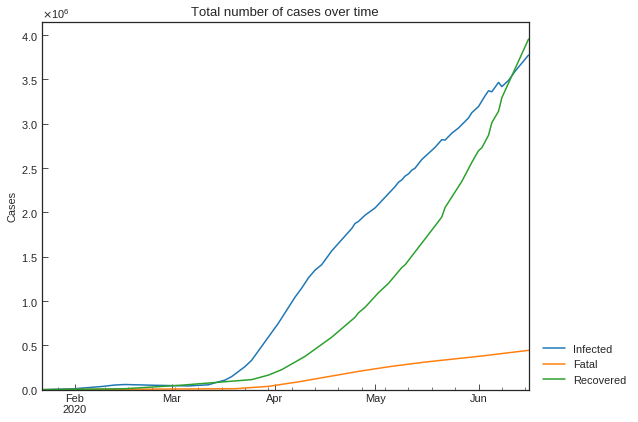

In [21]:
cs.line_plot(total_df[data_cols], "Total number of cases over time")

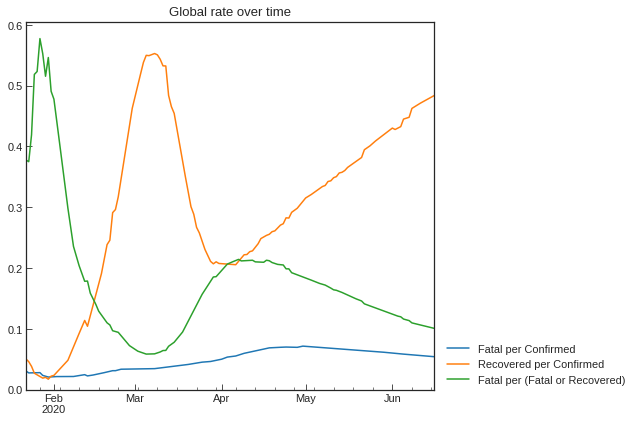

In [22]:
cs.line_plot(total_df[rate_cols], "Global rate over time", ylabel="", math_scale=False)

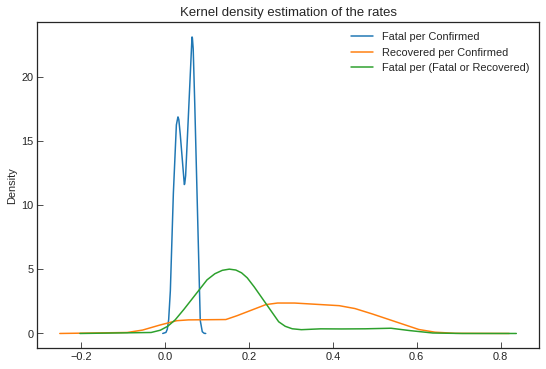

In [23]:
total_df[rate_cols].plot.kde()
plt.title("Kernel density estimation of the rates")
plt.show()

In [24]:
total_df[rate_cols].describe().T

count      mean       std       min       25%  \
Fatal per Confirmed             147.0  0.048624  0.017244  0.020424  0.033950   
Recovered per Confirmed         147.0  0.299756  0.148036  0.017267  0.210377   
Fatal per (Fatal or Recovered)  147.0  0.179198  0.110063  0.057462  0.109940   

                                     50%       75%       max  
Fatal per Confirmed             0.053957  0.065071  0.071656  
Recovered per Confirmed         0.311884  0.418405  0.552893  
Fatal per (Fatal or Recovered)  0.158823  0.206332  0.577465

## Data cleaning: Linelist (COVID19_open_line_list.csv)

In [25]:
linelist_open_raw = pd.read_csv("/kaggle/input/novel-corona-virus-2019-dataset/COVID19_open_line_list.csv")
linelist_open_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14126 entries, 0 to 14125
Data columns (total 45 columns):
ID                          13173 non-null float64
age                         1349 non-null object
sex                         1264 non-null object
city                        10194 non-null object
province                    12906 non-null object
country                     13148 non-null object
wuhan(0)_not_wuhan(1)       13170 non-null float64
latitude                    13147 non-null float64
longitude                   13147 non-null float64
geo_resolution              13147 non-null object
date_onset_symptoms         746 non-null object
date_admission_hospital     730 non-null object
date_confirmation           13089 non-null object
symptoms                    493 non-null object
lives_in_Wuhan              565 non-null object
travel_history_dates        503 non-null object
travel_history_location     758 non-null object
reported_market_exposure    35 non-null object
addi

In [26]:
df = linelist_open_raw.loc[:, ~linelist_open_raw.columns.str.startswith("Unnamed:")]
df = df.dropna(axis=0, how="all")
df = df.drop(
    [
        # Unnecessary in this notebook
        "ID", "wuhan(0)_not_wuhan(1)", "admin3", "admin2", "admin1", "country_new", "admin_id",
        "data_moderator_initials", "source", "location", "lives_in_Wuhan", "notes_for_discussion",
        "sequence_available", "reported_market_exposure",
        # Maybe useful, but un-used
        "city", "latitude", "longitude", "geo_resolution", "additional_information",
        "travel_history_dates", "travel_history_location", 
    ],
    axis=1
)
# Personal
age = linelist_open_raw["age"].str.split("-", expand=True)
age[0] = pd.to_numeric(age[0], errors="coerce")
age[1] = pd.to_numeric(age[1], errors="coerce")
df["Age"] = age.mean(axis=1)
df["Age"] = df["Age"].fillna(df["Age"].median()).astype(np.int64)
df["Sex"] = df["sex"].fillna("-").str.replace("4000", "-").str.capitalize()
# Place
df["Country"] = df["country"].fillna("-")
df["Province"] = df["province"].fillna("-")
# Onset Date
series = df["date_onset_symptoms"].str.replace("end of December 2019", "31.12.2019").replace("-25.02.2020", "25.02.2020")
series = series.replace("20.02.220", "20.02.2020").replace("none", np.NaN).replace("10.01.2020 - 22.01.2020", np.NaN)
df["Onset_date"] = pd.to_datetime(series)
# Hospitalized date
series = df["date_admission_hospital"].replace("18.01.2020 - 23.01.2020", np.NaN)
df["Hospitalized_date"] = pd.to_datetime(series)
# Confirmed date
series = df["date_confirmation"].replace("25.02.2020-26.02.2020", np.NaN)
df["Confirmed_date"] = pd.to_datetime(series)
# Symptoms/events
df["Symptoms"] = df["symptoms"].fillna("-").str.lower()
# Underlying disease
df["Underlying_disease"] = df[["chronic_disease_binary", "chronic_disease"]].apply(
    lambda x: "No" if x[0] == 0 else x[1] if x[1] is not np.NaN else "-",
    axis=1
).str.strip(";").str.replace("; ", ",").str.replace(", ", ",")
# Outcome
df["Outcome"] = df["outcome"].replace(
    {
        "discharge": "discharged", "Discharged": "discharged", "death": "died",
        "critical condition, intubated as of 14.02.2020": "severe",
        "treated in an intensive care unit (14.02.2020)": "severe", "05.02.2020": "-",
        "Symptoms only improved with cough. Currently hospitalized for follow-up.": "stable"
    }
).fillna("-")
series = df["date_death_or_discharge"].replace("discharge", np.NaN)
df["Closed_date"] = pd.to_datetime(series)
# Show
use_cols = [
    "Age", "Sex", "Country", "Province", "Onset_date", "Hospitalized_date", "Confirmed_date", 
    "Symptoms", "Underlying_disease", "Outcome", "Closed_date"
]
open_linelist_df = df.loc[:, use_cols]
open_linelist_df.head()

Age     Sex Country Province Onset_date Hospitalized_date Confirmed_date  \
0   30    Male   China    Anhui 2020-01-18        2020-01-20     2020-01-22   
1   47    Male   China    Anhui 2020-10-01        2020-01-21     2020-01-23   
2   49    Male   China    Anhui 2020-01-15        2020-01-20     2020-01-23   
3   47  Female   China    Anhui 2020-01-17        2020-01-20     2020-01-23   
4   50  Female   China    Anhui 2020-10-01        2020-01-21     2020-01-23   

  Symptoms Underlying_disease Outcome Closed_date  
0        -                  -       -         NaT  
1        -                  -       -         NaT  
2        -                  -       -         NaT  
3        -                  -       -         NaT  
4        -                  -       -         NaT

## Data cleaning: Linelist (COVID19_line_list_data.csv)
Linelist in clinical trials is a list of many case reports.

In [27]:
linelist_raw = pd.read_csv("/kaggle/input/novel-corona-virus-2019-dataset/COVID19_line_list_data.csv")
linelist_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1085 entries, 0 to 1084
Data columns (total 27 columns):
id                       1085 non-null int64
case_in_country          888 non-null float64
reporting date           1084 non-null object
Unnamed: 3               0 non-null float64
summary                  1080 non-null object
location                 1085 non-null object
country                  1085 non-null object
gender                   902 non-null object
age                      843 non-null float64
symptom_onset            563 non-null object
If_onset_approximated    560 non-null float64
hosp_visit_date          507 non-null object
exposure_start           128 non-null object
exposure_end             341 non-null object
visiting Wuhan           1085 non-null int64
from Wuhan               1081 non-null float64
death                    1085 non-null object
recovered                1085 non-null object
symptom                  270 non-null object
source                   108

In [28]:
linelist_raw.head()

id  case_in_country reporting date  Unnamed: 3  \
0   1              NaN      1/20/2020         NaN   
1   2              NaN      1/20/2020         NaN   
2   3              NaN      1/21/2020         NaN   
3   4              NaN      1/21/2020         NaN   
4   5              NaN      1/21/2020         NaN   

                                                                                                                                                                                                                                                                                                                                                                                                                summary  \
0  First confirmed imported COVID-19 pneumonia patient in Shenzhen (from Wuhan): male, 66, shenzheng residence, visited relatives in Wuhan on 12/29/2019, symptoms onset on 01/03/2020, returned to Shenzhen and seek medical care on 01/04/2020, hospitalized on 01/11/2020, sample sent to China CDC for testing on 01/18/2020, confirmed on 01/19/2020. 8 others under medical observation, contact tracing ongoing.   
1                                                                                                                                                                     First confirmed imported COVID-19 pneumonia patient in Shanghai (from Wuhan): female, 56, Wuhan residence, arrived in Shanghai from Wuhan on 01/12/2020, symptom onset and visited fever clinic on 01/15/2020, laboratory confirmed on 01/20/2020   
2                                                                                                                                         First confirmed imported cases in Zhejiang: patient is male, 46, lives in Wuhan, self-driving from Wuhan to Hangzhou on 01/03/2020, symptom onset 01/04/2020, hospitalized on 01/17/2020, sample deliver to China CDC for testing on 01/20/2020, test positive on 01/21/2020.   
3                                                                                                                                                                                                                                             new confirmed imported COVID-19 pneumonia in Tianjin: female, age 60, recently visited Wuhan, visited fever clinic on 01/19/2020 in Tianjin then quarantined immediately.   
4                                                                                                                                                                                                                                                                                                               new confirmed imported COVID-19 pneumonia in Tianjin: male, age 58, visited fever clinic on 01/14/2020.   

              location country  gender   age symptom_onset  ...  recovered  \
0  Shenzhen, Guangdong   China    male  66.0      01/03/20  ...          0   
1             Shanghai   China  female  56.0     1/15/2020  ...          0   
2             Zhejiang   China    male  46.0      01/04/20  ...          0   
3              Tianjin   China  female  60.0           NaN  ...          0   
4              Tianjin   China    male  58.0           NaN  ...          0   

  symptom                                                  source  \
0     NaN                    Shenzhen Municipal Health Commission   
1     NaN  Official Weibo of Shanghai Municipal Health Commission   
2     NaN                  Health Commission of Zhejiang Province   
3     NaN                                                人民日报官方微博   
4     NaN                                                人民日报官方微博   

                                                                                                             link  \
0                                                          http://wjw.sz.gov.cn/wzx/202001/t20200120_18987787.htm   
1  https://www.weibo.com/2372649470/IqogQhgfa?from=page_1001062372649470_profile&wvr=6&mod=weibotim

In [29]:
df = linelist_raw.loc[:, ~linelist_raw.columns.str.startswith("Unnamed:")]
df = df.drop(["id", "case_in_country", "summary", "source", "link"], axis=1)
# Date
case_date_dict = {
    "reporting date": "Confirmed_date",
    "exposure_start": "Exposed_date",
    "exposure_end": "Quarantined_date",
    "hosp_visit_date": "Hospitalized_date",
    "symptom_onset": "Onset_date",
    "death": "Deaths_date",
    "recovered": "Recovered_date"    
}
df["death"] = df["death"].replace({"0": "", "1": ""})
df["recovered"] = df["recovered"].replace({"0": "", "1": "", "12/30/1899": "12/30/2019"})
for (col, _) in case_date_dict.items():
    df[col] = pd.to_datetime(df[col])
df = df.rename(case_date_dict, axis=1)
# Location
df["Country"] = df["country"].fillna("-")
df["Province"] = df["location"].fillna("-")
df["Province"] = df[["Country", "Province"]].apply(lambda x: "-" if x[0] == x[1] else x[1], axis=1)
# Personal
df["Gender"] = df["gender"].fillna("-").str.capitalize()
df["Age"] = df["age"].fillna(df["age"].median()).astype(np.int64) ## Fill in NA with median
df["From_Wuhan"] = df["from Wuhan"]
df["To_Wuhan"] = df["visiting Wuhan"]
# Medical
df["Events"] = df["symptom"].fillna("-")
# Order of columns
linelist_df = df.loc[
    :,
    [
        "Country", "Province",
        "Exposed_date", "Onset_date", "Hospitalized_date", "Confirmed_date", "Quarantined_date", "Deaths_date", "Recovered_date",
        "Events",
        "Gender", "Age", "From_Wuhan", "To_Wuhan"
    ]
]
linelist_df.tail()

Country   Province Exposed_date Onset_date Hospitalized_date  \
1080      Austria  Innsbruck          NaT        NaT               NaT   
1081  Afghanistan          -          NaT        NaT               NaT   
1082      Algeria          -          NaT        NaT               NaT   
1083      Croatia          -   2020-02-19        NaT               NaT   
1084  Switzerland       Bern   2020-02-15 2020-02-17               NaT   

     Confirmed_date Quarantined_date Deaths_date Recovered_date Events Gender  \
1080     2020-02-25              NaT         NaT            NaT      -      -   
1081     2020-02-24              NaT         NaT            NaT      -      -   
1082     2020-02-26       2020-02-17         NaT            NaT      -   Male   
1083     2020-02-25       2020-02-21         NaT            NaT      -   Male   
1084     2020-02-25       2020-02-15         NaT            NaT      -   Male   

      Age  From_Wuhan  To_Wuhan  
1080   24         0.0         0  
1081   35         0.0         0  
1082   51         0.0         0  
1083   51         0.0         0  
1084   70         0.0         0

In [30]:
linelist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1085 entries, 0 to 1084
Data columns (total 14 columns):
Country              1085 non-null object
Province             1085 non-null object
Exposed_date         128 non-null datetime64[ns]
Onset_date           563 non-null datetime64[ns]
Hospitalized_date    507 non-null datetime64[ns]
Confirmed_date       1084 non-null datetime64[ns]
Quarantined_date     341 non-null datetime64[ns]
Deaths_date          21 non-null datetime64[ns]
Recovered_date       152 non-null datetime64[ns]
Events               1085 non-null object
Gender               1085 non-null object
Age                  1085 non-null int64
From_Wuhan           1081 non-null float64
To_Wuhan             1085 non-null int64
dtypes: datetime64[ns](7), float64(1), int64(2), object(4)
memory usage: 118.8+ KB


In [31]:
linelist_df.describe(include="all").fillna("-")

Country Province         Exposed_date           Onset_date  \
count     1085     1085                  128                  563   
unique      38      135                   37                   62   
top      China        -  2020-01-26 00:00:00  2020-01-23 00:00:00   
freq       197      464                   14                   29   
first        -        -  2019-12-17 00:00:00  2019-12-10 00:00:00   
last         -        -  2020-02-21 00:00:00  2020-02-26 00:00:00   
mean         -        -                    -                    -   
std          -        -                    -                    -   
min          -        -                    -                    -   
25%          -        -                    -                    -   
50%          -        -                    -                    -   
75%          -        -                    -                    -   
max          -        -                    -                    -   

          Hospitalized_date       Confirmed_date     Quarantined_date  \
count                   507                 1084                  341   
unique                   58                   43                   50   
top     2020-01-23 00:00:00  2020-02-27 00:00:00  2020-01-22 00:00:00   
freq                     34                   91                   35   
first   2019-12-27 00:00:00  2020-01-13 00:00:00  2020-01-02 00:00:00   
last    2020-02-28 00:00:00  2020-02-28 00:00:00  2020-02-25 00:00:00   
mean                      -                    -                    -   
std                       -                    -                    -   
min                       -                    -                    -   
25%                       -                    -                    -   
50%                       -                    -                    -   
75%                       -                    -                    -   
max                       -                    -                    -   

                Deaths_date       Recovered_date Events Gender      Age  \
count                    21                  152   1085   1085     1085   
unique                   12                   30    109      3        -   
top     2020-02-23 00:00:00  2020-02-19 00:00:00      -   Male        -   
freq                      4                   13    815    520        -   
first   2020-02-01 00:00:00  2019-12-30 00:00:00      -      -        -   
last    2020-02-28 00:00:00  2020-02-28 00:00:00      -      -        -   
mean                      -                    -      -      -  49.8212   
std                       -                    -      -      -  16.1036   
min                       -                    -      -      -        0   
25%                       -                    -      -      -       39   
50%                       -                    -      -      -       51   
75%                       -                    -      -      -       58   
max                       -                    -      -      -       96   

       From_Wuhan  To_Wuhan  
count        1081      1085  
unique          -         -  
top             -         -  
freq            -         -  
first           -         -  
last            -         -  
mean     0.144311  0.176959  
std      0.351567   0.38181  
min             0         0  
25%             0         0  
50%             0         0  
75%             0         0  
max             1         1

In [32]:
period_df = linelist_df.loc[:, ["Exposed_date", "Onset_date", "Confirmed_date"]]
period_df["Latent [min]"] = (period_df["Onset_date"] - period_df["Exposed_date"]).dt.total_seconds() / 60
period_df["Waiting [min]"] = (period_df["Confirmed_date"] - period_df["Onset_date"]).dt.total_seconds() / 60
period_df["Latent [day]"] = period_df["Latent [min]"] / 60 / 24
period_df["Waiting [day]"] = period_df["Waiting [min]"] / 60 / 24
period_df["Latent + Waiting [day]"] = period_df["Latent [day]"] + period_df["Waiting [day]"]
period_df.dropna(axis=0).tail()

Exposed_date Onset_date Confirmed_date  Latent [min]  Waiting [min]  \
948    2020-01-25 2020-02-24     2020-02-24       43200.0            0.0   
949    2020-01-25 2020-02-04     2020-02-24       14400.0        28800.0   
957    2020-01-25 2020-02-12     2020-02-26       25920.0        20160.0   
958    2020-01-25 2020-02-17     2020-02-26       33120.0        12960.0   
1084   2020-02-15 2020-02-17     2020-02-25        2880.0        11520.0   

      Latent [day]  Waiting [day]  Latent + Waiting [day]  
948           30.0            0.0                    30.0  
949           10.0           20.0                    30.0  
957           18.0           14.0                    32.0  
958           23.0            9.0                    32.0  
1084           2.0            8.0                    10.0

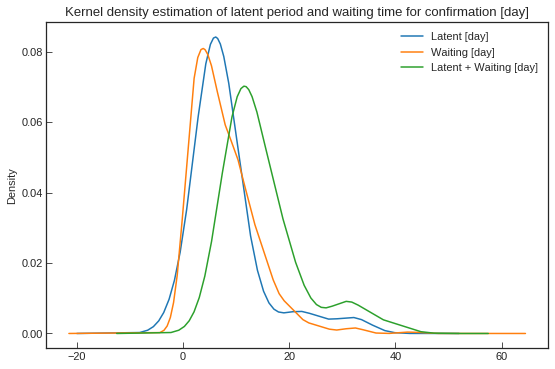

count       mean       std  min   25%   50%   75%  \
Latent [day]             83.0   8.180723  6.786185 -2.0   4.0   6.0   9.0   
Waiting [day]           563.0   7.682060  5.890473  0.0   3.0   6.0  11.0   
Latent + Waiting [day]   83.0  14.819277  7.305435  5.0  10.0  13.0  17.5   

                         max  
Latent [day]            34.0  
Waiting [day]           43.0  
Latent + Waiting [day]  40.0

In [33]:
cols = ["Latent [day]", "Waiting [day]", "Latent + Waiting [day]"]
period_df[cols].plot.kde()
plt.title("Kernel density estimation of latent period and waiting time for confirmation [day]")
plt.show()
period_df[cols].describe().T

## Measures in each country

In [34]:
action_raw = dd.read_csv(
    "/kaggle/input/covid19-containment-and-mitigation-measures/COVID 19 Containment measures data.csv"
).compute()
action_raw.head()

ID Applies To         Country    Date Start Date end intended  \
0  163        NaN         Austria  Mar 16, 2020               NaN   
1  132        NaN         Germany  Feb 01, 2020               NaN   
2  578        NaN  United Kingdom  Mar 20, 2020               NaN   
3  372        NaN  United Kingdom  Mar 16, 2020               NaN   
4  357        NaN  United Kingdom  Mar 16, 2020               NaN   

                                                                                                                                                                                                                                                                                                                                                   Description of measure implemented  \
0                                                                                                                                                                                                                                                                     On 10 March 2020 government announced that all universities will close their classes at the latest by 16 March.   
1  102 German citizens and 26 relatives, all of whom were symptom-free on departure, were evacuated from the Wuhan region to Frankfurt am Main by the Executive Transport Wing of the German Air Force. After their return, they were placed in quarantine in a military barrack in Rhineland-Palatinate for 14 days.[716] The coronavirus was found in two passengers on 2 February.   
2                                                                                                                                                                                                                                                                                                                                         All schools, nurseries and colleges closed.   
3                                                                                                                                                                                                                                                                 If one person in any household has a persistent cough or fever, everyone living there must stay at home for 14 days   
4                                                                                                                                                                                                                                                    By the weekend, those with the most serious health conditions must be "largely shielded from social contact for around 12 weeks"   

  Exceptions Implementing City Implementing State/Province  \
0        NaN               NaN                         NaN   
1        NaN               NaN                         NaN   
2        NaN               NaN                         NaN   
3        NaN               NaN                         NaN   
4        NaN               NaN                         NaN   

                                                                 Keywords  \
0                                                      university closure   
1  international traveller quarantine - risk countries, traveller testing   
2              nursery school closure, school closure, university closure   
3                                            blanket isolation - symptoms   
4                                             isolation advice to elderly   

   Quantity  \
0       NaN   
1    0.0001   
2       NaN   
3       NaN   
4       NaN   

                                                                                                        Source  \
0                                           https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Austria   
1                                            https://www.tagesschau.de/inland/coronavirus-germersheim-107.html   
2  https://www.theguardian.com/world/2020/mar/18/coronavi

In [35]:
df  = action_raw.copy()
df = df.rename(
    {
        "Description of measure implemented": "Details",
        "Implementing State/Province": "Province",
    },
    axis=1
)
# Country/Province
df["Country"] = df["Country"].replace({"United Kingdom": "UK"})
df["Country"] = df["Country"].str.replace("US: ", "US/").str.replace("US:", "US/")
df = df.loc[~df["Country"].isnull(), :]
df["Province"] = df["Province"].fillna("-")
df[["Country", "Province", "-"]] = (df["Country"] + "/" + df["Province"]).str.split("/", expand=True)
# Date
df["Start_date"] = pd.to_datetime(df["Date Start"])
df["End_date"] = pd.to_datetime(df["Date end intended"])
df = df.loc[~df["Start_date"].isnull(), :]
# Detail
df = df.loc[~df["Details"].isnull(), :]
df["Keywords"] = df["Keywords"].fillna("-")
df["Exceptions"] = df["Exceptions"].fillna("-")
# _df = df["Keywords"].str.split(", ", expand=True)
# df = pd.concat([df, _df], axis=1)
# Save
df = df.loc[:, ["Country", "Province", "Start_date", "End_date", "Keywords", "Details", "Exceptions"]]
df = df.sort_values(["Start_date", "End_date", "Country", "Province"])
action_df = df.copy()
action_df.head()

Country Province Start_date End_date  \
150      China    Hubei 2019-12-18      NaT   
151      China    Hubei 2019-12-25      NaT   
152      China    Hubei 2019-12-30      NaT   
138  Hong Kong        - 2019-12-30      NaT   
149      Macau        - 2019-12-30      NaT   

                                                Keywords  \
150                                           first case   
151       compulsory isolation, confirmed case isolation   
152             case reporting, research, source tracing   
138  international traveller quarantine - risk countries   
149    international traveller screening - all countries   

                                                                                                                                                                                                                         Details  \
150                                                                                                                                                                                  Seven cases of COVID-19 documented in Wuhan   
151                                                                                                          Medical staff in two Wuhan hospitals were suspected of contracting the virus; first reports of isolation being used   
152                       Wuhan CDC confirmed 27 cases of viral pneumonia of unknown cause; all hospitals required to report all cases of unkown origin and related to Huanan Seafood Market and give patients proper treatment;   
138  Hong Kong Secretary for Food and Health announced that suspected cases presenting with symptoms of pneumonia acute respiratory illness fever and a recent travel to Wuhan within the last 14 days would be put in isolation   
149                                                                                                                                                                                        Tightened inbound traveller screening   

    Exceptions  
150          -  
151          -  
152          -  
138          -  
149          -

In [36]:
words = pd.Series(", ".join(action_df["Keywords"].tolist()).split(", ")).unique().tolist()
words

['first case',
 'compulsory isolation',
 'confirmed case isolation',
 'case reporting',
 'research',
 'source tracing',
 'international traveller quarantine - risk countries',
 'international traveller screening - all countries',
 'coronavirus education activities',
 'encouraging symptomatic people to seek tests',
 'international traveller screening - risk countries',
 'limited nonessential business suspension',
 'test travellers',
 'contacts traced total',
 'outbound travel warning',
 'public announcement',
 'special management arrangements',
 'task group',
 'hospital specialisation',
 'contact isolation - no symptoms',
 'contact tracing',
 'public mask and hygiene supply',
 'testing commenced',
 'international travel ban - risk countries',
 'international traveller screening - symptomatic',
 'general nonessential business suspension',
 'hygiene enforcement',
 'quarantine zone',
 'cluster isolation - no symptoms',
 'traveller testing',
 'wild animal ban',
 'phone line',
 'moves of med

In [37]:
vectorizer = TfidfVectorizer(use_idf=True)
vecs = vectorizer.fit_transform(words)
clusters = KMeans(n_clusters=20, random_state=0).fit_predict(vecs)
df = pd.DataFrame(
    {
        "Group": clusters,
        "Word": words
    }
)
df = df.sort_values("Group")
df = pd.DataFrame(df.groupby("Group")["Word"].apply(lambda x: ", ".join(x)))
df

Word
Group                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
0      sentence, epidemic data, ban on visit to nursing homes, intellectual property, unemployment benefits extension, medical staff protective equipment, handwashing encouragement, retired doctors called, restaurant limitations, eviction moratorium, activism for stricter measures, first death, military takeover, outdoor gatherings banned, manufacturing capacity, economic stimulus, emergency declaration, weddings canceled, riots, social distancing, prisons closed to visitors, business resumed, quaratine violation, price gouging ban, -, total vehicle ban, community spread, low compliance, prisoner release, sewing plain clothes masks, army deployed, indoor person density, financial incentive, visa suspension, cash cleaning, clinic specialisation, symptom hotline, protective equipment supplies, indoor gatherings banned, medical aid, mitigation focus, elderly, economic incentives, wild animal ban, looking for children, evictions prohibited, shopping vouchers, space minimum, exam postpone, hea...
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        airport closure, school closure - limited, public green closure, closure of gathering places, closure nonessential stores, school closure, university closure, nursery school closure
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                domestic traveller screening, international traveller quarantine - risk countries, international traveller screening - all countries, international traveller screening - risk countries, outbound traveller ban, international aid, international travel ban - all countries, international travel ban - risk countries, international traveller screening - symptomatic, international trav

## Measures in Italy

In [38]:
ita_action_raw = pd.read_excel(
    "/kaggle/input/covid19-prevention-in-italy/Dataset_Italy_COVID_19.xlsx",
    sheet_name="Foglio1"
)
ita_action_raw.head()

Country            Region  \
0   Italy               NaN   
1   Italy               NaN   
2   Italy               NaN   
3   Italy               NaN   
4   Italy  Lombardia,Veneto   

                                                                                                                                                                      Village  \
0                                                                                                                                                                         NaN   
1                                                                                                                                                                         NaN   
2                                                                                                                                                                         NaN   
3                                                                                                                                                                         NaN   
4  Vo’ Euganeo (Veneto) e Codogno, Castiglione d’Adda, Casalpusterlengo, Fombio, Maleo, Somaglia, Bertonico, Terranova dei Passerini, Castelgerundo e San Fiorano (Lombardia)   

    Start date     End Date  \
0  30-jan-2020          NaN   
1  03-feb-2020          NaN   
2  06-feb-2020          NaN   
3  21-feb-2020  21-feb-2020   
4  23-feb-2020          NaN   

                                                  Action  \
0                                   Restriction of entry   
1                               Leave from epidemic area   
2                                 Control in the Airport   
3                                            Quaranteene   
4  containment and management the Italian infected areas   

                                                                                                                                                                                               Detail  \
0                                                                                                                                                   All flights to and from China have been suspended   
1                                                                         Return of people present in countries at risk and return of foreign citizens to the countries of origin exposed to the risk   
2                                                                                                                               Airport monitoring and control for domestic and international flights   
3  Mandatory quarantine isolation for close contacts with a positive cases, and provides active surveillance with fiduciary home permanence for those who have been in risk areas in the last 14 days   
4                                                                   decree-law introducing urgent measures regarding the containment and management of the epidemiological emergency from COVID-2019.   

  Number of people                                                        link  
0              NaN  http://www.governo.it/it/approfondimento/coronavirus/13968  
1              NaN  http://www.governo.it/it/approfondimento/coronavirus/13969  
2            62000  http://www.governo.it/it/approfondimento/coronavirus/13970  
3              NaN  http://www.governo.it/it/approfondimento/coronavirus/13971  
4           53856‬  http://www.governo.it/it/approfondimento/coronavirus/13972

In [39]:
df = ita_action_raw.copy()
df = df.drop(["Country", "Village", "link"], axis=1)
df.columns = [col.capitalize().replace(" ", "_") for col in df.columns]
df["Start_date"] = pd.to_datetime(df["Start_date"])
df["End_date"] = pd.to_datetime(df["End_date"])
df["Region"] = df["Region"].fillna("-")
df["Number_of_people"] = df["Number_of_people"].fillna(-1)
ita_action_df = df.copy()
ita_action_df.tail()

Region  \
7   Emilia Romagna,Friuli Venezia Giulia, Lombardia, Veneto, Piemonte e Liguria,   
8                                                                              -   
9                                                                              -   
10                                                                             -   
11                                                                             -   

   Start_date   End_date  \
7  2020-03-07 2020-03-07   
8  2020-03-09 2020-05-04   
9  2020-03-19        NaT   
10 2020-03-20        NaT   
11 2020-04-14        NaT   

                                                        Action  \
7   more containment and management the Italian infected areas   
8                                                     lockdown   
9                                      Medicine sperimentation   
10                                                  task force   
11                                        open some businesses   

                                                                                                                                        Detail  \
7                                     prohibit any movement in Lombardy and in fourteen provinces of Veneto, Emilia Romagna, Piedmont, Marche.   
8         people must stay at home and go out only for food or work needs. Many activities are closed and only the essential ones remain open.   
9   testing began on the drug Tocilizumab, a drug used against rheumatoid arthritis that has had beneficial effects against COVID-19 in China.   
10                 create a task force of doctors from all over Italy to be able to send to the territories with the greatest health problems.   
11                                                     Reopening of some production activities, newsagents, baby clothing stores, freelancers.   

   Number_of_people  
7                -1  
8          60483973  
9               330  
10               -1  
11               -1

## The number of cases in Japan at prefecture level

In [40]:
jpn_pref_raw = pd.read_csv("/kaggle/input/covid19-dataset-in-japan/covid_jpn_prefecture.csv")
jpn_pref_raw.tail()

Date Prefecture  Positive  Tested  Discharged  Fatal  \
4272  2020-06-16   Kumamoto        48  4130.0        45.0    3.0   
4273  2020-06-16       Oita        60  4462.0        59.0    1.0   
4274  2020-06-16   Miyazaki        17  1487.0        17.0    0.0   
4275  2020-06-16  Kagoshima        11  2305.0        10.0    0.0   
4276  2020-06-16    Okinawa       142  2966.0       139.0    7.0   

      Hosp_require  Hosp_severe  
4272           0.0          0.0  
4273           0.0          0.0  
4274           0.0          0.0  
4275           1.0          0.0  
4276           0.0          0.0

In [41]:
df = jpn_pref_raw.copy()
df.dropna(how="all", inplace=True)
df["Date"] = pd.to_datetime(df["Date"])
sel = df.columns.isin(["Date", "Prefecture"])
df = df.groupby("Prefecture").apply(
    lambda x: x.set_index("Date").resample("D").interpolate("linear")
)
df = df.fillna(0)
df = df.drop("Prefecture", axis=1).reset_index()
df = df.sort_values("Date").reset_index(drop=True)
sel = df.columns.isin(["Date", "Prefecture"])
df.loc[:, ~sel] = df.loc[:, ~sel].interpolate("linear").astype(np.int64)
jpn_pref_df = df.copy()
jpn_pref_df.tail()

Prefecture       Date  Positive  Tested  Discharged  Fatal  Hosp_require  \
4272       Saga 2020-06-16        47    1568          47      0             0   
4273      Chiba 2020-06-16       919   16716         850     45            24   
4274     Toyama 2020-06-16       227    3722         203     22             2   
4275      Ehime 2020-06-16        82    2532          73      4             5   
4276  Yamanashi 2020-06-16        71    4968          68      1             2   

      Hosp_severe  
4272            0  
4273            3  
4274            0  
4275            0  
4276            0

## Metadata of prefectures in Japan

In [42]:
jpn_meta_raw = pd.read_csv("/kaggle/input/covid19-dataset-in-japan/covid_jpn_metadata.csv")
jpn_meta_raw.tail()

Prefecture Category Item Value        Date  \
841   Kumamoto    Admin  Num    43  2012-04-27   
842       Oita    Admin  Num    44  2012-04-27   
843   Miyazaki    Admin  Num    45  2012-04-27   
844  Kagoshima    Admin  Num    46  2012-04-27   
845    Okinawa    Admin  Num    47  2012-04-27   

                                           Primary_source Secondary_source  
841  http://nlftp.mlit.go.jp/ksj/gml/codelist/PrefCd.html              NaN  
842  http://nlftp.mlit.go.jp/ksj/gml/codelist/PrefCd.html              NaN  
843  http://nlftp.mlit.go.jp/ksj/gml/codelist/PrefCd.html              NaN  
844  http://nlftp.mlit.go.jp/ksj/gml/codelist/PrefCd.html              NaN  
845  http://nlftp.mlit.go.jp/ksj/gml/codelist/PrefCd.html              NaN

In [43]:
df = jpn_meta_raw.copy()
df["Title"] = df["Category"].str.cat(df["Item"], sep="_")
df = df.pivot_table(
    index="Prefecture", columns="Title", values="Value", aggfunc="last"
)
# Integer
cols = df.columns.str.startswith("Population")
cols += df.columns.str.startswith("Area")
cols += df.columns.str.startswith("Hospital_bed")
cols += df.columns.str.startswith("Clinic_bed")
df.loc[:, cols] = df.loc[:, cols].astype(np.int64)
df["Admin_Num"] = df["Admin_Num"].astype(np.int64)
# Numeric
cols = df.columns.str.startswith("Location")
df.loc[:, cols] = df.loc[:, cols].astype(np.float64)
# Sorting
df = df.loc[jpn_meta_raw["Prefecture"].unique(), :]
jpn_meta_df = df.copy()
jpn_meta_df.head()

Title      Admin_Captial  Admin_Num Admin_Region Area_Habitable Area_Total  \
Prefecture                                                                   
Hokkaido         Sapporo          1     Hokkaido          22373      83424   
Aomori            Aomori          2       Tohoku           3230       9646   
Iwate            Morioka          3       Tohoku           3714      15275   
Miyagi            Sendai          4       Tohoku           3155       7282   
Akita              Akita          5       Tohoku           3204      11638   

Title      Clinic_bed_Care Clinic_bed_Total Hospital_bed_Care  \
Prefecture                                                      
Hokkaido               428             5585             20822   
Aomori                 114             1906              2614   
Iwate                   98             1255              2310   
Miyagi                  91             1468              3431   
Akita                   77              721              2035   

Title      Hospital_bed_Specific Hospital_bed_Total Hospital_bed_Tuberculosis  \
Prefecture                                                                      
Hokkaido                       0              93050                       153   
Aomori                         0              17075                        33   
Iwate                          0              16557                        91   
Miyagi                         0              25121                        28   
Akita                          0              14627                        44   

Title      Hospital_bed_Type-I Hospital_bed_Type-II  Location_Latitude  \
Prefecture                                                               
Hokkaido                     2                   92          43.065063   
Aomori                       1                   28          40.824592   
Iwate                        2                   36          39.703670   
Miyagi                       2                   27          38.268915   
Akita                        2                   30          39.718353   

Title       Location_Longitude Population_Female Population_Male  \
Prefecture                                                         
Hokkaido            141.347644              2814            2506   
Aomori              140.740031               678             600   
Iwate               141.152717               651             604   
Miyagi              140.872212              1188            1136   
Akita               140.103416               528             468   

Title      Population_Total  
Prefecture                   
Hokkaido               5320  
Aomori                 1278  
Iwate                  1255  
Miyagi                 2323  
Akita                   996

# Grouping by growth factor<a id="2"></a>
The number of confirmed cases is increasing in many countries, but there are two of countries. In a first-type country, growth factor is larger than 1 and the number of cases is rapidly increasing. In a second-type country, growth factor is less than 1.

## Calculate growth factor
Where $C$ is the number of confirmed cases,  
$$\mathrm{Growth\ Factor} = \cfrac{\Delta \mathrm{C}_{n}}{\Delta \mathrm{C}_{n-1}}$$

In [44]:
df = ncov_df.pivot_table(
    index="Date", columns="Country", values="Confirmed", aggfunc="sum"
).fillna(method="ffill").fillna(0)
# Growth factor: (delta Number_n) / (delta Number_n)
df = df.diff() / df.diff().shift(freq="D")
df = df.replace(np.inf, np.nan).fillna(1.0)
# Rolling mean (window: 7 days)
df = df.rolling(7).mean().dropna().loc[:ncov_df["Date"].max(), :]
# round: 0.01
growth_value_df = df.round(2)
growth_value_df.tail()

Country      Azerbaijan  Afghanistan  Albania  Algeria  Andorra  Angola  \
Date                                                                      
2020-06-13          1.0         1.02     1.21     1.00     0.86    1.92   
2020-06-14          1.0         0.99     1.28     1.01     0.86    1.74   
2020-06-15          1.0         1.05     1.28     1.00     0.86    1.84   
2020-06-16          1.0         1.06     1.15     1.00     0.86    1.69   
2020-06-17          1.0         0.88     0.98     0.88     0.71    1.09   

Country     Antigua and Barbuda  Argentina  Armenia  Aruba  ...  Uzbekistan  \
Date                                                        ...               
2020-06-13                  1.0       1.08     1.18    1.0  ...        1.17   
2020-06-14                  1.0       1.09     1.11    1.0  ...        0.95   
2020-06-15                  1.0       1.07     1.16    1.0  ...        1.11   
2020-06-16                  1.0       1.03     1.06    1.0  ...        1.19   
2020-06-17                  1.0       0.88     0.88    1.0  ...        1.00   

Country     Vatican City  Venezuela  Vietnam  West Bank and Gaza  \
Date                                                               
2020-06-13           1.0       0.89     0.93                1.59   
2020-06-14           1.0       1.26     0.64                1.59   
2020-06-15           1.0       1.20     0.71                2.19   
2020-06-16           1.0       1.11     0.86                1.15   
2020-06-17           1.0       1.01     0.86                1.08   

Country     Western Sahara  Yemen  Zambia  Zimbabwe  \
Date                                                  
2020-06-13             1.0   1.96    0.76      1.66   
2020-06-14             1.0   1.99    0.62      1.92   
2020-06-15             1.0   1.85    3.90      1.71   
2020-06-16             1.0   1.57    4.04      1.08   
2020-06-17             1.0   1.38    3.90      1.05   

Country     occupied Palestinian territory  
Date                                        
2020-06-13                             1.0  
2020-06-14                             1.0  
2020-06-15                             1.0  
2020-06-16                             1.0  
2020-06-17                             1.0  

[5 rows x 219 columns]

## Grouping countires based on growth factor
* Outbreaking: growth factor $>$ 1 for the last 7 days
* Stopping: growth factor $<$ 1 for the last 7 days
* At a crossroad: the others

In [45]:
df = growth_value_df.copy()
df = df.iloc[-7:, :].T
day_cols = df.columns.strftime("%d%b%Y")
df.columns = day_cols
last_date = day_cols[-1]
# Grouping
more_col, less_col = "GF > 1 [straight days]", "GF < 1 [straight days]"
df[more_col] = (growth_value_df > 1).iloc[::-1].cumprod().sum(axis=0)
df[less_col] = (growth_value_df < 1).iloc[::-1].cumprod().sum(axis=0)
df["Group"] = df[[more_col, less_col]].apply(
    lambda x: "Outbreaking" if x[0] >= 7 else "Stopping" if x[1] >= 7 else "Crossroad",
    axis=1
)
# Sorting
df = df.loc[:, ["Group", more_col, less_col, *day_cols]]
df = df.sort_values(["Group", more_col, less_col], ascending=False)
growth_df = df.copy()
growth_df.head()

Group  GF > 1 [straight days]  GF < 1 [straight days]  \
Country                                                               
Nicaragua  Stopping                       0                      58   
Hong Kong  Stopping                       0                      41   
Benin      Stopping                       0                      32   
Guinea     Stopping                       0                      27   
Guyana     Stopping                       0                      24   

           11Jun2020  12Jun2020  13Jun2020  14Jun2020  15Jun2020  16Jun2020  \
Country                                                                       
Nicaragua       0.86       0.86       0.86       0.86       0.86       0.86   
Hong Kong       0.69       0.76       0.76       0.71       0.71       0.71   
Benin           0.66       0.80       0.70       0.74       0.79       0.87   
Guinea          0.63       0.53       0.57       0.69       0.66       0.84   
Guyana          0.71       0.64       0.50       0.64       0.64       0.64   

           17Jun2020  
Country               
Nicaragua       0.86  
Hong Kong       0.71  
Benin           0.87  
Guinea          0.84  
Guyana          0.64

In [46]:
df = pd.merge(ncov_df, growth_df["Group"].reset_index(), on="Country")
ncov_df = df.loc[:, ["Date", "Group", *ncov_df.columns[1:]]]
ncov_df.tail()

Date      Group Country Province  Confirmed  Infected  Fatal  \
42757 2020-06-13  Crossroad   Japan        -      17382       878    924   
42758 2020-06-14  Crossroad   Japan        -      17429       861    925   
42759 2020-06-15  Crossroad   Japan        -      17502       891    925   
42760 2020-06-16  Crossroad   Japan        -      17587       959    927   
42761 2020-06-17  Crossroad   Japan        -      17628       847    931   

       Recovered  
42757      15580  
42758      15643  
42759      15686  
42760      15701  
42761      15850

## Group 1: Outbreaking, growth factor $>$ 1 for the last 7 days

In [47]:
df = growth_df.loc[growth_df["Group"] == "Outbreaking", :]
", ".join(df.index.tolist()) + "."

'Rwanda, Luxembourg, Greece, Israel, Moldova, Sri Lanka, Lebanon, Malaysia, Paraguay, Togo, West Bank and Gaza, Yemen, Panama, Georgia, Bulgaria, Suriname, Eswatini, Zimbabwe, Austria, Lithuania, Sao Tome and Principe, Maldives, Angola, Australia, Denmark, Burma, Kyrgyzstan, China, Germany, India, Kazakhstan, Malta, Slovakia.'

In [48]:
growth_df.loc[growth_df["Group"] == "Outbreaking", :].head()

Group  GF > 1 [straight days]  GF < 1 [straight days]  \
Country                                                                   
Rwanda      Outbreaking                      39                       0   
Luxembourg  Outbreaking                      38                       0   
Greece      Outbreaking                      32                       0   
Israel      Outbreaking                      31                       0   
Moldova     Outbreaking                      31                       0   

            11Jun2020  12Jun2020  13Jun2020  14Jun2020  15Jun2020  16Jun2020  \
Country                                                                        
Rwanda           1.08       1.10       1.22       1.30       1.19       1.16   
Luxembourg       1.62       1.53       1.82       1.76       1.76       1.12   
Greece           1.36       1.36       1.26       1.40       1.17       1.30   
Israel           1.26       1.33       1.03       1.02       1.11       1.19   
Moldova          1.18       1.16       1.14       1.14       1.13       1.23   

            17Jun2020  
Country                
Rwanda           1.01  
Luxembourg       1.05  
Greece           1.14  
Israel           1.02  
Moldova          1.03

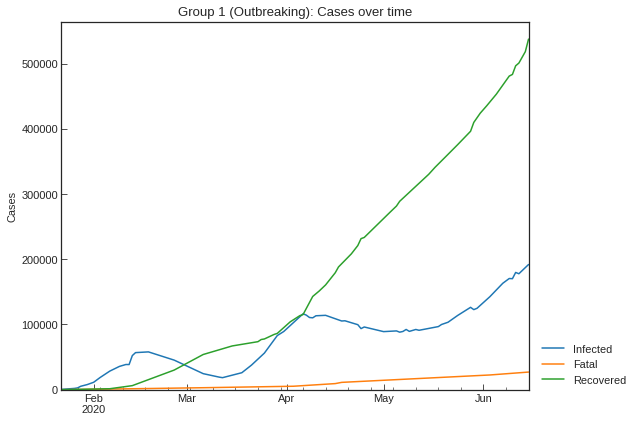

Infected  Fatal  Recovered
Date                                  
2020-06-11    179741  25409     496517
2020-06-12    177753  25447     500719
2020-06-13    182741  25899     509076
2020-06-14    187898  26246     518205
2020-06-15    191900  27033     537467

In [49]:
df = ncov_df.loc[ncov_df["Group"] == "Outbreaking", ["Date", *data_cols]]
df = df.groupby("Date").sum()
df = df.iloc[:-1, :]
cs.line_plot(df, "Group 1 (Outbreaking): Cases over time", y_integer=True)
df.tail()

## Group 2: Stopping, growth factor $<$ 1 for the last 7 days

In [50]:
df = growth_df.loc[growth_df["Group"] == "Stopping", :]
", ".join(df.index.tolist()) + "."

'Nicaragua, Hong Kong, Benin, Guinea, Guyana, Croatia, Ecuador, Namibia, Guinea-Bissau, Kosovo, Burundi, Botswana, Somalia, Belize, Bhutan, Cambodia, Canada, Malawi, South Sudan, Belarus, Tajikistan, Vietnam, Niger, Pakistan, Barbados, Bosnia and Herzegovina, Eritrea, United Arab Emirates.'

In [51]:
growth_df.loc[growth_df["Group"] == "Stopping", :].head()

Group  GF > 1 [straight days]  GF < 1 [straight days]  \
Country                                                               
Nicaragua  Stopping                       0                      58   
Hong Kong  Stopping                       0                      41   
Benin      Stopping                       0                      32   
Guinea     Stopping                       0                      27   
Guyana     Stopping                       0                      24   

           11Jun2020  12Jun2020  13Jun2020  14Jun2020  15Jun2020  16Jun2020  \
Country                                                                       
Nicaragua       0.86       0.86       0.86       0.86       0.86       0.86   
Hong Kong       0.69       0.76       0.76       0.71       0.71       0.71   
Benin           0.66       0.80       0.70       0.74       0.79       0.87   
Guinea          0.63       0.53       0.57       0.69       0.66       0.84   
Guyana          0.71       0.64       0.50       0.64       0.64       0.64   

           17Jun2020  
Country               
Nicaragua       0.86  
Hong Kong       0.71  
Benin           0.87  
Guinea          0.84  
Guyana          0.64

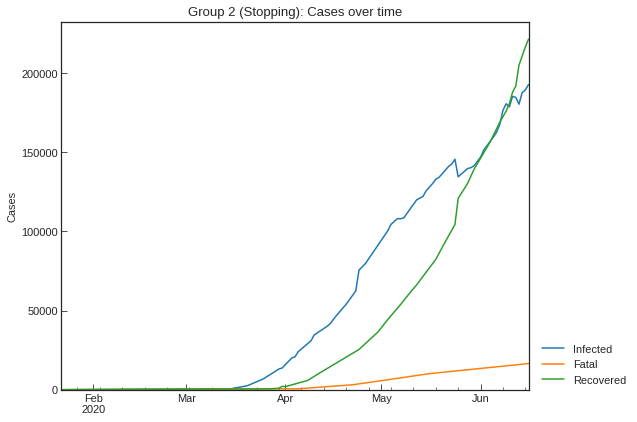

Infected  Fatal  Recovered
Date                                  
2020-06-12    184731  15655     191798
2020-06-13    180420  15864     205058
2020-06-14    187716  16107     211615
2020-06-15    189417  16273     216594
2020-06-16    192795  16516     221566

In [52]:
df = ncov_df.loc[ncov_df["Group"] == "Stopping", ["Date", *data_cols]].groupby("Date").sum()
cs.line_plot(df, "Group 2 (Stopping): Cases over time", y_integer=True)
df.tail()

## Group 3: At a crossroad, the others

In [53]:
df = growth_df.loc[growth_df["Group"] == "Crossroad", :]
", ".join(df.index.tolist()) + "."

'Cyprus, Ghana, Ireland, Colombia, Comoros, Japan, Liberia, Cuba, Djibouti, Libya, Tunisia, Venezuela, Congo, Norway, Uganda, Zambia, Sierra Leone, Belgium, Burkina Faso, Gabon, Mongolia, Peru, Andorra, Haiti, Uruguay, Kuwait, Serbia, Thailand, Central African Republic, Chad, Finland, Russia, Trinidad and Tobago, Cameroon, Estonia, Ethiopia, Jamaica, Montenegro, Netherlands, New Zealand, Philippines, Portugal, Qatar, Taiwan, Afghanistan, Albania, Algeria, Argentina, Armenia, Azerbaijan, Bahamas, Bahrain, Bangladesh, Bolivia, Brazil, Cabo Verde, Chile, Costa Rica, Czech Republic, Dominican Republic, Egypt, El Salvador, Equatorial Guinea, France, Guatemala, Honduras, Hungary, Iceland, Indonesia, Iran, Iraq, Ivory Coast, Jordan, Kenya, Latvia, Mali, Mauritania, Mexico, Morocco, Mozambique, Nepal, Nigeria, North Macedonia, Oman, Poland, Romania, Saint Vincent and the Grenadines, San Marino, Saudi Arabia, Senegal, Singapore, Slovenia, South Africa, South Korea, Spain, Sudan, Sweden, Switzer

In [54]:
growth_df.loc[growth_df["Group"] == "Crossroad", :].head()

Group  GF > 1 [straight days]  GF < 1 [straight days]  \
Country                                                               
Cyprus    Crossroad                       6                       0   
Ghana     Crossroad                       6                       0   
Ireland   Crossroad                       6                       0   
Colombia  Crossroad                       5                       0   
Comoros   Crossroad                       5                       0   

          11Jun2020  12Jun2020  13Jun2020  14Jun2020  15Jun2020  16Jun2020  \
Country                                                                      
Cyprus         0.76       1.33       1.33       1.33       1.21       1.17   
Ghana          0.87       1.20       1.13       1.51       1.29       1.28   
Ireland        0.95       1.10       1.50       1.39       1.67       1.58   
Colombia       1.04       0.87       1.02       1.04       1.09       1.09   
Comoros        0.71       0.71       2.43       2.43       2.43       2.43   

          17Jun2020  
Country              
Cyprus         1.17  
Ghana          1.28  
Ireland        1.29  
Colombia       1.09  
Comoros        2.29

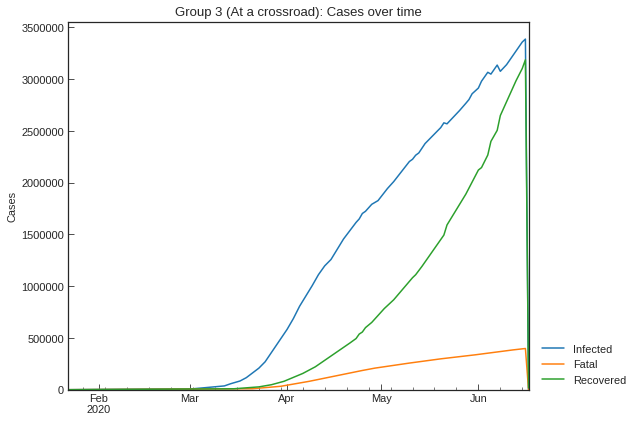

Infected   Fatal  Recovered
Date                                   
2020-06-13   3275721  387970    2984292
2020-06-14   3322465  390711    3040021
2020-06-15   3358897  393589    3103397
2020-06-16   3387184  398066    3187881
2020-06-17       847     931      15850

In [55]:
df = ncov_df.loc[ncov_df["Group"] == "Crossroad", ["Date", *data_cols]].groupby("Date").sum()
cs.line_plot(df, "Group 3 (At a crossroad): Cases over time", y_integer=True)
df.tail()

# SIR to SIR-F<a id="4"></a>
In this section, we will create a customized mathematical model derived from SIR model.

## SIR model
To understand the trend of infection, we will use mathematical epidemic model. Let's start discussion using the simplest model named SIR.

### What is SIR model?
SIR model is a simple mathematical model to understand outbreak of infectious diseases.  
[The SIR epidemic model - Learning Scientific Programming with Python](https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/)

 * S: Susceptible (=All - Confirmed)
 * I: Infected (=Confirmed - Recovered - Deaths)
 * R: Recovered or fatal (=Recovered + Deaths)
 
Note: THIS IS NOT THE GENERAL MODEL!  
Though R in SIR model is "Recovered and have immunity", I defined "R as Recovered or fatal". This is because mortality rate cannot be ignored in the real COVID-19 data.

Model:  
\begin{align*}
\mathrm{S} \overset{\beta I}{\longrightarrow} \mathrm{I} \overset{\gamma}{\longrightarrow} \mathrm{R}  \\
\end{align*}

$\beta$: Effective contact rate [1/min]  
$\gamma$: Recovery(+Mortality) rate [1/min]  

Ordinary Differential Equation (ODE):  
\begin{align*}
& \frac{\mathrm{d}S}{\mathrm{d}T}= - N^{-1}\beta S I  \\
& \frac{\mathrm{d}I}{\mathrm{d}T}= N^{-1}\beta S I - \gamma I  \\
& \frac{\mathrm{d}R}{\mathrm{d}T}= \gamma I  \\
\end{align*}

Where $N=S+I+R$ is the total population, $T$ is the elapsed time from the start date.

### Non-dimensional SIR model
To simplify the model, we will remove the units of the variables from ODE.

Set $(S, I, R) = N \times (x, y, z)$ and $(T, \beta, \gamma) = (\tau t, \tau^{-1} \rho, \tau^{-1} \sigma)$.  

This results in the ODE  
\begin{align*}
& \frac{\mathrm{d}x}{\mathrm{d}t}= - \rho x y  \\
& \frac{\mathrm{d}y}{\mathrm{d}t}= \rho x y - \sigma y  \\
& \frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y  \\
\end{align*}

Where $N$ is the total population and $\tau$ is a coefficient ([min], is an integer to simplify).  

The range of variables and parameters:  
\begin{align*}
& 0 \leq (x, y, z, \rho, \sigma) \leq 1  \\
\end{align*}
\begin{align*}
& 1\leq \tau \leq 1440  \\
\end{align*}

Basic reproduction number, Non-dimentional parameter, is defined as  
\begin{align*}
R_0 = \rho \sigma^{-1} = \beta \gamma^{-1}
\end{align*}

Estimated Mean Values of $R_0$:  
$R_0$ ("R naught") means "the average number of secondary infections caused by an infected host" ([Infection Modeling — Part 1](https://towardsdatascience.com/infection-modeling-part-1-87e74645568a)).  
(Secondary data: [Van den Driessche, P., & Watmough, J. (2002).](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6002118))  
2.06: Zika in South America, 2015-2016  
1.51: Ebola in Guinea, 2014  
1.33: H1N1 influenza in South Africa, 2009  
3.5 : SARS in 2002-2003  
1.68: H2N2 influenza in US, 1957  
3.8 : Fall wave of 1918 Spanish influenza in Genova  
1.5 : Spring wave of 1918 Spanish influenza in Genova  

When $x=\frac{1}{R_0}$, $\frac{\mathrm{d}y}{\mathrm{d}t}=0$.
<!--This means that the max value of confirmed ($=y+z$) is $1-\frac{1}{R_0}$.-->

### Example of non-dimensional SIR model
For example, set $R_0 = 2.5, \rho=0.2$ and initial values $(x_{(0)}, y_{(0)}, z_{(0)}) = (0.999, 0.001, 0)$.

In [56]:
eg_r0, eg_rho = (2.5, 0.2)
eg_sigma = eg_rho / eg_r0
eg_initials = (0.999, 0.001, 0)
display(Markdown(rf"$\rho = {eg_rho},\ \sigma = {eg_sigma}$."))

$\rho = 0.2,\ \sigma = 0.08$.

In [57]:
eg_population = 1_000_000
eg_tau = 1440
sir_param_dict = {
    "rho": eg_rho, "sigma": eg_sigma
}
sir_simulator = cs.ODESimulator(country="Example", province="SIR")
sir_simulator.add(
    model=cs.SIR, step_n=180, population=eg_population,
    param_dict=sir_param_dict,
    y0_dict={"Susceptible": 999_000, "Infected": 1000, "Fatal or Recovered": 0}
)
sir_simulator.run()
sir_simulator.non_dim().tail()

t         z         y         x
176  176  0.891712  0.000673  0.107615
177  177  0.891764  0.000635  0.107601
178  178  0.891813  0.000599  0.107588
179  179  0.891860  0.000565  0.107575
180  180  0.891904  0.000533  0.107563

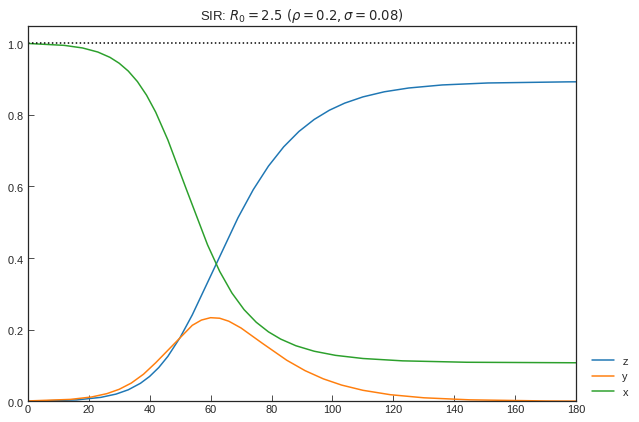

In [58]:
cs.line_plot(
    sir_simulator.non_dim().set_index("t"),
    title=r"SIR: $R_0={0}\ (\rho={1}, \sigma={2})$".format(eg_r0, eg_rho, eg_sigma),
    ylabel="",
    h=1
)

There is an inflection point of y (the number of currentry infected cases per total population). At this point, value of x (the number of susceptible cases per total population) is nearly equal to $\frac{1}{R_0}$.

In [59]:
df = sir_simulator.non_dim()
x_max = df.loc[df["y"].idxmax(), "x"]
(x_max, 1/eg_r0)

(0.39801, 0.4)

### Dimensionalization
Here, we will dimensionalize the data, assuming that start date is the first date of JHU dataset, $\tau=1440$ [min] and total population $N=1,000,000$.

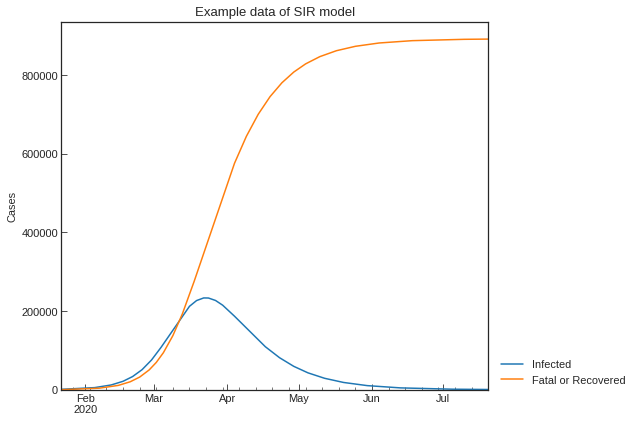

Date  Country Province  Fatal or Recovered  Infected  Susceptible
176 2020-07-16  Example      SIR              891713       673       107615
177 2020-07-17  Example      SIR              891764       635       107601
178 2020-07-18  Example      SIR              891813       599       107588
179 2020-07-19  Example      SIR              891860       565       107575
180 2020-07-20  Example      SIR              891904       533       107563

In [60]:
sir_eg_df = sir_simulator.dim(tau=eg_tau, start_date="22Jan2020")
cs.line_plot(
    sir_eg_df.set_index("Date")[["Infected", "Fatal or Recovered"]],
    "Example data of SIR model",
    h=eg_population, y_integer=True
)
sir_eg_df.tail()

## SIR-D model
Because we are measuring the number of fatal cases and recovered cases separately, we can use two variables ("Recovered" and "Deaths") instead of "Recovered + Deaths" in the mathematical model.

### What is SIR-D model?
* S: Susceptible
* I: Infected
* R: Recovered
* D: Deaths

Model:  
\begin{align*}
\mathrm{S} \overset{\beta  I}{\longrightarrow}\ & \mathrm{I} \overset{\gamma}{\longrightarrow} \mathrm{R}  \\
& \mathrm{I} \overset{\alpha}{\longrightarrow} \mathrm{D}  \\
\end{align*}

$\alpha$: Mortality rate [1/min]  
$\beta$: Effective contact rate [1/min]  
$\gamma$: Recovery rate [1/min]  

Ordinary Differential Equation (ODE):
\begin{align*}
& \frac{\mathrm{d}S}{\mathrm{d}T}= - N^{-1}\beta S I  \\
& \frac{\mathrm{d}I}{\mathrm{d}T}= N^{-1}\beta S I - (\gamma + \alpha) I  \\
& \frac{\mathrm{d}R}{\mathrm{d}T}= \gamma I  \\
& \frac{\mathrm{d}D}{\mathrm{d}T}= \alpha I  \\
\end{align*}

Where $N=S+I+R+D$ is the total population, $T$ is the elapsed time from the start date.

### Non-dimensional SIR-D model
Set $(S, I, R, D) = N \times (x, y, z, w)$ and $(T, \alpha, \beta, \gamma) = (\tau t, \tau^{-1} \kappa, \tau^{-1} \rho, \tau^{-1} \sigma)$.  
This results in the ODE  
\begin{align*}
& \frac{\mathrm{d}x}{\mathrm{d}t}= - \rho x y  \\
& \frac{\mathrm{d}y}{\mathrm{d}t}= \rho x y - (\sigma + \kappa) y  \\
& \frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y  \\
& \frac{\mathrm{d}w}{\mathrm{d}t}= \kappa y  \\
\end{align*}

Where $N$ is the total population and $\tau$ is a coefficient ([min], is an integer to simplify).  

The range of variables and parameters:  
\begin{align*}
& 0 \leq (x, y, z, w, \kappa, \rho, \sigma) \leq 1  \\
\end{align*}
\begin{align*}
& 1\leq \tau \leq 1440  \\
\end{align*}

Reproduction number can be defined as  
\begin{align*}
R_0 = \rho (\sigma + \kappa)^{-1} = \beta (\gamma + \alpha)^{-1}
\end{align*}

### Example of non-dimensional SIR-D model
For example, set $R_0 = 2.5, \kappa=0.005, \rho=0.2$ and initial values $(x_{(0)}, y_{(0)}, z_{(0)}, w_{(0)}) = (0.999, 0.001, 0, 0)$.

In [61]:
eg_r0, eg_kappa, eg_rho = (2.5, 0.005, 0.2)
eg_sigma = eg_rho / eg_r0 - eg_kappa
eg_initials = (0.999, 0.001, 0, 0)
display(Markdown(rf"$\kappa = {eg_kappa},\ \rho = {eg_rho},\ \sigma = {eg_sigma}$."))

$\kappa = 0.005,\ \rho = 0.2,\ \sigma = 0.075$.

In [62]:
sird_param_dict = {
    "kappa": eg_kappa, "rho": eg_rho, "sigma": eg_sigma
}
sird_simulator = cs.ODESimulator(country="Example", province="SIR-D")
sird_simulator.add(
    model=cs.SIRD, step_n=180, population=eg_population,
    param_dict=sird_param_dict,
    y0_dict={"Susceptible": 999_000, "Infected": 1000, "Recovered": 0, "Fatal": 0}
)
sird_simulator.run()
sird_simulator.non_dim().tail()

t         w         y         z         x
176  176  0.055502  0.000711  0.832531  0.111256
177  177  0.055505  0.000671  0.832583  0.111241
178  178  0.055509  0.000634  0.832630  0.111227
179  179  0.055512  0.000598  0.832677  0.111213
180  180  0.055515  0.000565  0.832720  0.111200

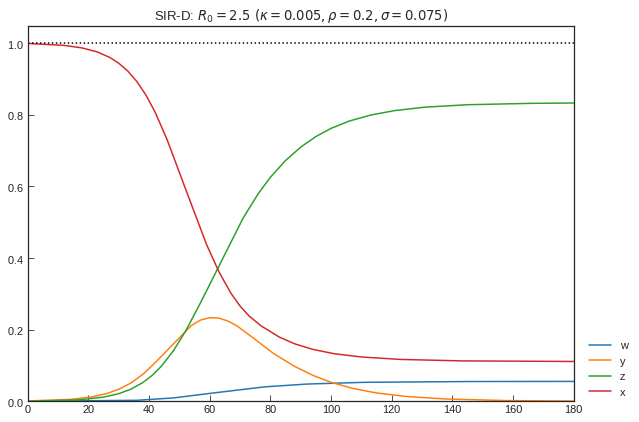

In [63]:
cs.line_plot(
    sird_simulator.non_dim().set_index("t"),
    title=r"SIR-D: $R_0={0}\ (\kappa={1}, \rho={2}, \sigma={3})$".format(eg_r0, eg_kappa, eg_rho, eg_sigma),
    ylabel="",
    h=1
)

There is an inflection point of y (the number of currentry infected cases per total population). At this point, value of x (the number of susceptible cases per total population) is nearly equal to $\frac{1}{R_0}$.

In [64]:
df = sird_simulator.non_dim()
x_max = df.loc[df["y"].idxmax(), "x"]
(x_max, 1/eg_r0)

(0.3978133978133978, 0.4)

### Dimensionalization
Here, we will dimensionalize the data, assuming that start date is the first date of JHU dataset, $\tau=1440$ [min] and total population $N=1,000,000$.

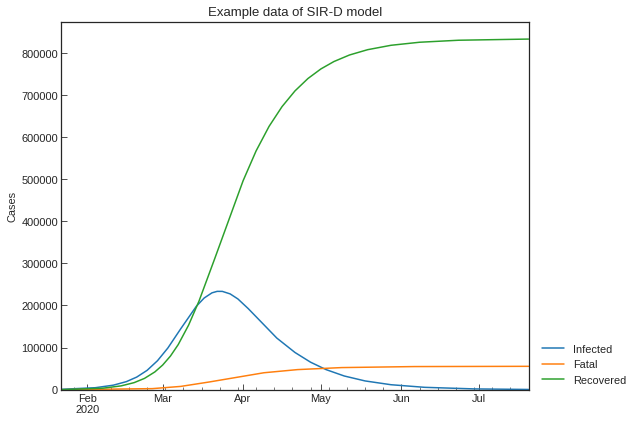

Date  Country Province  Fatal  Infected  Recovered  Susceptible
176 2020-07-16  Example    SIR-D  55502       711     832530       111256
177 2020-07-17  Example    SIR-D  55505       671     832582       111241
178 2020-07-18  Example    SIR-D  55509       634     832631       111227
179 2020-07-19  Example    SIR-D  55512       598     832677       111213
180 2020-07-20  Example    SIR-D  55515       565     832721       111200

In [65]:
sird_eg_df = sird_simulator.dim(tau=eg_tau, start_date="22Jan2020")
cs.line_plot(
    sird_eg_df.set_index("Date")[["Infected", "Fatal", "Recovered"]],
    "Example data of SIR-D model",
    h=eg_population, y_integer=True
)
sird_eg_df.tail()

## SIR-F model
It is reported that some cases died before clinical diagnosis of COVID-19. To consider this issue, "S + I $\to$ Fatal + I" will be added to the model.

### What is SIR-F model?
* S: Susceptible
* S$^\ast$: Confirmed and un-categorized
* I: Confirmed and categorized as I
* R: Recovered
* F: Fatal with confirmation

Measurable variables:  
Confirmed = $I+R+F$  
Recovered = $R$  
Deaths = $F$  

Model:  
\begin{align*}
\mathrm{S} \overset{\beta I}{\longrightarrow} \mathrm{S}^\ast \overset{\alpha_1}{\longrightarrow}\ & \mathrm{F}    \\
\mathrm{S}^\ast \overset{1 - \alpha_1}{\longrightarrow}\ & \mathrm{I} \overset{\gamma}{\longrightarrow} \mathrm{R}    \\
& \mathrm{I} \overset{\alpha_2}{\longrightarrow} \mathrm{F}    \\
\end{align*}

$\alpha_1$: Mortality rate of S$^\ast$ cases [-]  
$\alpha_2$: Mortality rate of I cases [1/min]  
$\beta$: Effective contact rate [1/min]  
$\gamma$: Recovery rate [1/min]  

Note: When $\alpha_1 = 0$, SIR-F model is the same as SIR-D model.

Ordinary Differential Equation (ODE):   
\begin{align*}
& \frac{\mathrm{d}S}{\mathrm{d}T}= - N^{-1}\beta S I  \\
& \frac{\mathrm{d}I}{\mathrm{d}T}= N^{-1}(1 - \alpha_1) \beta S I - (\gamma + \alpha_2) I  \\
& \frac{\mathrm{d}R}{\mathrm{d}T}= \gamma I  \\
& \frac{\mathrm{d}F}{\mathrm{d}T}= N^{-1}\alpha_1 \beta S I + \alpha_2 I  \\
\end{align*}

Where $N=S+I+R+F$ is the total population, $T$ is the elapsed time from the start date.

### Non-dimensional SIR-F model
Set $(S, I, R, F) = N \times (x, y, z, w)$ and $(T, \alpha_1, \alpha_2, \beta, \gamma) = (\tau t, \theta, \tau^{-1} \kappa, \tau^{-1} \rho, \tau^{-1} \sigma)$.  
This results in the ODE  
\begin{align*}
& \frac{\mathrm{d}x}{\mathrm{d}t}= - \rho x y  \\
& \frac{\mathrm{d}y}{\mathrm{d}t}= \rho (1-\theta) x y - (\sigma + \kappa) y  \\
& \frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y  \\
& \frac{\mathrm{d}w}{\mathrm{d}t}= \rho \theta x y + \kappa y  \\
\end{align*}

Where $N$ is the total population and $\tau$ is a coefficient ([min], is an integer to simplify).  

The range of variables and parameters:  
\begin{align*}
& 0 \leq (x, y, z, w, \theta, \kappa, \rho, \sigma) \leq 1  \\
\end{align*}
\begin{align*}
& 1\leq \tau \leq 1440  \\
\end{align*}

Reproduction number can be defined as  
\begin{align*}
R_0 = \rho (1 - \theta) (\sigma + \kappa)^{-1} = \beta (1 - \alpha_1) (\gamma + \alpha_2)^{-1}
\end{align*}

### Example of non-dimensional SIR-F model
For example, set $R_0 = 2.5, \theta=0.002, \kappa=0.005, \rho=0.2$ and initial values $(x_{(0)}, y_{(0)}, z_{(0)}, w_{(0)}) = (0.999, 0.001, 0, 0)$.

In [66]:
eg_r0, eg_theta, eg_kappa, eg_rho = (2.5, 0.002, 0.005, 0.2)
eg_sigma = eg_rho / eg_r0 - eg_kappa
eg_initials = (0.999, 0.001, 0, 0)
display(Markdown(rf"$\theta = {eg_theta},\ \kappa = {eg_kappa},\ \rho = {eg_rho},\ \sigma = {eg_sigma}$."))

$\theta = 0.002,\ \kappa = 0.005,\ \rho = 0.2,\ \sigma = 0.075$.

In [67]:
sirf_param_dict = {
    "theta": eg_theta, "kappa": eg_kappa, "rho": eg_rho, "sigma": eg_sigma
}
sirf_simulator = cs.ODESimulator(country="Example", province="SIR-F")
sirf_simulator.add(
    model=cs.SIRF, step_n=180, population=eg_population,
    param_dict=sirf_param_dict,
    y0_dict={"Susceptible": 999_000, "Infected": 1000, "Recovered": 0, "Fatal": 0}
)
sirf_simulator.run()
sirf_simulator.non_dim().tail()

t         w         y         z         x
176  176  0.057102  0.000724  0.829935  0.112239
177  177  0.057106  0.000684  0.829987  0.112223
178  178  0.057109  0.000646  0.830037  0.112208
179  179  0.057113  0.000610  0.830083  0.112194
180  180  0.057116  0.000576  0.830127  0.112181

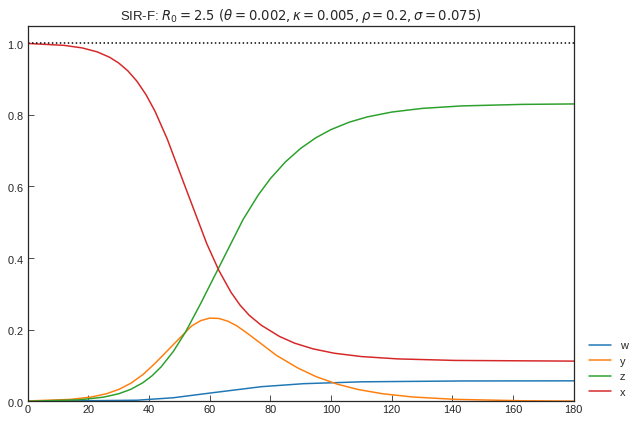

In [68]:
cs.line_plot(
    sirf_simulator.non_dim().set_index("t"),
    title=r"SIR-F: $R_0={0}\ (\theta={1}, \kappa={2}, \rho={3}, \sigma={4})$".format(
        eg_r0, eg_theta, eg_kappa, eg_rho, eg_sigma
    ),
    ylabel="",
    h=1
)

There is an inflection point of y (the number of currentry infected cases per total population). At this point, value of x (the number of susceptible cases per total population) is nearly equal to $\frac{1}{R_0}$.

In [69]:
df = sirf_simulator.non_dim()
x_max = df.loc[df["y"].idxmax(), "x"]
(x_max, 1/eg_r0)

(0.401442, 0.4)

### Dimensionalization
Here, we will dimensionalize the data, assuming that start date is the first date of JHU dataset, $\tau=1440$ [min] and total population $N=1,000,000$.

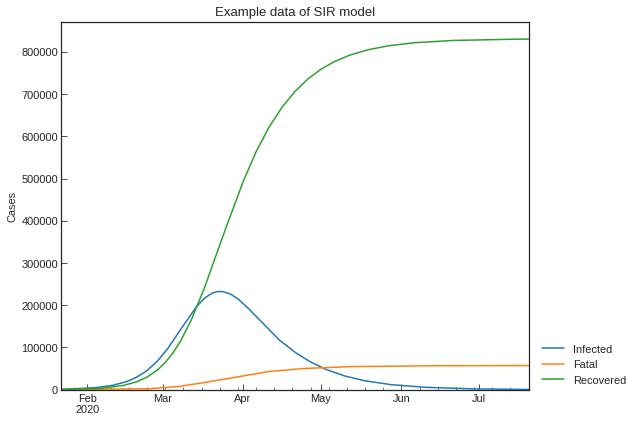

Date  Country Province  Fatal  Infected  Recovered  Susceptible
176 2020-07-16  Example    SIR-F  57102       724     829934       112239
177 2020-07-17  Example    SIR-F  57106       684     829987       112223
178 2020-07-18  Example    SIR-F  57109       646     830036       112208
179 2020-07-19  Example    SIR-F  57113       610     830084       112194
180 2020-07-20  Example    SIR-F  57116       576     830128       112181

In [70]:
sirf_eg_df = sirf_simulator.dim(tau=eg_tau, start_date="22Jan2020")
cs.line_plot(
    sirf_eg_df.set_index("Date")[["Infected", "Fatal", "Recovered"]],
    "Example data of SIR model",
    h=eg_population, y_integer=True
)
sirf_eg_df.tail()

### Hyperparameter optimization
In the previous paragraphs figures, we calculated the number of cases based on hypothesized parameter values. However, we do not know parameter values of the actual data. Here, we will estimate the ($\theta, \kappa, \rho, \sigma$) values of the example data using hyperparameter optimization method by Optuna package. $\tau$ will be fixed as 1440 [min].

In [71]:
estimator = cs.Estimator(
    clean_df=sirf_eg_df, model=cs.SIRF, population=eg_population,
    country="Example", province="SIR-F",
    tau=eg_tau
)
estimator.run()

	Running optimization...
	Finished 148 trials in 0 min 32 sec.


Trajectorie of parameter values in hyperparameter estimation are shown here.

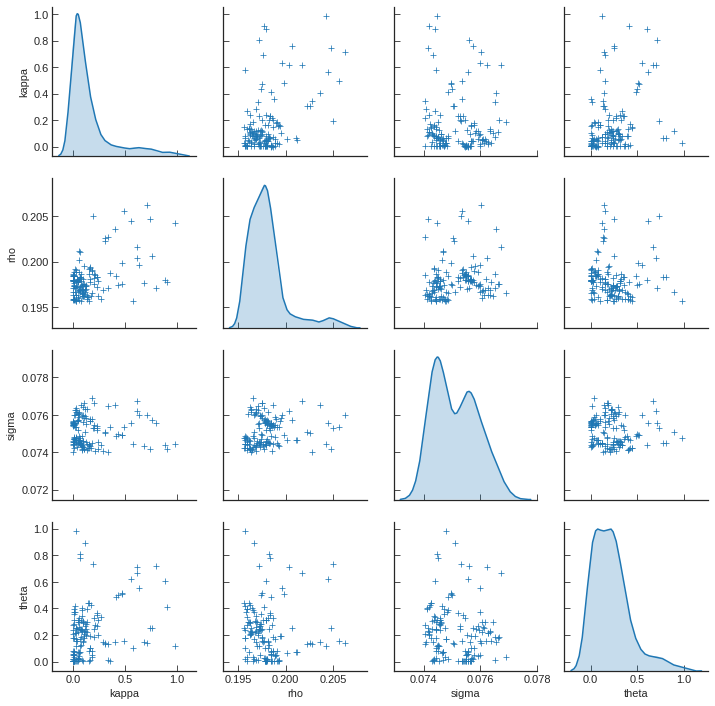

In [72]:
_ = estimator.history()

Estimated parameter values are shown here.

In [73]:
df = estimator.summary(name="SIR-F")
df.loc["Setting"] = pd.Series({**sirf_param_dict, "tau": eg_tau})
df["tau"] = df["tau"].astype(np.int64)
df.fillna("-")

rho     sigma     theta     kappa   tau    Rt alpha1 [-]  \
SIR-F    0.197847  0.075567  0.003667  0.006003  1440  2.42      0.004   
Setting  0.200000  0.075000  0.002000  0.005000  1440     -          -   

        1/alpha2 [day] 1/beta [day] 1/gamma [day]     RMSLE Trials  \
SIR-F              166            5            13  0.609689    148   
Setting              -            -             -         -      -   

              Runtime  
SIR-F    0 min 32 sec  
Setting             -

Note:  
"Score" is Root Mean Squared Log Error (RMSLE) score.
\begin{align*}
& \sqrt{\cfrac{1}{n}\sum_{i=1}^{n}(log_{10}(A_{i} + 1) - log_{10}(P_{i} + 1))^2}
\end{align*}
Where $A$ is observed (actual) values, $P$ is estimated (predicted) values. Variables are $S$ ($i=1$), $I$ ($i=2$), $R$ ($i=3$) and $F$ ($i=n=4$) for SIR-F model. When RMSLE socre is low, hyperparameter estimation is highly accurate.  
Please refer to [What’s the Difference Between RMSE and RMSLE?](https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a)

Comparison of observed values and estimated values is shown here.

Note:  
This figures show the accuracy for each parameter. When "v_observed" and "v_estimated" (v=y, z, w) is overlapping, highly accurate.

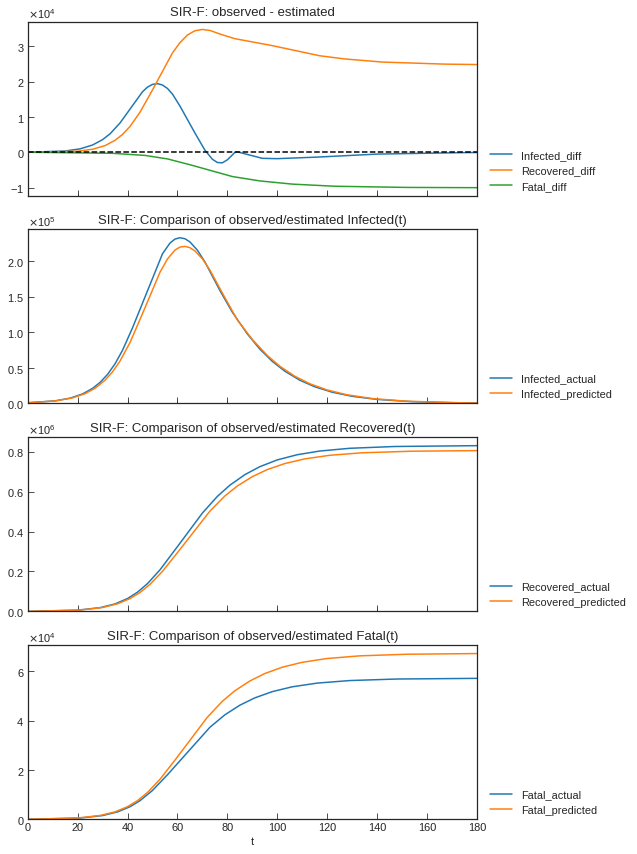

In [74]:
_ = estimator.accuracy()

# SIR-F with exposed/waiting cases<a id="5"></a>
The number of exposed cases in latent period (E) and wating cases for confirmation (W) are un-measurable variables, but key variables as well as S, I, R, F. If E and W are large, outbreak will occur in the near future. Let's replace S $\overset{\beta I}{\longrightarrow}$ S$^\ast$ with S $\overset{\beta_1 (W+I)}{\longrightarrow}$ E $\overset{\beta_2}{\longrightarrow}$ W $\overset{\beta_3}{\longrightarrow}$ S$^\ast$ because W also has infectivity.

Note:  
W and some rules were added to explain COVID-19 dataset, but this is like-SEIR model.  
To study general SEIR-model, please refer to PDF material in [Introduction to SEIR model Models](http://indico.ictp.it/event/7960/session/3/contribution/19/material/slides/).

## What is SEWIR-F model?
* S: Susceptible
* <u>E: Exposed and in latent period (without infectivity)</u>
* <u>W: Waiting cases for confirmation (with infectivity)</u>
* S$^\ast$: Confirmed and un-categorized
* I: Confirmed and categorized as I
* R: Recovered
* F: Fatal with confirmation

Measurable variables:  
Total population - Confirmed = $S+E+W+S^\ast$  
Confirmed = $I+R+F$  
Recovered = $R$  
Deaths = $F$  

Model:  
\begin{align*}
\mathrm{S} \overset{\beta_1 (W+I)}{\longrightarrow} \mathrm{E} \overset{\beta_2}{\longrightarrow} \mathrm{W} \overset{\beta_3}{\longrightarrow} \mathrm{S}^\ast \overset{\alpha_1}{\longrightarrow}\ & \mathrm{F}    \\
\mathrm{S}^\ast \overset{1 - \alpha_1}{\longrightarrow}\ & \mathrm{I} \overset{\gamma}{\longrightarrow} \mathrm{R}    \\
& \mathrm{I} \overset{\alpha_2}{\longrightarrow} \mathrm{F}    \\
\end{align*}

$\alpha_1$: Mortality rate of S$^\ast$ cases [-]  
$\alpha_2$: Mortality rate of I cases [1/min]  
$\beta_1$: <u>Exposure rate (the number of encounter with the virus in a minute)</u> [1/min]  
$\beta_2$: <u>Inverse of latent period</u> [1/min]  
$\beta_3$: <u>Inverse of waiting time for confirmation</u> [1/min]  
$\gamma$: Recovery rate [1/min]  

Ordinary Differential Equation (ODE):   
\begin{align*}
& \frac{\mathrm{d}S}{\mathrm{d}T}= - N^{-1}\beta_1 S (W + I)  \\
& \frac{\mathrm{d}E}{\mathrm{d}T}= N^{-1}\beta_1 S (W + I) - \beta_2 E  \\
& \frac{\mathrm{d}W}{\mathrm{d}T}= \beta_2 E - \beta_3 W  \\
& \frac{\mathrm{d}I}{\mathrm{d}T}= (1 - \alpha_1)\beta_3 W - (\gamma + \alpha_2) I  \\
& \frac{\mathrm{d}R}{\mathrm{d}T}= \gamma I  \\
& \frac{\mathrm{d}F}{\mathrm{d}T}= \alpha_1 \beta_3 W + \alpha_2 I  \\
\end{align*}

Where $N=S+E+W+I+R+F$ is the total population, $T$ is the elapsed time from the start date.

## Non-dimensional SEWIR-F model
Set $(S, E, W, I, R, F) = N \times (x_1, x_2, x_3, y, z, w)$, $(T, \alpha_1) = (\tau t, \theta)$ and $(\alpha_2, \beta_i, \gamma) = \tau^{-1} \times (\kappa, \rho_i, \sigma)$.  
This results in the ODE  
\begin{align*}
& \frac{\mathrm{d}x_1}{\mathrm{d}t}= - \rho_1 x_1 (x_3 + y)  \\
& \frac{\mathrm{d}x_2}{\mathrm{d}t}= \rho_1 x_1 (x_3 + y) - \rho_2 x_2  \\
& \frac{\mathrm{d}x_3}{\mathrm{d}t}= \rho_2 x_2 - \rho_3 x_3  \\
& \frac{\mathrm{d}y}{\mathrm{d}t}= (1-\theta) \rho_3 x_3 - (\sigma + \kappa) y  \\
& \frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y  \\
& \frac{\mathrm{d}w}{\mathrm{d}t}= \theta \rho_3 x_3 + \kappa y  \\
\end{align*}

Where $N$ is the total population and $\tau$ is a coefficient ([min], is an integer to simplify).  

The range of variables and parameters:  
\begin{align*}
0 < (x_i, y, z, w, \theta, \kappa, \rho_i, \sigma) < 1\ \mathrm{for}\ i = 1, 2, 3
\end{align*}
\begin{align*}
1 \leq \tau \leq 1440
\end{align*}

Reproduction number can be defined as  
\begin{align*}
R_0 = \rho_1 (1-\theta) (\sigma + \kappa)^{-1}
\end{align*}

## Calculate $\rho_2$ and $\rho_3$
To estimate $\rho_2 = \tau \beta_2$ and $\rho_3 = \tau \beta_3$ of COVID-19, we first calculate median value of latent period $\overline{L_{E}}$ and waiting time for confirmation $\overline{L_{W}}$ using linelist. We assume that patients start to have infectivity from onset dates. This means latent period is equal to incubation period.

$\beta_2$: Inverse of latent period [1/min]  
$\beta_3$: Inverse of waiting time for confirmation [1/min]

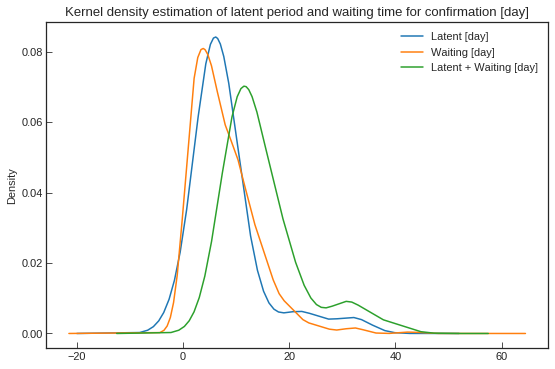

count       mean       std  min   25%   50%   75%  \
Latent [day]             83.0   8.180723  6.786185 -2.0   4.0   6.0   9.0   
Waiting [day]           563.0   7.682060  5.890473  0.0   3.0   6.0  11.0   
Latent + Waiting [day]   83.0  14.819277  7.305435  5.0  10.0  13.0  17.5   

                         max  
Latent [day]            34.0  
Waiting [day]           43.0  
Latent + Waiting [day]  40.0

In [75]:
cols = ["Latent [day]", "Waiting [day]", "Latent + Waiting [day]"]
period_df[cols].plot.kde()
plt.title("Kernel density estimation of latent period and waiting time for confirmation [day]")
plt.show()
period_df[cols].describe().T

In [76]:
latent_period = period_df["Latent [min]"].median()
waiting_time = period_df["Waiting [min]"].median()
latent_waiting_day = period_df["Latent + Waiting [day]"].median()

In [77]:
df = estimator.summary(name="SIRF")
tau = df.loc[df.index[0], "tau"]
eg_rho2, eg_rho3 = tau / latent_period, tau / waiting_time
(eg_rho2, eg_rho3)

(0.16666666666666663, 0.16666666666666663)

### Example of non-dimensional SEWIR-F model
For example, set $\theta=0.002, \kappa=0.005, \rho_1=0.2, \sigma=0.08$ and initial values $(x_{1(0)}, x_{2(0)}, x_{3(0)}, y_{(0)}, z_{(0)}, w_{(0)}) = (0.994, 0.003, 0.002, 0.001, 0, 0)$.

In [78]:
eg_theta, eg_kappa, eg_rho1, eg_sigma = (0.002, 0.005, 0.2, 0.08)

In [79]:
sewirf_param_dict = {
    "theta": eg_theta, "kappa": eg_kappa,
    "rho1": eg_rho1, "rho2": eg_rho2, "rho3": eg_rho3, "sigma": eg_sigma
}
sewirf_simulator = cs.ODESimulator(country="Example", province="SEWIR-F")
sewirf_simulator.add(
    model=cs.SEWIRF, step_n=180, population=eg_population,
    param_dict=sewirf_param_dict,
    y0_dict={"Susceptible": 994_000, "Exposed": 3000, "Waiting": 0.002,
        "Infected": 1000, "Recovered": 0, "Fatal": 0
    }
)
sewirf_simulator.run()
sewirf_simulator.non_dim().tail()

t        x2         w         y         z        x1        x3
176  176  0.000113  0.058615  0.001566  0.906935  0.032583  0.000187
177  177  0.000106  0.058623  0.001468  0.907055  0.032572  0.000175
178  178  0.000099  0.058630  0.001375  0.907169  0.032562  0.000164
179  179  0.000093  0.058637  0.001289  0.907276  0.032552  0.000153
180  180  0.000087  0.058643  0.001207  0.907375  0.032543  0.000144

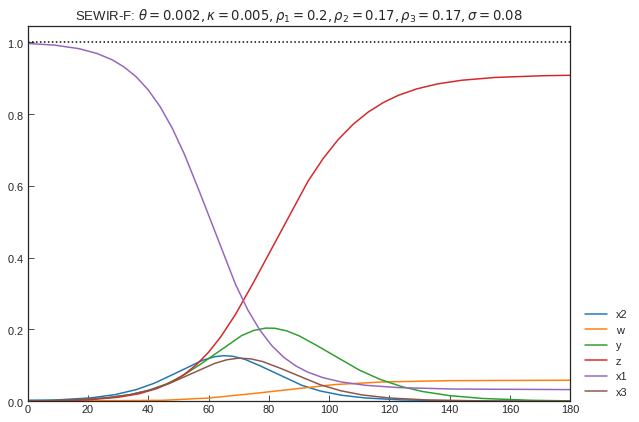

In [80]:
cs.line_plot(
    sewirf_simulator.non_dim().set_index("t"),
    title=r"SEWIR-F: $\theta={0}, \kappa={1}, \rho_1={2}, \rho_2={3}, \rho_3={4}, \sigma={5}$".format(
        eg_theta, eg_kappa, eg_rho1, round(eg_rho2, 2), round(eg_rho3, 2), eg_sigma
    ),
    ylabel="",
    h=1
)

### Dimensionalization
Here, we will dimensionalize the data, assuming that start date is the first date of JHU dataset, $\tau=1440$ [min] and total population $N=1,000,000$.

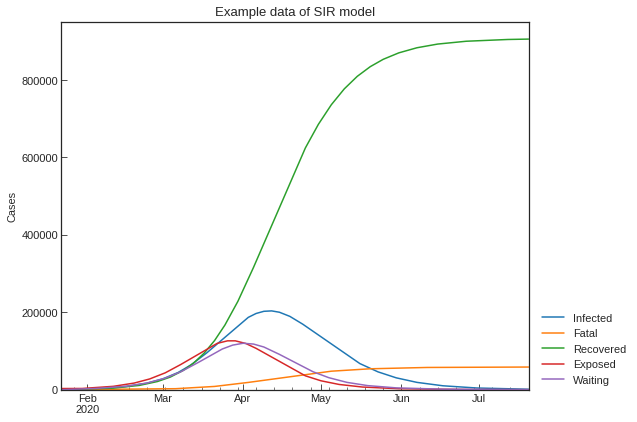

Date  Country Province  Exposed  Fatal  Infected  Recovered  \
176 2020-07-16  Example  SEWIR-F      113  58498      1563     905120   
177 2020-07-17  Example  SEWIR-F      106  58506      1465     905241   
178 2020-07-18  Example  SEWIR-F       99  58513      1372     905355   
179 2020-07-19  Example  SEWIR-F       93  58520      1286     905461   
180 2020-07-20  Example  SEWIR-F       87  58526      1205     905561   

     Susceptible  Waiting  
176        32518      187  
177        32507      175  
178        32497      164  
179        32487      153  
180        32478      144

In [81]:
sewirf_eg_df = sewirf_simulator.dim(tau=eg_tau, start_date="22Jan2020")
cs.line_plot(
    sewirf_eg_df.set_index("Date")[["Infected", "Fatal", "Recovered", "Exposed", "Waiting"]],
    "Example data of SIR model",
    h=eg_population, y_integer=True
)
sewirf_eg_df.tail()

# Factors of model parameters<a id="6"></a>
To figure out what to do for minimizing the damage, we will perform scenario analysis in the next part. In this section, we will define the control factors of the SIR-F parameters.

Comment:  
For accurate SEWIR-F prediction, we need to calculate $\rho_1$ and $\rho_2$ with linelist (case reports) of each country. However, it is difficult to get enough data for all countries and we will use SIR-F model as the main model in scenario analysis part.

## Control factors of effective contact rate $\beta_1$
Please reconsider S $\overset{\beta_1 (W+I)}{\longrightarrow}$ E formula. Susceptible persons may contact with waiting/confirmed patients, and susceptible persons will be infected with COVID-19. The formura can be replaced with  
\begin{alignat}{1}
{\mathrm{S}}_{\mathrm{q}} & \overset{g_{s}}{\Longleftrightarrow} {\mathrm{S}}_{\mathrm{g}} \overset{f_1}
 {\longrightarrow} \ & \mathrm{E}^\ast \overset{e^{-h_2}}{\longrightarrow} \mathrm{E}   \\
& & \mathrm{E}^\ast \overset{1-e^{-h_2}}{\longrightarrow} \mathrm{R}^\ast  \\
\mathrm{W}_\mathrm{q} & \overset{g_w}{\Longleftrightarrow} \mathrm{W}_{\mathrm{g}}  \\
\mathrm{I}_\mathrm{q} & \overset{g_i}{\Longleftrightarrow} \mathrm{I}_{\mathrm{g}}  \\
\mathrm{I}_\mathrm{q} & \overset{q}{\longrightarrow} \mathrm{I}_{\hat{\mathrm{q}}}  \\
\end{alignat}

$\Longleftrightarrow$ (as substitute for $\longrightarrow$ with $\longleftarrow$) means that right side can be return to the left side.  
S$_\mathrm{q}$: Susceptible persons with self-quaranting <!--Susceptible in the strict sense-->  
S$_\mathrm{g}$: Susceptible persons with family members or friends etc.  
W$_\mathrm{q}$: Waiting patients with self-quaranting  
W$_\mathrm{g}$: Waiting patients with family members or friends etc.  
I$_\mathrm{q}$: Confimered and un-recovered patients with self-quaranting  
I$_\mathrm{g}$: Confimered and un-recovered patients with family members or friends etc.  
I$_\hat{\mathrm{q}}$: Confimered and un-recovered patients who was hospitalized  
E$^\ast$: Just after being exposed to the virus  
R$^\ast$: Being exposed to the virus, fighted with the virus, recovered and immuned without confirmation  

$f_1 = v(W_{\mathrm{g}} + I_{\mathrm{g}})(1-m)^2(1-w_e)^{w_n}e^{-h_1}sc$ [-] 

Control factors:  
$g_s$: The number of days in <u>a week</u> susceptible persons go out [day]  
$g_w$: The number of days in <u>a week</u> waiting but un-quarantined persons go out [day]  
$g_i$: The number of days in <u>a week</u> currently infected (confirmed) but un-quarantined persons go out [day]  
$q$: Quarantine rate of currently infected (confirmed) patients [-]  
$v$: Probability of virus existance in a droplet [-]  
$m$: Rate of persons wearing masks effectively (depends logistically on supply of masks) [-]  
$w_e$: Virus reduction effect of washing hands [-]  
$w_n$: The number of times people washes their hands before touching their own faces after go out [-]  
$h_1$: Health condition (active rate of cellular immunity factors) of susceptible and contacted persons [-]  
$h_2$: Health condition (active rate of humoral immunity factors) of susceptible and contacted persons [-]  
$c$: The number of contacts between susceptible persons and patients while on the go in a minute (depends on population density) [1/min]  
$\delta$:The product of unknown real factors [-]  

The parameter in the math model:  
$\beta_1 = \cfrac{1}{49}[g_s \{g_w + g_i (1-q) \} v (1-m)^2 (1-w_e)^{w_n} e^{-(h_{1}+h_{2})} c \delta]$ [1/min]

In [82]:
# Value of beta before actions are taken
beta_before = eg_rho / eg_tau
beta_before

0.0001388888888888889

**As a example, we will predict the impact of lockdown. The number of days in a week susceptible persons go out, $g_s$, will be minimized.**

### $g_s$ value before actions are taken
$g_s$: The number of days in <u>a week</u>, susceptible persons go out [day]  

We can calculate weighted average of days with age composion of population. Population pyramid in the entire world (global data) will be used.

In [83]:
eg_out_df = go_out("Global")
eg_out_df

Age_first  Age_last     Period_of_life  School  Office  Others   Portion
0           0         2            nursery       3       0       0  0.052210
1           3         5     nursery school       4       0       1  0.051864
2           6        10  elementary school       5       0       1  0.084689
3          11        13      middle school       5       0       1  0.049386
4          14        18        high school       6       0       1  0.079324
5          19        25    university/work       3       3       1  0.107659
6          26        35               work       0       6       1  0.152774
7          36        45               work       0       5       1  0.131630
8          46        55               work       0       5       1  0.116396
9          56        65               work       0       5       1  0.088096
10         66        75            retired       0       0       4  0.055083
11         76        85            retired       0       0       3  0.024309
12         86        95            retired       0       0       2  0.006579

$g_s$ value is

In [84]:
gs_before = (eg_out_df[["School", "Office", "Others"]].sum(axis=1) * eg_out_df["Portion"]).sum()
gs_before

5.921853248424339

### $g_s$ value AFTER actions are taken
We will assume the following situation (lockdown) here.
* All schools are closed
* offices are closed and 50% of people works remotely.
* People will go out one day for other reasons instead of going to school/office.

In [85]:
df = eg_out_df.copy()
df.loc[df["School"] + df["Office"] > 0, "Others"] += 1
df["School"] = 0
df["Office"] *= 0.5
eg_out_df_after = df.copy()
eg_out_df_after

Age_first  Age_last     Period_of_life  School  Office  Others   Portion
0           0         2            nursery       0     0.0       1  0.052210
1           3         5     nursery school       0     0.0       2  0.051864
2           6        10  elementary school       0     0.0       2  0.084689
3          11        13      middle school       0     0.0       2  0.049386
4          14        18        high school       0     0.0       2  0.079324
5          19        25    university/work       0     1.5       2  0.107659
6          26        35               work       0     3.0       2  0.152774
7          36        45               work       0     2.5       2  0.131630
8          46        55               work       0     2.5       2  0.116396
9          56        65               work       0     2.5       2  0.088096
10         66        75            retired       0     0.0       4  0.055083
11         76        85            retired       0     0.0       3  0.024309
12         86        95            retired       0     0.0       2  0.006579

In [86]:
df = eg_out_df_after.copy()
gs_after = (df[["School", "Office", "Others"]].sum(axis=1) * df["Portion"]).sum()
gs_after

3.5423821085758442

## Impact of actions on $\beta$
In SIR-F model $g_s$ is a control factor of $\beta$.  
Actions taken at 15th day:  
All schools and offices will be closed.  

In [87]:
beta_after = beta_before * (gs_after / gs_before)
beta_after / beta_before

0.5981880941609597

## Predict the number of cases: with actions from 15th day
There is a delay between the time point of starting actions and that of appearing the effect. Because $I$ is the main variable, the length of delay can be estimated as sum of latent period and waiting time for confirmation. This value [day] was calculated in "SIR-F with exposed/waiting cases" section.

In [88]:
latent_waiting_day

13.0

In [89]:
param_dict = sirf_param_dict.copy()
lock_param_dict = param_dict.copy()
lock_param_dict["rho"] = param_dict["rho"] * beta_after / beta_before
df = pd.DataFrame.from_dict(
    {"No actions": param_dict, "Lockdown": lock_param_dict},
    orient="index"
)
df = df.loc[:, ["theta", "kappa", "rho", "sigma"]]
df["R0"] = df.apply(lambda x: cs.SIRF(eg_population, **x.to_dict()).calc_r0(), axis=1)
df["tau"] = eg_tau
df

theta  kappa       rho  sigma    R0   tau
No actions  0.002  0.005  0.200000  0.075  2.50  1440
Lockdown    0.002  0.005  0.119638  0.075  1.49  1440

No actions:

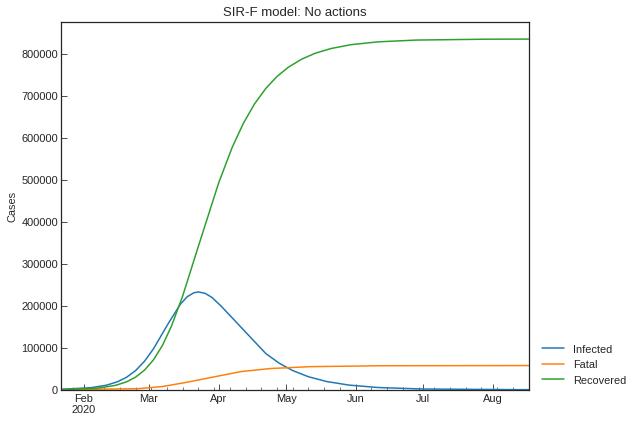

In [90]:
simulator = cs.ODESimulator(country="Example", province="No actions")
simulator.add(
    model=cs.SIRF,
    step_n=15,
    population=eg_population,
    param_dict=param_dict,
    y0_dict={"Susceptible": 999_000, "Infected": 1000, "Recovered": 0, "Fatal": 0}
)
simulator.add(
    model=cs.SIRF,
    step_n=int(latent_waiting_day),
    population=eg_population,
    param_dict=param_dict
)
simulator.add(
    model=cs.SIRF,
    step_n=180,
    population=eg_population,
    param_dict=param_dict
)
simulator.run()
pred_df_no = simulator.dim(tau=eg_tau, start_date="22Jan2020").set_index("Date")
cs.line_plot(
    pred_df_no[["Infected", "Fatal", "Recovered"]],
    "SIR-F model: No actions", h=eg_population, y_integer=True
)

With lockdown from 15th day:

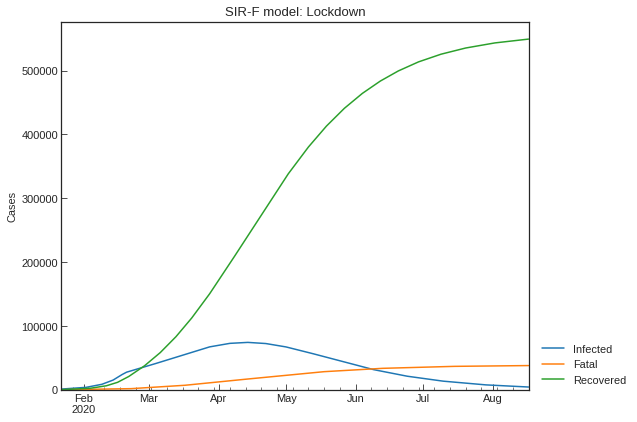

In [91]:
simulator = cs.ODESimulator(country="Example", province="Lockdown")
simulator.add(
    model=cs.SIRF,
    step_n=15,
    population=eg_population,
    param_dict=param_dict,
    y0_dict={"Susceptible": 999_000, "Infected": 1000, "Recovered": 0, "Fatal": 0}
)
simulator.add(
    model=cs.SIRF,
    step_n=int(latent_waiting_day),
    population=eg_population,
    param_dict=param_dict
)
simulator.add(
    model=cs.SIRF,
    step_n=180,
    population=eg_population,
    param_dict=lock_param_dict
)
simulator.run()
pred_df_lock = simulator.dim(tau=eg_tau, start_date="22Jan2020").set_index("Date")
cs.line_plot(
    pred_df_lock[["Infected", "Fatal", "Recovered"]],
    "SIR-F model: Lockdown", h=eg_population, y_integer=True
)

In [92]:
_last_date = pred_df_no.index[-1].strftime("%d%b%Y")
_dict = {
    "No actions": {
        "max(Infected)": pred_df_no["Infected"].max(),
        "argmax(Infected)": pred_df_no["Infected"].idxmax(),
        f"Infected on {_last_date}": pred_df_no["Infected"][-1],
    },
    "With lockdown": {
        "max(Infected)": pred_df_lock["Infected"].max(),
        "argmax(Infected)": pred_df_lock["Infected"].idxmax(),
        f"Infected on {_last_date}": pred_df_lock["Infected"][-1],
    }   
}
pd.DataFrame.from_dict(_dict, orient="index")

max(Infected) argmax(Infected)  Infected on 17Aug2020
No actions            232807       2020-03-23                    104
With lockdown          74113       2020-04-14                   4197

The actions result in:  
* reduction of max value of Infected,
* delay of peak point (argmax) of Infected, and
* extention of period with COVID-19.

## Control factors of recovery rate $\gamma$ and mortality rate $\alpha_2$
Here, let's reconsider I $\overset{\gamma}{\longrightarrow}$ R and I $\overset{\alpha_2}{\longrightarrow}$ F.  
Because balance of immunity (+effect of treatments) and virulence determines whether patients can recover or not, the formulas can be replaced with  

\begin{align*}
& \mathrm{I} \overset{\bar{h}}{\longrightarrow} \mathrm{I}^\star \overset{\bar{s}}{\longrightarrow} \mathrm{F}^\star \overset{L^{-1}}{\longrightarrow} \mathrm{F}    \\
& \mathrm{I} \overset{f_2}{\longrightarrow} \mathrm{R}^\star \overset{l^{-1}}{\longrightarrow} \mathrm{R}    \\
\end{align*}

I$^\star$: Confirmed cases whose immune systems did not overcome virus multiplication, and <u>without</u> severe events  
F$^\star$: Confirmed cases whose immune systems did not overcome virus multiplication, and <u>with</u> severe events  
R$^\star$: Confirmed cases whose immune systems overcame virus multiplication or comfirmed cases whose severe events can be stopped

$f_2 = 1 - \bar{h}\ \bar{s}$  

$\bar{h}$: Rate of I whose immune systems does NOT overcame virus multiplication [-]  
$\bar{s}$: Rate of I$^\star$ who have severe events, including respiratory failure  [-]  
$L_i$: Inverse of F$^\star$'s mortality rate for people $i$ years old [min]  
$l_i$: Inverse of R$^\star$'s mortality rate for people $i$ years old [min]  
$P_i$: The number of people $i$ years old [-]  
$N$: Total population  

\begin{align*}
& \alpha_2 = \cfrac{\bar{h}\ \bar{s}}{N} \sum_{n=0}^{\infty}\cfrac{P_{i}}{L_i} \\
& \gamma = \cfrac{1 - \bar{h}\ \bar{s}}{N} \sum_{n=0}^{\infty}\cfrac{P_{i}}{l_i} \\
\end{align*}

## $\bar{h}$ and $\bar{s}$ value before actions are taken
We assume that $\bar{h}=0.5$ and $\bar{s}=0.5$.  
**(Using population distribution data and case reports, $\bar{h}\ \bar{s}$ and $1 - \bar{h}\ \bar{s}$ can be calculated.)**

In [93]:
gamma_before = param_dict["sigma"] / eg_tau
alpha2_before = param_dict["kappa"] / eg_tau
(gamma_before, alpha2_before)

(5.208333333333333e-05, 3.4722222222222224e-06)

In [94]:
h_bar_before, s_bar_before = 0.5, 0.5

## $\bar{h}$ and $\bar{s}$ value AFTER actions are taken
Assumtions of new medicines:  
"Protease inhibitor" inhibits virus multiplication. This will reduce $\bar{h}$. We assume that $\bar{h}$ will be 10% of $\bar{h}_{before}$.

In [95]:
h_bar_after = h_bar_before * 0.1
s_bar_after = s_bar_before
(h_bar_after, s_bar_after)

(0.05, 0.5)

## Impact on $\gamma$ and $\alpha_2$
Actions to take:  
New Protein inhibitor medicine was introduced.

In [96]:
gamma_after = gamma_before * (1 - h_bar_after * s_bar_after) / (1 - h_bar_before * s_bar_before)
gamma_after

6.770833333333333e-05

In [97]:
alpha2_after = alpha2_before * (h_bar_after * s_bar_after) / (h_bar_before * s_bar_before)
alpha2_after

3.4722222222222224e-07

## Predict the number of case: with new medicines from 15th day

In [98]:
param_dict = sirf_param_dict.copy()
med_param_dict = param_dict.copy()
med_param_dict["sigma"] = param_dict["sigma"] * gamma_after / gamma_before
med_param_dict["kappa"] = param_dict["kappa"] * alpha2_after / alpha2_before
df = pd.DataFrame.from_dict(
    {"No actions": param_dict, "Medicine": med_param_dict},
    orient="index"
)
df = df.loc[:, ["theta", "kappa", "rho", "sigma"]]
df["R0"] = df.apply(lambda x: cs.SIRF(eg_population, **x.to_dict()).calc_r0(), axis=1)
df["tau"] = eg_tau
df

theta   kappa  rho   sigma    R0   tau
No actions  0.002  0.0050  0.2  0.0750  2.50  1440
Medicine    0.002  0.0005  0.2  0.0975  2.04  1440

No actions:

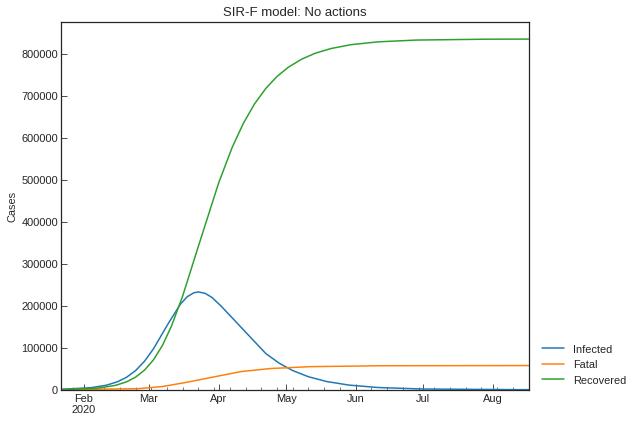

In [99]:
simulator = cs.ODESimulator(country="Example", province="No actions")
simulator.add(
    model=cs.SIRF,
    step_n=15,
    population=eg_population,
    param_dict=param_dict,
    y0_dict={"Susceptible": 999_000, "Infected": 1000, "Recovered": 0, "Fatal": 0}
)
simulator.add(
    model=cs.SIRF,
    step_n=int(latent_waiting_day),
    population=eg_population,
    param_dict=param_dict
)
simulator.add(
    model=cs.SIRF,
    step_n=180,
    population=eg_population,
    param_dict=param_dict
)
simulator.run()
pred_df_no = simulator.dim(tau=eg_tau, start_date="22Jan2020").set_index("Date")
cs.line_plot(
    pred_df_no[["Infected", "Fatal", "Recovered"]],
    "SIR-F model: No actions", h=eg_population, y_integer=True
)

With new medicines:

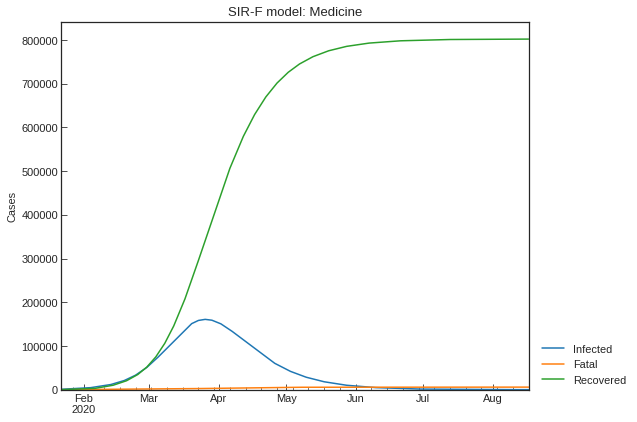

In [100]:
simulator = cs.ODESimulator(country="Example", province="Medicine")
simulator.add(
    model=cs.SIRF,
    step_n=15,
    population=eg_population,
    param_dict=param_dict,
    y0_dict={"Susceptible": 999_000, "Infected": 1000, "Recovered": 0, "Fatal": 0}
)
simulator.add(
    model=cs.SIRF,
    step_n=int(latent_waiting_day) + 180,
    population=eg_population,
    param_dict=med_param_dict
)
simulator.run()
pred_df_med = simulator.dim(tau=eg_tau, start_date="22Jan2020").set_index("Date")
cs.line_plot(
    pred_df_med[["Infected", "Fatal", "Recovered"]],
    "SIR-F model: Medicine", h=eg_population, y_integer=True
)

In [101]:
_last_date = pred_df_no.index[-1].strftime("%d%b%Y")
_dict = {
    "No actions": {
        "max(Infected)": pred_df_no["Infected"].max(),
        "argmax(Infected)": pred_df_no["Infected"].idxmax(),
        f"Infected on {_last_date}": pred_df_no["Infected"][-1],
        f"Fatal on {_last_date}": pred_df_no["Fatal"][-1],
    },
    "Lockdown": {
        "max(Infected)": pred_df_lock["Infected"].max(),
        "argmax(Infected)": pred_df_lock["Infected"].idxmax(),
        f"Infected on {_last_date}": pred_df_lock["Infected"][-1],
        f"Fatal on {_last_date}": pred_df_lock["Fatal"][-1],
    },
    "Medicine": {
        "max(Infected)": pred_df_med["Infected"].max(),
        "argmax(Infected)": pred_df_med["Infected"].idxmax(),
        f"Infected on {_last_date}": pred_df_med["Infected"][-1],
        f"Fatal on {_last_date}": pred_df_med["Fatal"][-1],
    }
}
pd.DataFrame.from_dict(_dict, orient="index")

max(Infected) argmax(Infected)  Infected on 17Aug2020  \
No actions         232807       2020-03-23                    104   
Lockdown            74113       2020-04-14                   4197   
Medicine           160879       2020-03-26                     83   

            Fatal on 17Aug2020  
No actions               57457  
Lockdown                 37796  
Medicine                  5919

New medicines result in:  
* reduction of max value of Infected,
* reduction of Fatal, and
* shortened period with COVID-19.

## If 1,000/day are vaccinated (SIR-FV model) from 15th day
We will predict the numbers of cases in the assumption that 10,000 persons will be vacctinated in one day until there are no susceptible people.  

\begin{align*}
& \frac{\mathrm{d}x}{\mathrm{d}t}= - \rho x y - \omega  \\
& \frac{\mathrm{d}y}{\mathrm{d}t}= \rho (1-\theta) x y - (\sigma + \kappa) y  \\
& \frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y  \\
& \frac{\mathrm{d}w}{\mathrm{d}t}= \rho \theta x y + \kappa y  \\
\end{align*}

Where $\omega_{(x>0)}=\frac{1,000}{N}$ and $N$ is the total population.

Reproduction number can be defined as  
\begin{align*}
R_0 = \rho (1 - \theta) (\sigma + \kappa)^{-1}
\end{align*}

In [102]:
print(f"Total population is {eg_population:,}.")

Total population is 1,000,000.


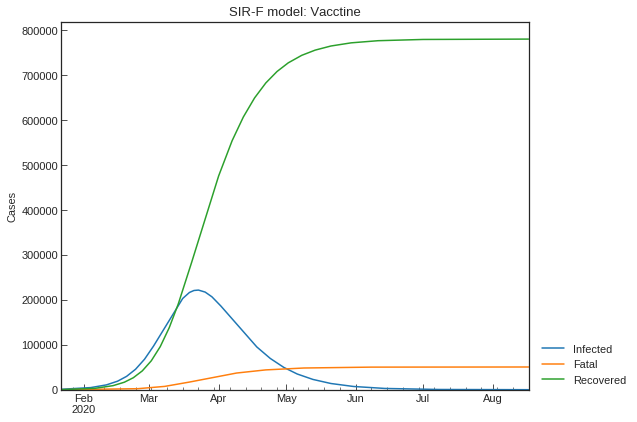

In [103]:
vac_param_dict = param_dict.copy()
vac_param_dict["omega"] = 1_000 / eg_population

simulator = cs.ODESimulator(country="Example", province="Vacctine")
simulator.add(
    model=cs.SIRF,
    step_n=15,
    population=eg_population,
    param_dict=param_dict,
    y0_dict={"Susceptible": 999_000, "Infected": 1000, "Recovered": 0, "Fatal": 0}
)
simulator.add(
    model=cs.SIRF,
    step_n=int(latent_waiting_day),
    population=eg_population,
    param_dict=param_dict
)
simulator.add(
    model=cs.SIRFV,
    step_n=180,
    population=eg_population,
    param_dict=vac_param_dict,
    y0_dict={"Vaccinated": 0}
)
simulator.run()
pred_df_vac = simulator.dim(tau=eg_tau, start_date="22Jan2020").set_index("Date")
cs.line_plot(
    pred_df_vac[["Infected", "Fatal", "Recovered"]],
    "SIR-F model: Vacctine", h=eg_population, y_integer=True
)

In [104]:
_last_date = pred_df_no.index[-1].strftime("%d%b%Y")
_dict = {
    "No actions": {
        "max(Infected)": pred_df_no["Infected"].max(),
        "argmax(Infected)": pred_df_no["Infected"].idxmax(),
        f"Infected on {_last_date}": pred_df_no["Infected"][-1],
        f"Fatal on {_last_date}": pred_df_no["Fatal"][-1],
    },
    "Lockdown": {
        "max(Infected)": pred_df_lock["Infected"].max(),
        "argmax(Infected)": pred_df_lock["Infected"].idxmax(),
        f"Infected on {_last_date}": pred_df_lock["Infected"][-1],
        f"Fatal on {_last_date}": pred_df_lock["Fatal"][-1],
    },
    "Medicine": {
        "max(Infected)": pred_df_med["Infected"].max(),
        "argmax(Infected)": pred_df_med["Infected"].idxmax(),
        f"Infected on {_last_date}": pred_df_med["Infected"][-1],
        f"Fatal on {_last_date}": pred_df_med["Fatal"][-1],
    },
    "Vacctine": {
        "max(Infected)": pred_df_vac["Infected"].max(),
        "argmax(Infected)": pred_df_vac["Infected"].idxmax(),
        f"Infected on {_last_date}": pred_df_vac["Infected"][-1],
        f"Fatal on {_last_date}": pred_df_vac["Fatal"][-1],
    }
}
pd.DataFrame.from_dict(_dict, orient="index")

max(Infected) argmax(Infected)  Infected on 17Aug2020  \
No actions         232807       2020-03-23                    104   
Lockdown            74113       2020-04-14                   4197   
Medicine           160879       2020-03-26                     83   
Vacctine           221598       2020-03-23                     22   

            Fatal on 17Aug2020  
No actions               57457  
Lockdown                 37796  
Medicine                  5919  
Vacctine                 50508

Vacctines result in:  
* reduction of max value of Infected,
* reduction of Fatal, and
* shortened period with COVID-19.

# S-R trend analysis<a id="10"></a>
In the previous section, we found that parameter values can be changed by actions. To predict the future, we need to recognize the parameter change from the actual records. Here, trend analysis method will be introduced.

## Example datasets
With the same initial values $(x_{(0)}, y_{(0)}, z_{(0)}, w_{(0)})=(0.999, 0.001, 0, 0)$, we will create five SIR-F example datasets.
* Example 1: $(\theta, \kappa, \rho, \sigma) = (0.0002, 0.005, 0.20, 0.075)$
* Example 2: $(\theta, \kappa, \rho, \sigma) = (0.0002, 0.005, \underline{0.40}, 0.075)$, spread quickly
* Example 3: $(\theta, \kappa, \rho, \sigma) = (0.0002, 0.005, \underline{0.15}, 0.075)$, spread slowly
* Example 4: $(\theta, \kappa, \rho, \sigma) = (0.0002, \underline{0.003}, 0.20, \underline{0.150})$, improved heakthcare system
* Example 5: $(\theta, \kappa, \rho, \sigma) = (\underline{0.0000}, 0.005, 0.20, 0.075)$, as the same as SIR-D model

Values are dimensionalized with total population $N=1,000,000$ in the example datasets.

In [105]:
df = pd.DataFrame()
eg_step_n = 200
eg_param_dict = {
    "1": {"theta": 0.0002, "kappa": 0.005, "rho": 0.20, "sigma": 0.075},
    "2": {"theta": 0.0002, "kappa": 0.005, "rho": 0.40, "sigma": 0.075},
    "3": {"theta": 0.0002, "kappa": 0.005, "rho": 0.15, "sigma": 0.075},
    "4": {"theta": 0.0002, "kappa": 0.003, "rho": 0.20, "sigma": 0.150},
    "5": {"theta": 0.0000, "kappa": 0.005, "rho": 0.20, "sigma": 0.075},
}

for (num, _dict) in eg_param_dict.items():
    simulator = cs.ODESimulator(country=f"Example {num}")
    simulator.add(
        model=cs.SIRF,
        step_n=eg_step_n,
        population=eg_population,
        param_dict=_dict,
        y0_dict={"Susceptible": 999_000, "Infected": 1000, "Recovered": 0, "Fatal": 0}
    )
    simulator.run()
    _df = simulator.dim(tau=eg_tau, start_date="22Jan2020")
    df = pd.concat([df, _df], axis=0, ignore_index=True)

df["Confirmed"] = df[["Infected", "Recovered", "Fatal"]].sum(axis=1)
eg_ncov_df = df.copy()
eg_ncov_df.tail()

Date    Country Province  Fatal  Infected  Recovered  Susceptible  \
1000 2020-08-05  Example 5        -  55544       225     833162       111069   
1001 2020-08-06  Example 5        -  55545       212     833179       111064   
1002 2020-08-07  Example 5        -  55546       200     833194       111060   
1003 2020-08-08  Example 5        -  55547       189     833209       111055   
1004 2020-08-09  Example 5        -  55548       178     833222       111051   

      Confirmed  
1000     888931  
1001     888936  
1002     888940  
1003     888945  
1004     888948

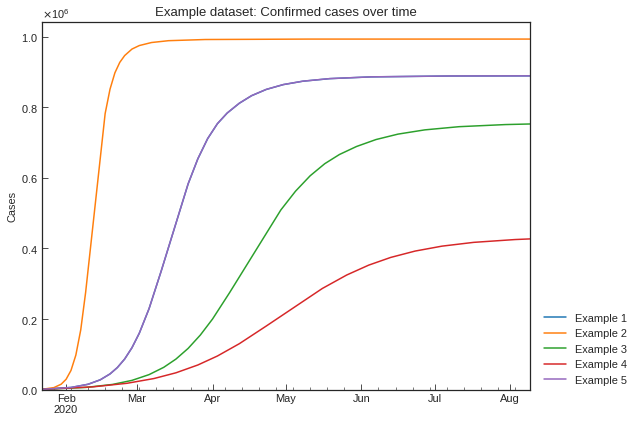

In [106]:
cs.line_plot(
    eg_ncov_df.pivot_table(index="Date", columns="Country", values="Confirmed"),
    "Example dataset: Confirmed cases over time"
)

Values of Example 1 $(\kappa=0.002)$ are nealy equal to that of Example 5 $(\kappa=0.000)$ as shown in the next figure.

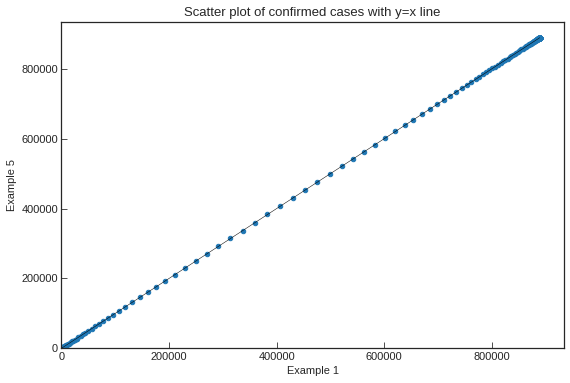

In [107]:
df = eg_ncov_df.pivot_table(index="Date", columns="Country", values="Confirmed")
df.plot.scatter(x="Example 1", y="Example 5")
plt.plot(df["Example 1"], df["Example 1"], color="black", linewidth=0.5)
plt.xlim(0, None)
plt.ylim(0, None)
plt.title("Scatter plot of confirmed cases with y=x line")
plt.show()

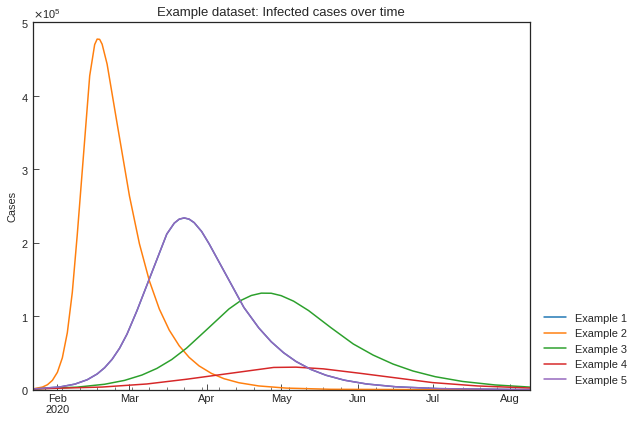

In [108]:
cs.line_plot(
    eg_ncov_df.pivot_table(index="Date", columns="Country", values="Infected"),
    "Example dataset: Infected cases over time"
)

Note: This seems Gamma distribution curve.
\begin{align*}
f(x>0) & = \cfrac{\lambda^{k}}{\Gamma(k)} x^{k-1} e^{-\lambda x}  \\
\Gamma(k) & = \int_{0}^{\infty} t^{k-1} e^{-t} dt
\end{align*}

Curve fitting with Gamma distribution curve is done by Bill Holst. Please find the URLs in ["Acknowledgement" subsection](#3).

## $\Delta$Confirmed vs. Confirmed in log-log plot
The numer of new confirmed cases $\Delta C$ can be desribed as,
\begin{align*}
\Delta C=N^{-1}\beta (N - C) I
\end{align*}
This is because $C=I+R+F$ and $S=N-C$ in SIR-F model.

$t$ is a measurable variable, but this is just an intermediate variable. $\Delta C$ is determined by cummurative number of cases.

In addition, $I$ is determined by $C$ when the parameters $(\alpha_1, \alpha_2, \beta, \gamma)$ are fixed.  
Then,
$$\Delta C = f(C)$$

Plots of $(x, y) = (C, \Delta C)$ in log-log scale are shown in the next figure.  

Note:  
This idea is from [YouTube: How To Tell If We're Beating COVID-19](https://www.youtube.com/watch?v=54XLXg4fYsc). SIR-type models are not mentioned in this video, but we can link the idea with SIR-F model as above.

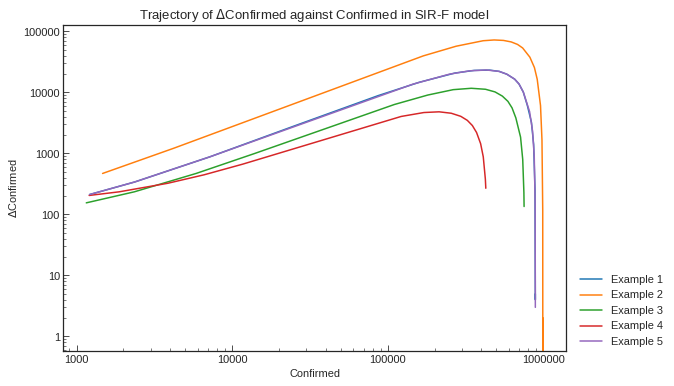

In [109]:
for country in eg_ncov_df["Country"].unique():
    df = eg_ncov_df.copy()
    df = df.loc[df["Country"] == country, :]
    df = df.groupby("Date").last()
    plt.plot(df["Confirmed"], df["Confirmed"].diff(), label=country)

plt.title(r"Trajectory of $\Delta$Confirmed against Confirmed in SIR-F model")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Confirmed")
plt.ylabel(r"$\Delta$Confirmed")
fmt = matplotlib.ticker.ScalarFormatter(useOffset=False)
fmt.set_scientific(False)
plt.gca().xaxis.set_major_formatter(fmt)
plt.gca().yaxis.set_major_formatter(fmt)
plt.legend(bbox_to_anchor=(1.02, 0), loc="lower left", borderaxespad=0)
plt.show()

Nete: Because $C(t)$ is a cummurative number, $C(t+\Delta t) \geq C(t)$ for all $t$ and $\Delta t > 0$.

## argmax($\Delta C$) in $(x, y) = (t, C(t))$ plot
What can we know from $(C, \Delta C)$ plot? Here, we will discuss max value of $\Delta C$.

When $\Delta C$ shows max value of $\Delta C$ in "Example 5" dataset (equal to SIR-D model), $t$ and $C(t)$ is

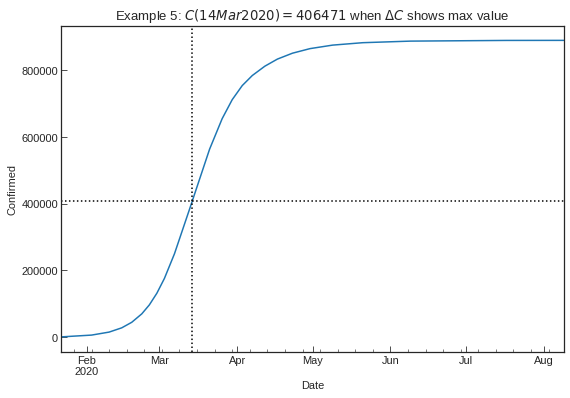

In [110]:
country = "Example 5"
df = eg_ncov_df.copy()
df = df.loc[df["Country"] == country, :].groupby("Date").last()
arg_tt = df["Confirmed"].diff().idxmax()
arg_cc = df.loc[arg_tt, "Confirmed"]
# Plot
df["Confirmed"].plot()
plt.axhline(y=arg_cc, color="black", linestyle=":")
plt.axvline(x=arg_tt, color="black", linestyle=":")
plt.ylabel("Confirmed")
plt.title(
    r'{0}: $C({1})={2}$ when $\Delta C$ shows max value'.format(
        country, arg_tt.strftime("%d%b%Y"), arg_cc)
)
fmt = matplotlib.ticker.ScalarFormatter(useOffset=False)
fmt.set_scientific(False)
plt.gca().yaxis.set_major_formatter(fmt)
plt.show()

## Curve fitting of $C(t)$
$C(t)$ is sometimes described by logistic function and Gompertz function.

\begin{align*}
\mathrm{Logistic\ function:\ } g(t) & = \cfrac{N}{1 + A e^{-Bt}}  \\
\mathrm{Gompertz\ function:\ } h(t) & = N e^{-A e^{-Bt}}
\end{align*}

cf.)  
These functions are used for prediction of the number of case in [Jia, Lin, et al., 2020](https://arxiv.org/ftp/arxiv/papers/2003/2003.05447.pdf).  

$f(t)$ can be divided to to stages;
* exponential growth function $(t \leq \mathrm{argmax}\ \Delta C(t))$ and
* negative exponential function $(otherwise)$.

With constant $(a, b, A, B, C)$,
$$
f(t) = \left\{
\begin{array}{ll}
    a e^{bt} & (t \leq \mathrm{argmax}\ \Delta C(t)) \\
    C - Ae^{-Bt} & (otherwise)
\end{array}
\right.
$$

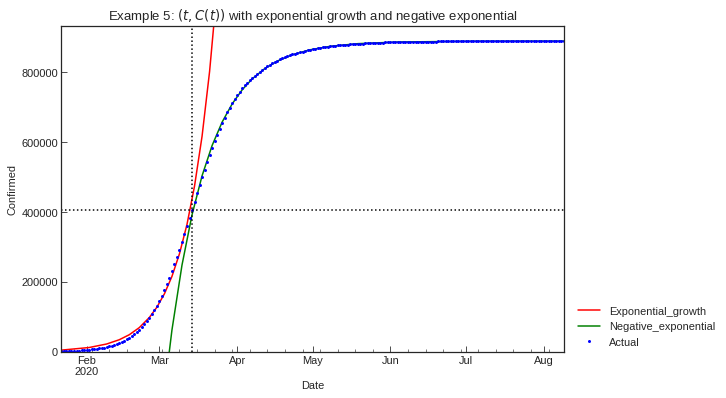

In [111]:
country = "Example 5"
df = eg_ncov_df.copy()
df = df.loc[df["Country"] == country, :].groupby("Date").last()
start_date = df.index.min()
arg_tt = df["Confirmed"].diff().idxmax()
arg_dd = int((arg_tt - start_date).total_seconds() / 60 / 60 / 24)
arg_cc = df.loc[arg_tt, "Confirmed"]
# Convert date to elapsed time (day)
df.index = ((df.index - start_date).total_seconds() / 60 / 60 / 24).astype(np.int64)
# Curve fitting with exponential growth function
f = lambda x, a, b: a * np.exp(b * x)
series = df.loc[df.index <= arg_dd, "Confirmed"]
a_ini = series[0]
b_ini = np.log(arg_cc / a_ini) / arg_dd
param, _ = sci.optimize.curve_fit(f, series.index, series, p0=[a_ini, b_ini])
f_partial = functools.partial(f, a=param[0], b=param[1])
df["Exponential_growth"] = pd.Series(df.index).apply(lambda x: f_partial(x))
# Curve fitting with negative exponential function
f = lambda x, a, b, c: c - a * np.exp(- b * (x - arg_dd))
series = df.loc[df.index >= arg_dd, "Confirmed"]
c_ini = series.max()
a_ini = c_ini - arg_cc
b_ini = series.diff()[arg_dd + 1] / a_ini
param, _ = sci.optimize.curve_fit(f, series.index, series, p0=[a_ini, b_ini, c_ini])
f_partial = functools.partial(f, a=param[0], b=param[1], c=param[2])
df["Negative_exponential"] = pd.Series(df.index).apply(lambda x: f_partial(x))
# Convert elapsed time (day) to date
df.index = start_date + pd.Series(df.index).apply(lambda x: timedelta(days=x))
# Plot
df[["Exponential_growth", "Negative_exponential"]].plot(color=["red", "green"])
df["Actual"] = df["Confirmed"]
df["Actual"].plot(color="blue", marker=".", markeredgewidth=0, linewidth=0)
plt.axhline(y=arg_cc, color="black", linestyle=":")
plt.axvline(x=arg_tt, color="black", linestyle=":")
plt.ylabel("Confirmed")
plt.ylim(0, max(df["Confirmed"]) * 1.05)
plt.title(r"{0}: $(t, C(t))$ with exponential growth and negative exponential".format(country))
fmt = matplotlib.ticker.ScalarFormatter(useOffset=False)
fmt.set_scientific(False)
plt.gca().yaxis.set_major_formatter(fmt)
plt.legend(bbox_to_anchor=(1.02, 0), loc="lower left", borderaxespad=0)
plt.show()

However, errors were found for curve fitting when $t \leq \mathrm{argmax}\ \Delta C(t)$.  
This is because
$$
\cfrac{\mathrm{d}C}{\mathrm{d}T} = \cfrac{\beta}{N} S I
$$
$S \simeq N: const.$ for $t \leq \mathrm{argmax}\ \Delta C(t)$, but $I$ is not proportinal to $C$ in SIR-like model.  

This means we cannot convert the differencial equation to the following equations.
\begin{align*}
\frac{\mathrm{d}x}{\mathrm{d}t} & = B x \\
\mathrm{i.e.\ } x(t) & = A e^{Bt}
\end{align*}

## S-R plane
Here, we will discuss the replationship of Susceptible and Recovered.

In SIR-F model,
\begin{align*}
\frac{\mathrm{d}S}{\mathrm{d}T} &= - \cfrac{\beta}{N} S I  \\
\frac{\mathrm{d}R}{\mathrm{d}T} &= \gamma I  \\
I &> 0 \\
S & \simeq N \ \mathrm{when}\ R = 0\\
\end{align*}

Then,
\begin{align*}
\cfrac{\mathrm{d}S}{\mathrm{d}R} &= - \cfrac{\beta}{N \gamma} S  \\
\end{align*}

This leads to

In [112]:
S = sym.symbols("S", cls=sym.Function)
N, R = sym.symbols("N R", positive=True)
beta, gamma = sym.symbols(r"\beta \gamma", positive=True)
dSdR = - beta / (N * gamma) * S(R)
sr = sym.dsolve(S(R).diff(R) - dSdR, hint="separable", ics={S(0): N})
sr

Eq(S(R), N*exp(-R*\beta/(N*\gamma)))

Note:  
This idea is from [Balkew, Teshome Mogessie, "The SIR Model When S(t) is a Multi-Exponential Function." (2010).Electronic Theses and Dissertations.Paper 1747.](https://dc.etsu.edu/cgi/viewcontent.cgi?article=3102&context=etd) This is for simplest SIR model, but we can apply it to SIR-F model.

In [113]:
sym.Eq(sym.simplify(sym.log(sr.lhs)), sym.simplify(sym.log(sr.rhs)))

Eq(log(S(R)), log(N) - R*\beta/(N*\gamma))

With constant $a=\frac{\beta}{N\gamma}$ and constant $b=\log N$,
$$
\log S_{(R)} = - a R + b
$$

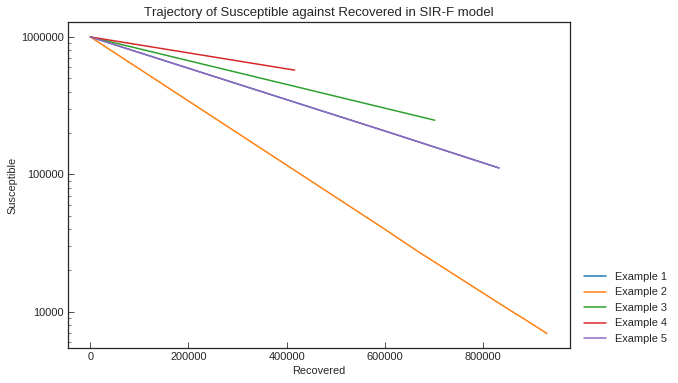

In [114]:
for country in eg_ncov_df["Country"].unique():
    df = eg_ncov_df.copy()
    df = df.loc[df["Country"] == country, :]
    df = df.groupby("Date").last()
    plt.plot(df["Recovered"], eg_population - df["Confirmed"], label=country)

plt.title(r"Trajectory of Susceptible against Recovered in SIR-F model")
plt.yscale("log")
plt.xlabel("Recovered")
plt.ylabel("Susceptible")
fmt = matplotlib.ticker.ScalarFormatter(useOffset=False)
fmt.set_scientific(False)
plt.gca().xaxis.set_major_formatter(fmt)
plt.gca().yaxis.set_major_formatter(fmt)
plt.legend(bbox_to_anchor=(1.02, 0), loc="lower left", borderaxespad=0)
plt.show()

Nete: Because $R(t)$ is a cummurative number, $R(t+\Delta t) \geq R(t)$ for all $t$ and $\Delta t > 0$.

**Thus, slope of $\log S_{(R)}$ will be changed when SIR-F parameters are changed. We need to split the actual data, considering the change points of S-R line in log-scale. This logic will be used for actual data in scenario analysis section.**

## S-R trend of actual data in one country
We will perform S-R trend analysis for actual data in Italy as an example.

Let's see the plot of S-R trend.

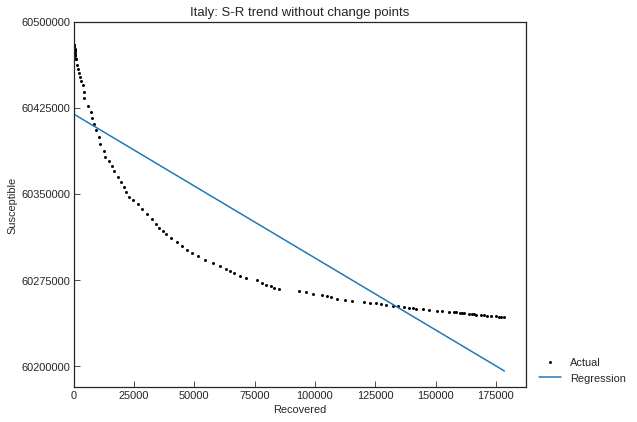

In [115]:
ita_scenario = cs.Scenario(jhu_data, pop_data, "Italy")
ita_scenario.trend()

Plots of Actual data do not show a line. This means SIR-F parameters were changed at some time-points. In the next section, we will find the time-points, assuming that there are four change points in Italy dataset.

# Scenario in Italy<a id="7"></a>
In this section, we will perform scenario analysis using the records of Italy.

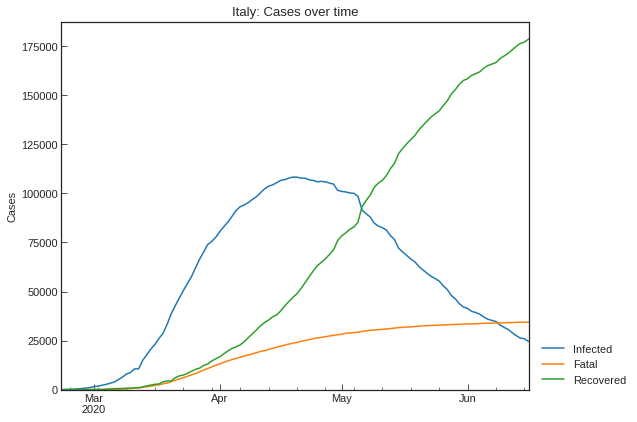

Date  Confirmed  Infected  Fatal  Recovered
133 2020-06-12     236305     28997  34223     173085
134 2020-06-13     236651     27485  34301     174865
135 2020-06-14     236989     26274  34345     176370
136 2020-06-15     237290     25909  34371     177010
137 2020-06-16     237500     24569  34405     178526

In [116]:
ita_scenario = cs.Scenario(jhu_data, pop_data, "Italy")
ita_scenario.records().tail()

## S-R Trend analysis

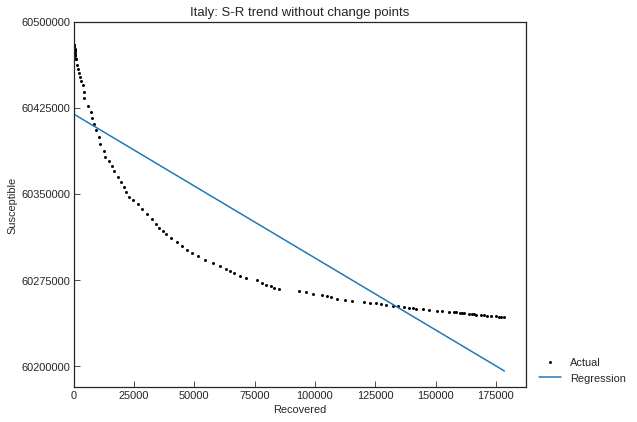

In [117]:
ita_scenario.trend()

**We will find the time-points, assuming that there are four change points.**

Finding change points of S-R trend...
Finished 140 trials in 1 min 3 sec.


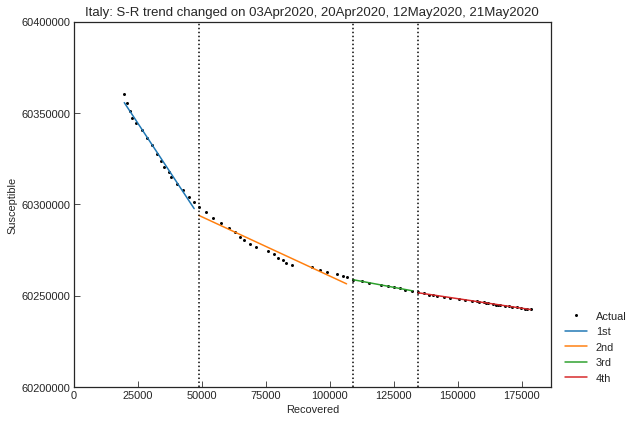

In [118]:
ita_scenario.trend(n_points=4)

## Phases in Italy
We will use the change points as the start date of phases. For each phase, will apply SIR-F model. $\tau$ values will be the same value.

In [119]:
ita_scenario.summary()

Type      Start        End  Population
1st  Past  03Apr2020  19Apr2020    60480000
2nd  Past  20Apr2020  11May2020    60480000
3rd  Past  12May2020  20May2020    60480000
4th  Past  21May2020  16Jun2020    60480000

## Estimate SIR-F parameters

In [120]:
ita_scenario.estimate(cs.SIRF)

1st phase with SIR-F model:
	Running optimization...
	Finished 94 trials in 0 min 39 sec.
2nd phase with SIR-F model:
	Running optimization...
	Finished 90 trials in 0 min 21 sec.
3rd phase with SIR-F model:
	Running optimization...
	Finished 95 trials in 0 min 21 sec.
4th phase with SIR-F model:
	Running optimization...
	Finished 92 trials in 0 min 21 sec.


### 1st phase

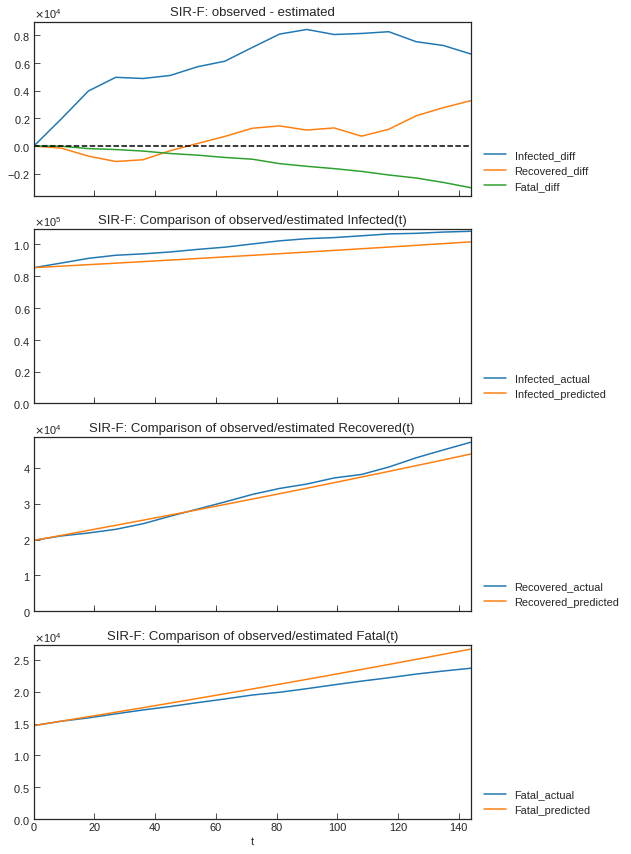

In [121]:
ita_scenario.estimate_accuracy(phase="1st")

### 2nd phase

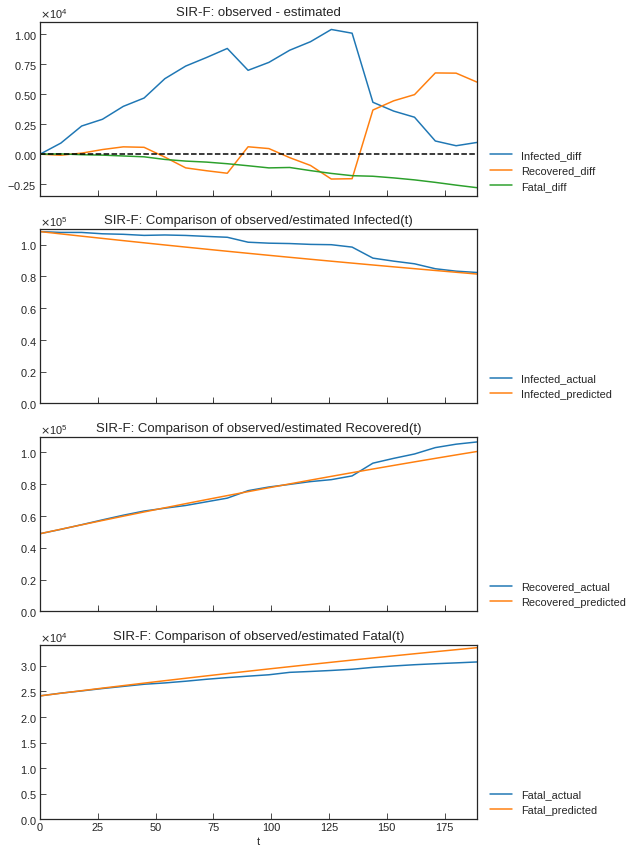

In [122]:
ita_scenario.estimate_accuracy(phase="2nd")

### 3rd phase

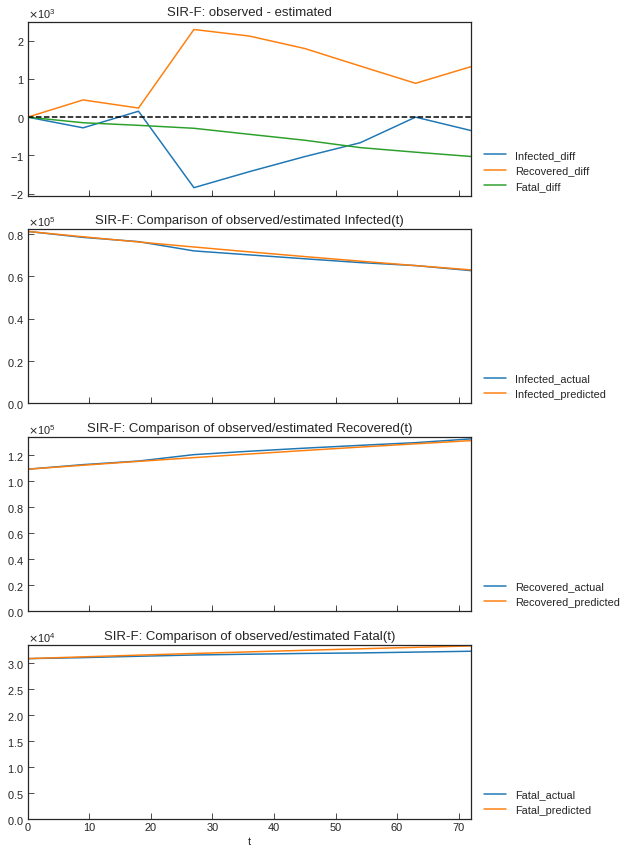

In [123]:
ita_scenario.estimate_accuracy(phase="3rd")

### 4th phase

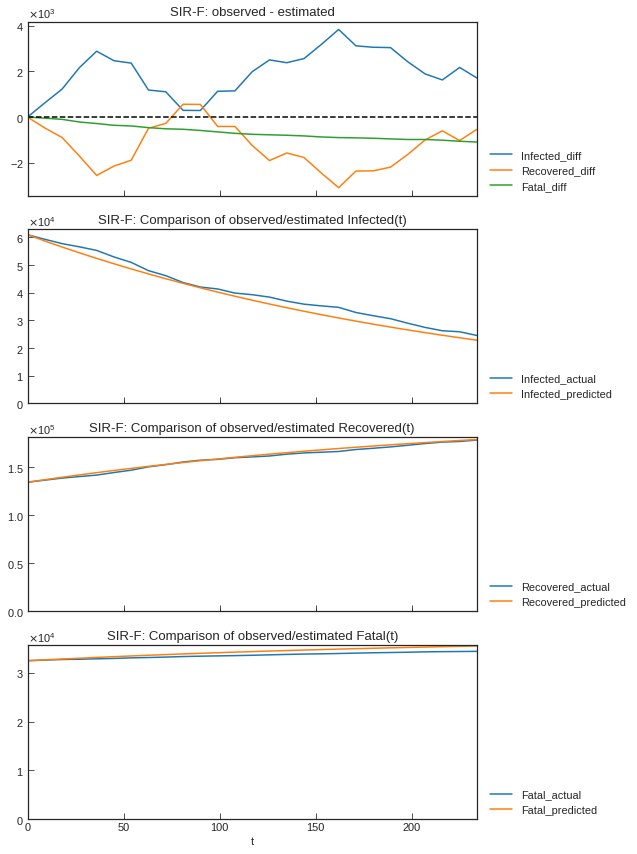

In [124]:
ita_scenario.estimate_accuracy(phase="4th")

### Compare parameters

In [125]:
ita_scenario.summary()

Type      Start        End  Population    ODE  tau       rho     sigma  \
1st  Past  03Apr2020  19Apr2020    60480000  SIR-F  160  0.003897  0.001788   
2nd  Past  20Apr2020  11May2020    60480000  SIR-F  160  0.001937  0.002903   
3rd  Past  12May2020  20May2020    60480000  SIR-F  160  0.001205  0.004241   
4th  Past  21May2020  16Jun2020    60480000  SIR-F  160  0.001040  0.004898   

        theta     kappa    Rt  alpha1 [-]  1/alpha2 [day]  1/beta [day]  \
1st  0.208397  0.000082  1.65       0.208            1356            28   
2nd  0.175068  0.000190  0.52       0.175             583            57   
3rd  0.193987  0.000240  0.22       0.194             462            92   
4th  0.201438  0.000123  0.17       0.201             904           106   

     1/gamma [day]     RMSLE  Trials       Runtime  
1st             62  0.088989      94  0 min 39 sec  
2nd             38  0.085409      90  0 min 21 sec  
3rd             26  0.016297      95  0 min 21 sec  
4th             22  0.077520      92  0 min 21 sec

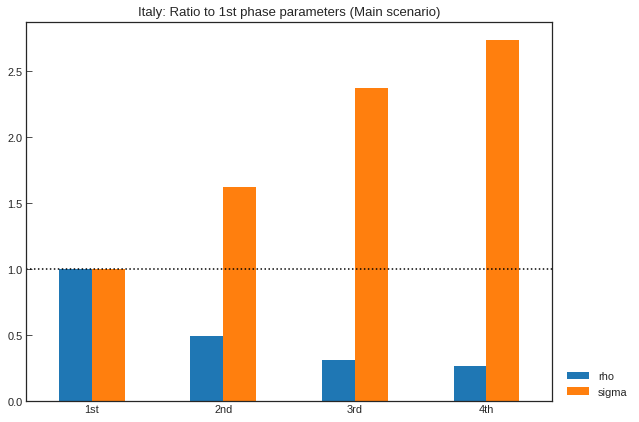

rho     sigma
1st  1.000000  1.000000
2nd  0.497107  1.623110
3rd  0.309253  2.371455
4th  0.266962  2.738479

In [126]:
ita_scenario.param_history(targets=["rho", "sigma"])

**Non-dimensional effective contact rate $\rho$ was reduced in phases.**

## Why $\rho$ was reduced?

Measures taken in Italy are shown here.

In [127]:
def _color(data_df):
    df = data_df.copy()
    df.loc[:, :] = str()
    df.iloc[[3, 6, 8], :] = "background-color: lightgreen"
    return df

ita_action_df.style.apply(_color, axis=None)

**It seems that (quaranitine of person contacted with positive patients), school closure and lockdown reduced $\rho$ value.**

## Effect of school closure and lockdown

Acording to first report of [COVID-19 Mobility Monitoring project](https://covid19mm.github.io/in-progress/2020/03/13/first-report-assessment.html) on 13Mar2020, the government of Italy declared a national lockdown on 09Mar2020 and all peole are asked to remain home. This resulted in average reduction of potential encounters of 19% during week 3 (from 07Mar2020 to 10Mar2020).

**Here, we will predict the effect of school closure (started before 04Mar2020), lockdown on 13Mar2020 with assumtion that the effect will be shown from the start date of 3rd phase.**

In [128]:
ita_scenario.get("Start", name="Main", phase="3rd")

'12May2020'

### Real factors of $\beta_1$

The parameter in the math model:  
\begin{align*}
\rho_1 & = \tau \beta_1  \\  
\beta_1 & = \cfrac{1}{49}[g_s \{g_w + g_i (1-q) \} v (1-m)^2 (1-w_e)^{w_n} e^{-(h_{1}+h_{2})} c \delta]  \\
\end{align*}

Control factors:  
$g_s$: **The number of days in <u>a week</u> susceptible persons go out [day]**  
$g_w$: The number of days in <u>a week</u> waiting but un-quarantined persons go out [day]  
$g_i$: The number of days in <u>a week</u> currently infected (confirmed) but un-quarantined persons go out [day]  
$q$: Quarantine rate of currently infected (confirmed) patients [-]  
$v$: Probability of virus existance in a droplet [-]  
$m$: Rate of persons wearing masks effectively (depends logistically on supply of masks) [-]  
$w_e$: Virus reduction effect of washing hands [-]  
$w_n$: The number of times people washes their hands before touching their own faces after go out [-]  
$h_1$: Health condition (active rate of cellular immunity factors) of susceptible and contacted persons [-]  
$h_2$: Health condition (active rate of humoral immunity factors) of susceptible and contacted persons [-]  
$c$: **The number of contacts between susceptible persons and patients while on the go in a minute (depends on population density) [1/min]**  
$\delta$:The product of unknown real factors [-]  

### Value of control factors of $\beta_1$ before/after the national lockdown
A national lockdown will effect on $g_s$ and $c$.

Acccoring the report, we assume average reduction of potential encounters ($c$[-]) of 19%.

In [129]:
c_before, c_after = 1.0, 0.81

### $g_s$ before the lockdown
We will estimate average number peple go out using @marcoferrante estimation table and population pyramid data.
It is necessary to replace the population pyramid data for Italy because the situation is different from the average data.

In [130]:
ita_out_df = go_out("Italy")
ita_out_df

Age_first  Age_last     Period_of_life  School  Office  Others   Portion
0           0         2            nursery       3       0       0  0.023674
1           3         5     nursery school       4       0       1  0.024795
2           6        10  elementary school       5       0       1  0.045552
3          11        13      middle school       5       0       1  0.028506
4          14        18        high school       6       0       1  0.047546
5          19        25    university/work       3       3       1  0.068986
6          26        35               work       0       6       1  0.110560
7          36        45               work       0       5       1  0.137011
8          46        55               work       0       5       1  0.161104
9          56        65               work       0       5       1  0.135972
10         66        75            retired       0       0       4  0.110518
11         76        85            retired       0       0       3  0.076720
12         86        95            retired       0       0       2  0.029057

In [131]:
df = ita_out_df.copy()
gs_before = (df[["School", "Office", "Others"]].sum(axis=1) * df["Portion"]).sum()
print(f"{round(gs_before, 1)} days in a week susceptible people go out.")

5.6 days in a week susceptible people go out.


### Estimation of $g_s$ after school closure/lockdown
Here, we estimate the $g_s$ after school closure/lockdown with the assumption that only $g_s$ and $c$ was changed.   

Because
$$\cfrac{\rho_{\mathrm{after}}}{gs_{\mathrm{after}}\times c_{\mathrm{after}}} = \cfrac{\rho_{\mathrm{before}}}{gs_{\mathrm{before}}\times c_{\mathrm{before}}}$$

$gs_{\mathrm{after}}$ is

In [132]:
rho_before = ita_scenario.get("rho", name="Main", phase="1st")
rho_after = ita_scenario.get("rho", name="Main", phase="3rd")
gs_after = rho_after / rho_before / c_after * gs_before * c_before
print(f"{round(gs_after, 1)} days in a week susceptible people go out after lockdown.")

2.1 days in a week susceptible people go out after lockdown.


Let's apply this value to the go_out table!  
We assume that workers go to their office one day in a week.

In [133]:
df = ita_out_df.copy()
df["School"] = 0
df.loc[df["Office"] > 0, "Office"] = 1
sum_so = (df[["School", "Office"]].sum(axis=1) * df["Portion"]).sum()
df.loc[df["Others"] > 0, "Others"] = round(gs_after - sum_so, 1)
ita_out_after_df = df.copy()
ita_out_after_df

Age_first  Age_last     Period_of_life  School  Office  Others   Portion
0           0         2            nursery       0       0     0.0  0.023674
1           3         5     nursery school       0       0     1.5  0.024795
2           6        10  elementary school       0       0     1.5  0.045552
3          11        13      middle school       0       0     1.5  0.028506
4          14        18        high school       0       0     1.5  0.047546
5          19        25    university/work       0       1     1.5  0.068986
6          26        35               work       0       1     1.5  0.110560
7          36        45               work       0       1     1.5  0.137011
8          46        55               work       0       1     1.5  0.161104
9          56        65               work       0       1     1.5  0.135972
10         66        75            retired       0       0     1.5  0.110518
11         76        85            retired       0       0     1.5  0.076720
12         86        95            retired       0       0     1.5  0.029057

Check the $g_s$ value calculated with the table.

In [134]:
df = ita_out_after_df.copy()
gs_after2 = (df[["School", "Office", "Others"]].sum(axis=1) * df["Portion"]).sum()
print(f"{round(gs_after2, 1)} days in a week susceptible people go out after lockdown.")

2.1 days in a week susceptible people go out after lockdown.


## Predict the future with the last parameters

In a week,

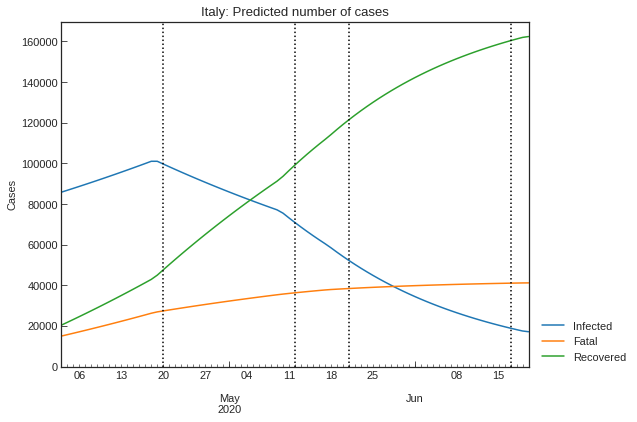

In [135]:
ita_scenario.clear()
ita_scenario.add_phase(days=7)
ita_scenario.simulate().tail(7).style.background_gradient(axis=0)

In 30 days,

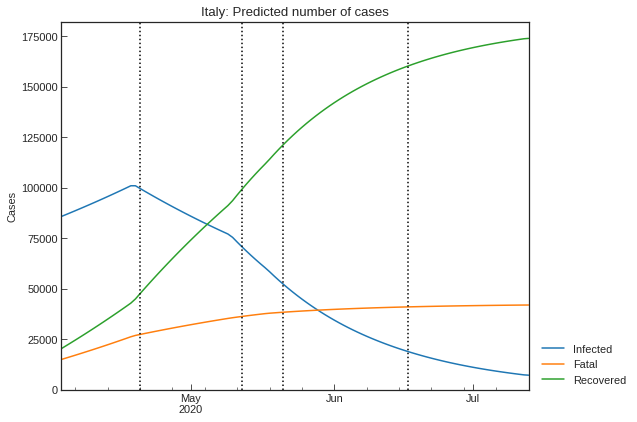

In [136]:
ita_scenario.clear()
ita_scenario.add_phase(days=30)
ita_scenario.simulate().tail(7).style.background_gradient(axis=0)

In the long-term,

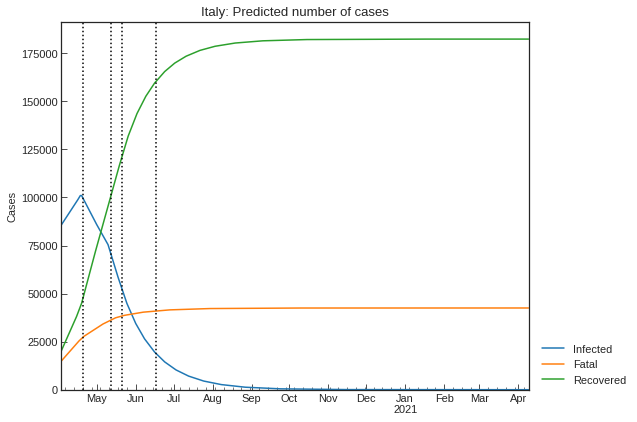

In [137]:
ita_scenario.clear()
ita_scenario.add_phase(days=300)
_ = ita_scenario.simulate()

## Effect of expected new medicines
New medicines are necessary so that patients can recover more quicky from the disease. Drug repositioning strategy (i.e.finding effective candidates from library of existing drugs of different diseases) is used to develop the medicines of COVID-19. For example, Remdesivir (USAN) and Favipiravir (AVIGAN) are candidates. 

* KEGG DRUG DATABASE: [Remdesivir (USAN)](https://www.kegg.jp/dbget-bin/www_bget?dr:D11472), Antiviral.
* KEGG DRUG DATABASE: [Favipiravir (AVIGAN)](https://www.kegg.jp/dbget-bin/www_bget?dr:D09537), efficancy is Antiviral, RNA replicase inhibitor.

Certainly, Favipiravir (AVIGAN) may lead many serious adverse reactions and it cannot be provided to expectant mothers [KEGG database AVIGAN](https://www.kegg.jp/medicus-bin/japic_med?japic_code=00066852) (Sorry, this is written in Japanese). However, it may help to save many thousand lives.  

Un-controlled clinical study of Remdesivir from 25Jan2020 to 07Mar2020:  
According to [Grein, Jonathan, et al., 2020](https://www.nejm.org/doi/full/10.1056/NEJMoa2007016?query=RP), 10-day course of Remdesivir administration (200 mg at day 1 followed by 100 mg daily) with median foloow-up of 18 days were performed.  

53 patients in the full analysis set were those with confirmed infection and had oxygen satulation of 94% or less while they were breathing ambient air or receiving oxygen support. They are from USA (22 patients), Europe/Canada (22 patients) and Japan (9 patients). 36 patients (68%) showed clinical improvement. 25 patients (47%) was discharged, 7 patients (13%) deceased.

clinical trial with placebo is necessary for evaluation, but we can assume $\gamma$ and $\alpha$ as follows. (This estimation is not refered in this paper. This just a rough evaluation.)
<!--
\begin{align*}
& \kappa \tau^{-1} = \alpha_2 = \cfrac{\bar{h}\ \bar{s}}{N} \sum_{n=0}^{\infty}\cfrac{P_{i}}{L_i} \\
& \sigma \tau^{-1} = \gamma = \cfrac{1 - \bar{h}\ \bar{s}}{N} \sum_{n=0}^{\infty}\cfrac{P_{i}}{l_i} \\
\end{align*}
$\bar{h}$: Rate of I whose immune systems does NOT overcame virus multiplication [-]  
$\bar{s}$: Rate of I$^\star$ who have severe events, including respiratory failure  [-]  
$L_i$: Inverse of F$^\star$'s mortality rate for people $i$ years old [min]  
$l_i$: Inverse of R$^\star$'s mortality rate for people $i$ years old [min]  
$P_i$: The number of people $i$ years old [-]  
$N$: Total population  
-->

$$
\gamma_{med} = \cfrac{\tau \times(\mathrm{Percentage\ of\ discharged)}}{\mathrm{Total\ number\ of\ minutes\ with\ obserbvation}}
$$

In [138]:
sigma_before = ita_scenario.get("sigma", name="Main", phase="3rd")
kappa_before = ita_scenario.get("kappa", name="Main", phase="3rd")
(sigma_before, kappa_before)

(0.004241217290078459, 0.0002401823086412009)

In [139]:
# Tentative evaluation with clinical study
sigma_med = ita_scenario.get("tau", name="Main", phase="3rd") * (25 / 53) / ((10 + 18) * 1440)
kappa_med = ita_scenario.get("tau", name="Main", phase="3rd") * (7 / 53) / ((10 + 18) * 1440)
(sigma_med, kappa_med)

(0.0018718179095537587, 0.0005241090146750523)

In three 90 days,

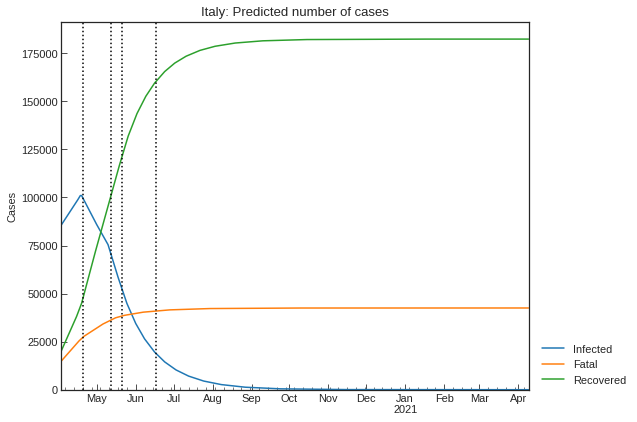

In [140]:
ita_scenario.add_phase(days=90, name="Medicine", kappa=kappa_med, sigma=sigma_med)
ita_scenario.simulate().tail(7).style.background_gradient(axis=0)

In the long-term,

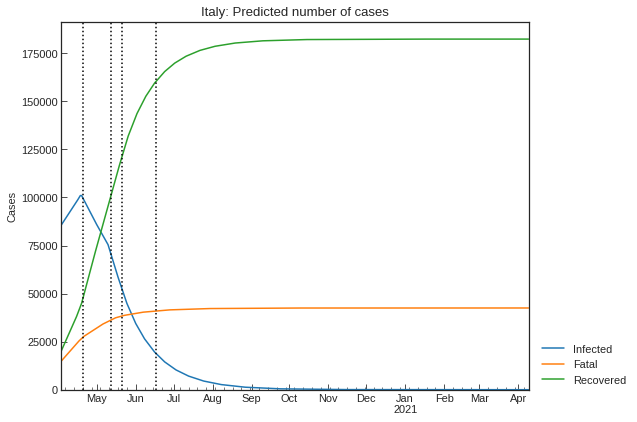

In [141]:
ita_scenario.clear(name="Medicine")
ita_scenario.add_phase(days=300, name="Medicine", kappa=kappa_med, sigma=sigma_med)
_ = ita_scenario.simulate()

# Scenario in Japan<a id="8"></a>
In this section, we will perform scenario analysis using the records of Japan.

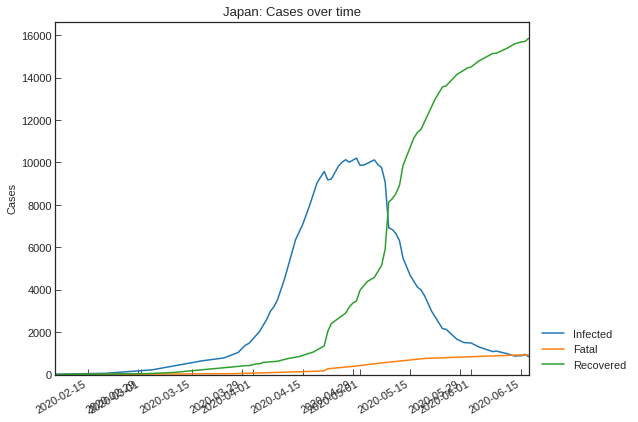

Date  Confirmed  Infected  Fatal  Recovered
123 2020-06-13      17382       878    924      15580
124 2020-06-14      17429       861    925      15643
125 2020-06-15      17502       891    925      15686
126 2020-06-16      17587       959    927      15701
127 2020-06-17      17628       847    931      15850

In [142]:
jpn_scenario = cs.Scenario(jhu_data, pop_data, "Japan")
jpn_scenario.records().tail()

## S-R Trend analysis

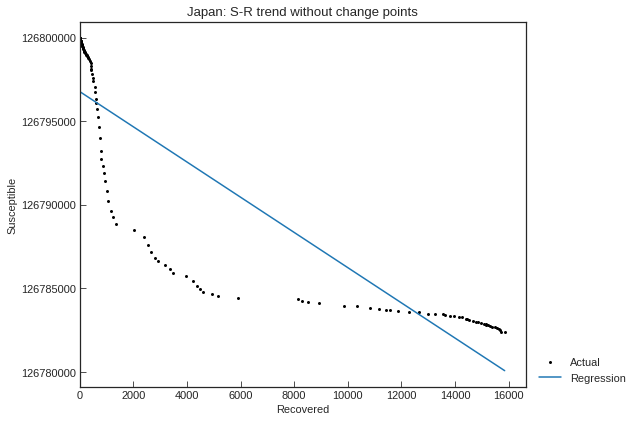

In [143]:
jpn_scenario.trend()

**We will find the time-points, assuming that there are four change points.**

Finding change points of S-R trend...
Finished 150 trials in 1 min 1 sec.


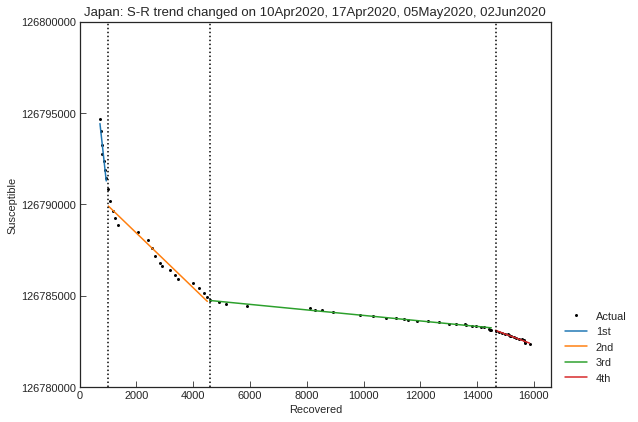

In [144]:
jpn_scenario.trend(n_points=4)

## Phase in Japan
We will use the change points as the start date of phases. For each phase, will apply SIR-F model. $\tau$ values will be the same value.

In [145]:
jpn_scenario.summary()

Type      Start        End  Population
1st  Past  10Apr2020  16Apr2020   126800000
2nd  Past  17Apr2020  04May2020   126800000
3rd  Past  05May2020  01Jun2020   126800000
4th  Past  02Jun2020  17Jun2020   126800000

## Estimate SIR-F parameters

In [146]:
jpn_scenario.estimate(cs.SIRF)

1st phase with SIR-F model:
	Running optimization...
	Finished 224 trials in 1 min 5 sec.
2nd phase with SIR-F model:
	Running optimization...
	Finished 281 trials in 1 min 5 sec.
3rd phase with SIR-F model:
	Running optimization...
	Finished 274 trials in 1 min 4 sec.
4th phase with SIR-F model:
	Running optimization...
	Finished 140 trials in 0 min 32 sec.


### 1st phase

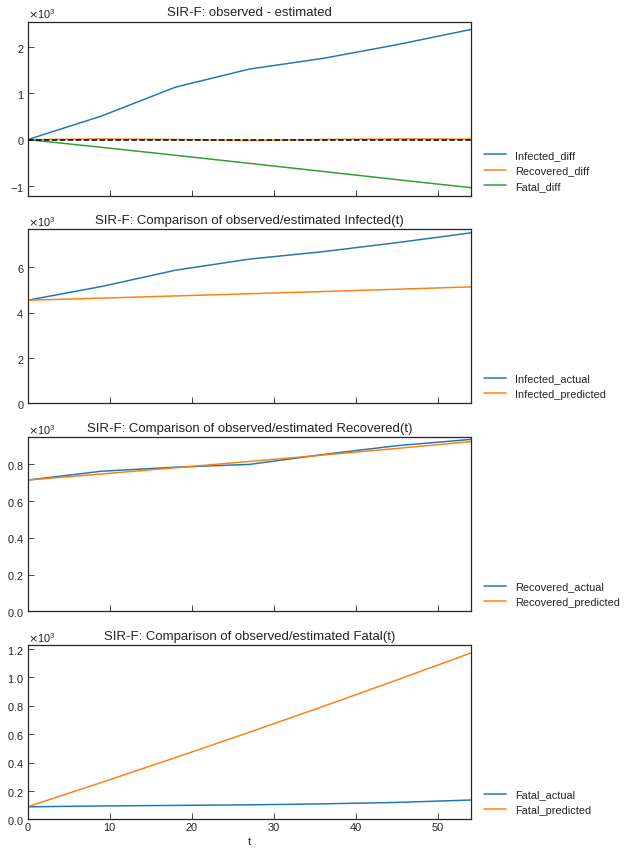

In [147]:
jpn_scenario.estimate_accuracy(phase="1st")

### 2nd phase

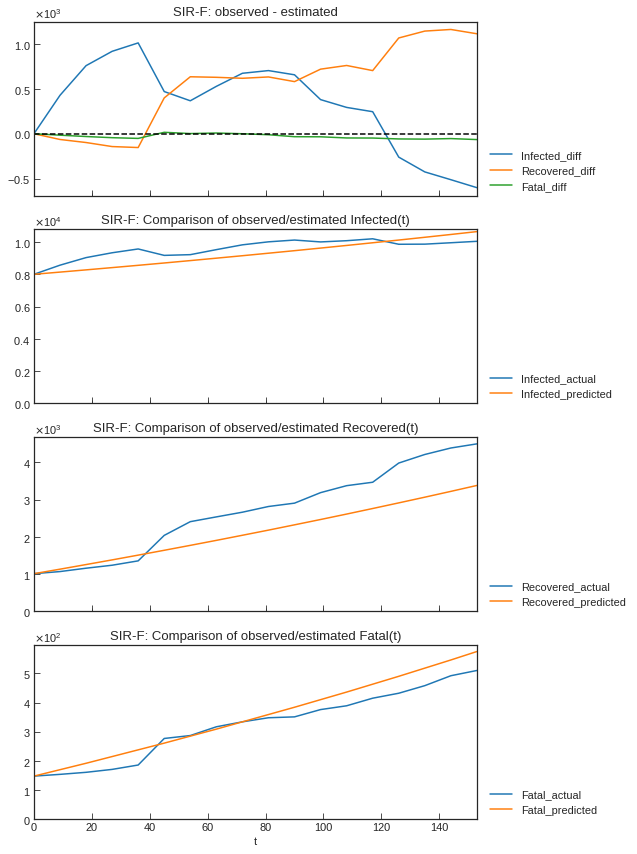

In [148]:
jpn_scenario.estimate_accuracy(phase="2nd")

### 3rd phase

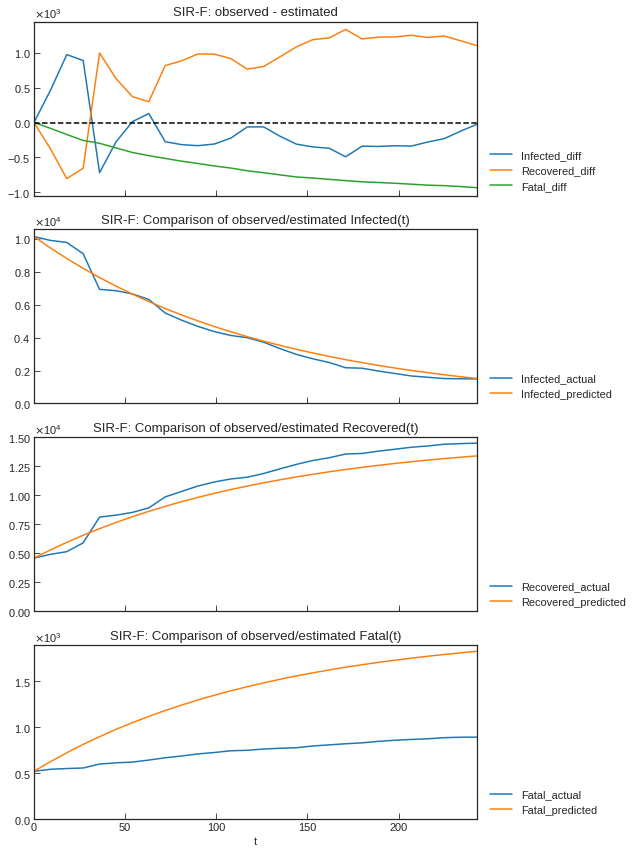

In [149]:
jpn_scenario.estimate_accuracy(phase="3rd")

### 4th phase

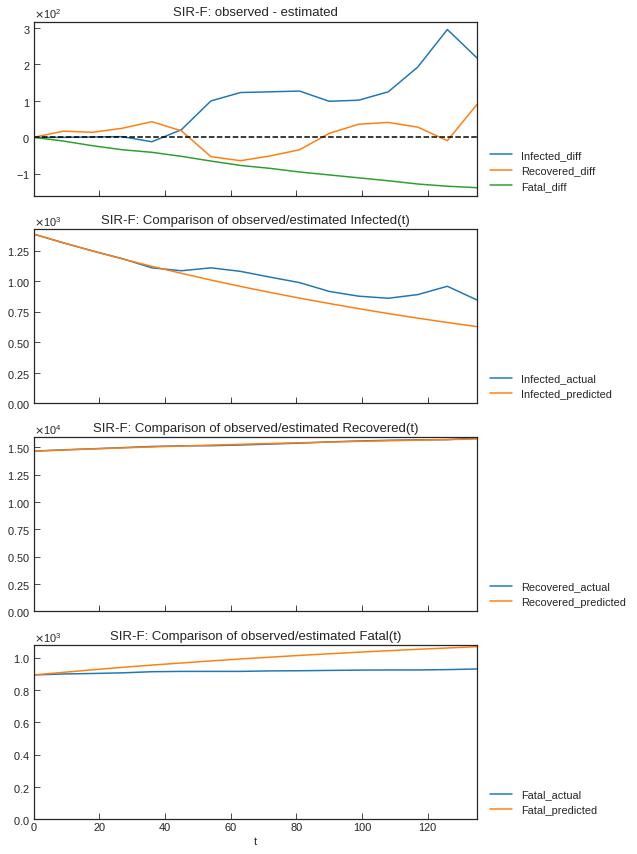

In [150]:
jpn_scenario.estimate_accuracy(phase="4th")

### Compare parameters

In [151]:
jpn_scenario.summary()

Type      Start        End  Population    ODE  tau       rho     sigma  \
1st  Past  10Apr2020  16Apr2020   126800000  SIR-F  160  0.007205  0.000800   
2nd  Past  17Apr2020  04May2020   126800000  SIR-F  160  0.003838  0.001670   
3rd  Past  05May2020  01Jun2020   126800000  SIR-F  160  0.001371  0.008008   
4th  Past  02Jun2020  17Jun2020   126800000  SIR-F  160  0.004077  0.008584   

        theta     kappa    Rt  alpha1 [-]  1/alpha2 [day]  1/beta [day]  \
1st  0.527428  0.000356  2.95       0.527             311            15   
2nd  0.032343  0.000177  2.01       0.032             628            28   
3rd  0.758909  0.000143  0.04       0.759             774            81   
4th  0.298775  0.000132  0.33       0.299             839            27   

     1/gamma [day]     RMSLE  Trials       Runtime  
1st            138  0.967814     224   1 min 5 sec  
2nd             66  0.249567     281   1 min 4 sec  
3rd             13  0.711844     274   1 min 4 sec  
4th             12  0.157233     140  0 min 32 sec

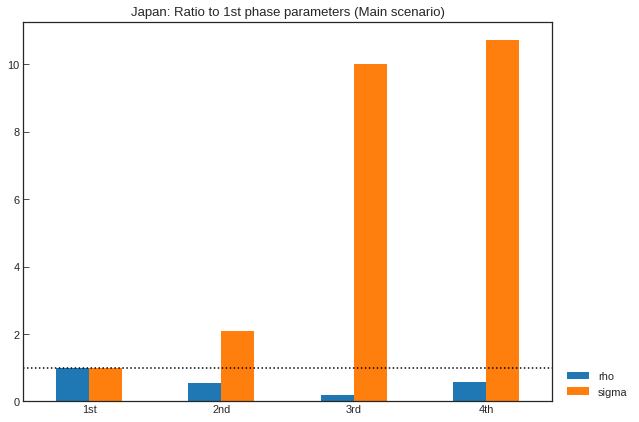

In [152]:
_ = jpn_scenario.param_history(targets=["rho", "sigma"])

Tokyo 2020 Olympics was postponed until 2021, and $\rho$ is decreasing from 2nd phase to 3rd phase.

## Why $\rho$ is decreasing?
Japan declared a state of emergency three times.
* 07Apr2020 - 15APr2020: Only three metropolitan areas (Tokyo/Kanagawa/Saitama/Chiba, Osaka/Hyogo, Fukuoka)
* 16Apr2020 - 06May2020: Nation-wide
* 07May2020 - (31May2020): Nation-wide

However, national/city lock is not be done. Japan is mainly taking the following three actions.

* Physical (social) distancing: to avoid closed spaces, crowd, conversation at close distance
* Trace the link of patients and give tests on the linked persons preferentially
* Maintain medical level to increase recovery rate and decrease mortality rate

### Prefectures where currently infected cases are
Most of the currently infected cases are in Tokyo and Osaka as shown in the next figure.

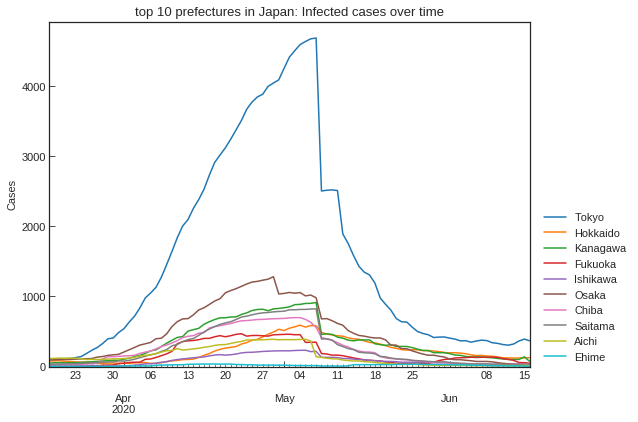

In [153]:
df = jpn_pref_df.copy()
df["Infected"] = df["Positive"] - df["Discharged"] - df["Fatal"]
df = df.pivot_table(
    index="Date", columns="Prefecture", values="Infected", aggfunc="last"
)
jpn_i_df = df.sort_values(by=df.index[-1], axis=1, ascending=False)
cs.line_plot(
    jpn_i_df.iloc[:, :10],
    "top 10 prefectures in Japan: Infected cases over time",
    y_integer=True
)

The prefecture where the highest number of currently infected cases was chronologically changed as follows.

In [154]:
df = jpn_i_df.idxmax(axis=1)
df = df[df != df.shift()].reset_index()
df.columns = ["Start_date", "Where_highest"]
df

Start_date Where_highest
0 2020-03-18         Aichi
1 2020-03-23         Tokyo

At the last record, infected cases are mainly in the prefectures with large population.

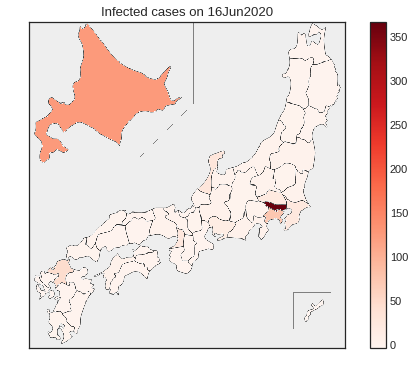

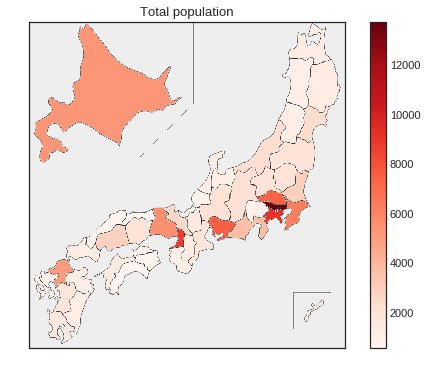

In [155]:
_date = jpn_i_df.index[-1].strftime("%d%b%Y")
df = pd.merge(
    jpn_meta_df[["Population_Total", "Area_Habitable"]],
    jpn_i_df.loc[jpn_i_df.index[-1], :],
    left_index=True, right_index=True
)
df.columns = ["Population", "Area", "Infected"]
df["Density"] = df["Population"] / df["Area"]
df["I_rate"] = df["Infected"] / df["Population"]
cs.jpn_map(df.index, df["Infected"], f"Infected cases on {_date}")
cs.jpn_map(df.index, df["Population"], f"Total population")

## Why $\sigma$ was decreased?

In [156]:
sigma2 = jpn_scenario.get("sigma", name="Main", phase="2nd")
sigma1 = jpn_scenario.get("sigma", name="Main", phase="1st")
sigma2 / sigma1

2.0883440787703114

## Predict the future with the last parameters

In a week,

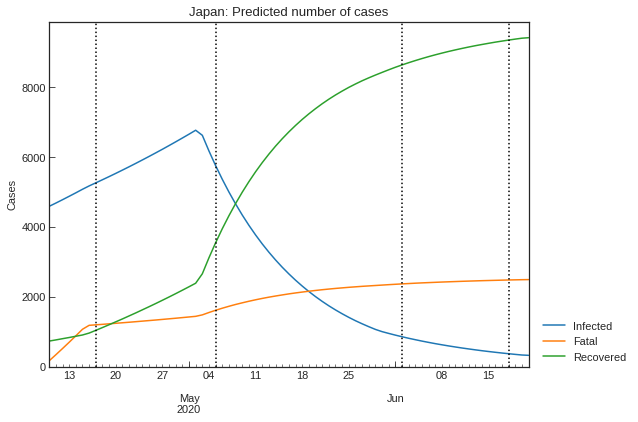

In [157]:
jpn_scenario.clear()
jpn_scenario.add_phase(days=7)
jpn_scenario.simulate().tail(7).style.background_gradient(axis=0)

In 30 days,

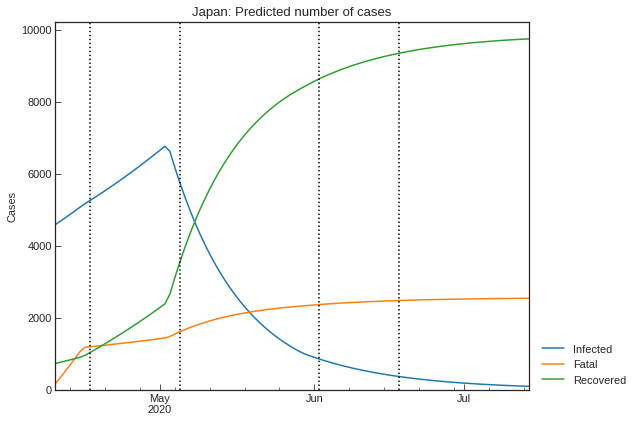

In [158]:
jpn_scenario.clear()
jpn_scenario.add_phase(days=30)
jpn_scenario.simulate().tail(7).style.background_gradient(axis=0)

In the logn-term,

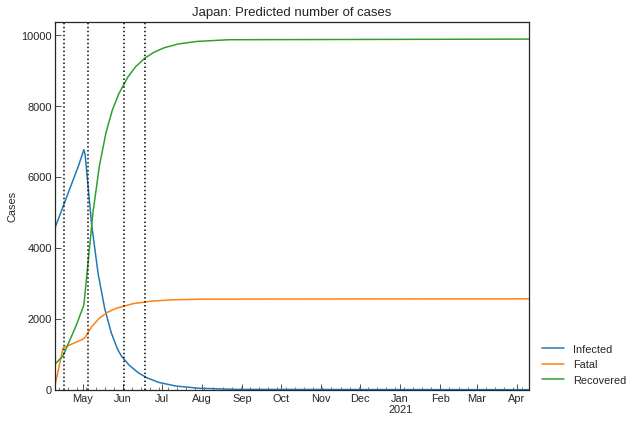

In [159]:
jpn_scenario.clear()
jpn_scenario.add_phase(days=300)
_ = jpn_scenario.simulate()

## How to make way by 31May2020 for the number of cases peaking out

### The current situation
Under the assumtion that the current trend continues, when will the number of currently infected cases peak out?  
We can use $R_t$ as the index. When $R_t < 1$, $\frac{\mathrm{d}y}{\mathrm{d}t} < 0$.

This is because  
\begin{align*}
& \frac{\mathrm{d}y}{\mathrm{d}t}= \rho (1-\theta) x y - (\sigma + \kappa) y\\
& R_t = \rho (1 - \theta) (\sigma + \kappa)^{-1}\\
& x \simeq 1 \\
\end{align*}

where $R_t$ is reproduction number (phase/time-dependent version of $R_0$).

$x$ is

In [160]:
df = jpn_scenario.records(show_figure=False)
1 - df.iloc[-1, :]["Confirmed"] / pop_data.value("Japan")

0.9998609779179811

The current value of $R_t$ is

In [161]:
jpn_scenario.get("Rt", name="Main", phase="2nd")

2.01

The number of currently infected cases will peak on

In [162]:
jpn_scenario.clear()
jpn_scenario.add_phase(days=1000)
df = jpn_scenario.simulate(show_figure=False)
df.loc[df["Infected"].idxmax(), "Date"]

'02May2020'

### How to set $R_t < 1$ by 31May2020
$R_t < 1$ when $\rho$ is under

In [163]:
current_rho = jpn_scenario.get("rho", name="Main", phase="last")
limit_rho = current_rho / jpn_scenario.get("Rt", name="Main", phase="last") * 1.0
limit_rho

0.012355377643626039

Here, we assume $\rho$ is

In [164]:
jpn_tau = jpn_scenario.get("tau", name="Main", phase="last")
beta_inv = math.ceil(jpn_tau / 24 / 60 / limit_rho) + 1
target_rho = jpn_tau / 24 / 60 / beta_inv
target_rho

0.011111111111111112

In [165]:
target_rho < limit_rho

True

Set $\rho$ with the assumtion that $\rho$ will decrease,

In [166]:
jpn_scenario.clear()
jpn_scenario.add_phase(end_date="30Jun2020", rho=target_rho)
jpn_scenario.summary()

Type      Start        End  Population    ODE  tau       rho     sigma  \
1st    Past  10Apr2020  16Apr2020   126800000  SIR-F  160  0.007205  0.000800   
2nd    Past  17Apr2020  04May2020   126800000  SIR-F  160  0.003838  0.001670   
3rd    Past  05May2020  01Jun2020   126800000  SIR-F  160  0.001371  0.008008   
4th    Past  02Jun2020  17Jun2020   126800000  SIR-F  160  0.004077  0.008584   
5th  Future  18Jun2020  30Jun2020   126800000  SIR-F  160  0.011111  0.008584   

        theta     kappa    Rt  alpha1 [-]  1/alpha2 [day]  1/beta [day]  \
1st  0.527428  0.000356  2.95       0.527             311            15   
2nd  0.032343  0.000177  2.01       0.032             628            28   
3rd  0.758909  0.000143  0.04       0.759             774            81   
4th  0.298775  0.000132  0.33       0.299             839            27   
5th  0.298775  0.000132  0.89       0.299             839            10   

     1/gamma [day]     RMSLE Trials       Runtime  
1st            138  0.967814    224   1 min 5 sec  
2nd             66  0.249567    281   1 min 4 sec  
3rd             13  0.711844    274   1 min 4 sec  
4th             12  0.157233    140  0 min 32 sec  
5th             12         -      -             -

$R_t$ will be

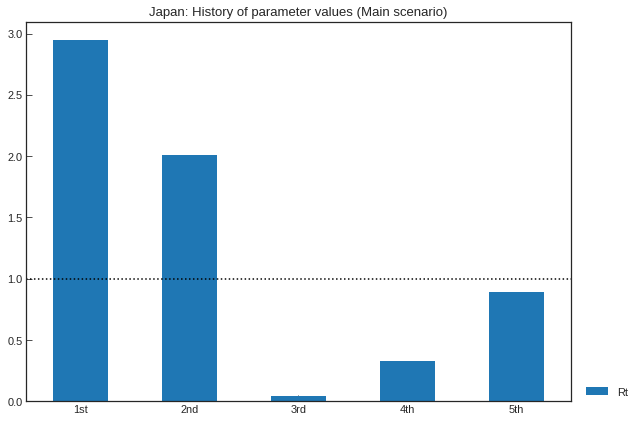

In [167]:
_ = jpn_scenario.param_history(targets=["Rt"], divide_by_first=False)

Trajectory of the number of cases and peak date will be

In [168]:
jpn_scenario.clear()
jpn_scenario.add_phase(days=100, rho=target_rho)
df = jpn_scenario.simulate(show_figure=False)
df.loc[df["Infected"].idxmax(), "Date"]

'02May2020'

### Change factor of $\beta$
Japan focuses on the rate of people in closed spaces/crowd. We need to avoid business offices, meeting spaces, entertainment distincts, shopping malls etc.

Here, we assume that $\beta=\tau^{-1}\rho$ is
\begin{align*}
& \beta_{(p)} = \overline{\beta}(1-p) + \beta^{\ast}p
\end{align*}
where  
$\overline{\beta}$: effective contact rate in average [1/min]  
$\beta^{\ast}$: effective contact rate in closed spaces/crowd [1/min]  
$p$: rate of people in closed spaces/crowd [-]

### Max value of $p$ to meet the goal

@ClusterJapan (expert team to prevent COVID-19 outbreak in Japan) analysed link of patients and summarized as follows. This is from [Twitter @ClusterJapan on 11Apr2020](https://twitter.com/ClusterJapan/status/1248884086581514242?s=20) (in Japanese).
* 80% of patients have less than 1 secondary infected patient
* 10% of patients have 8-12 secondary patients and they are in closed space/crowd

As my personal point of view, $\beta^{\ast}$ can be estimated as $\beta^{\ast} = 10 \times \overline{\beta}$.  
This means
\begin{align*}
& \beta_{(p)} = \overline{\beta}(1+9P)
\end{align*}

$P$ is the rate of people in the spaces where effcetive contact rate is 10 times as the average value.

With the assumption that $\overline{\beta}$ is constant,  
\begin{align*}
& \cfrac{\beta_{before}}{1+9P_{before}} = \cfrac{\beta_{after}}{1+9P_{after}}
\end{align*}
("Before" means "before the national emergency declaration on 06Apr2020.)

Then,
\begin{align*}
& \cfrac{1+9P_{after}}{1+9P_{before}} = \cfrac{\rho_{after}}{\rho_{before}}
\end{align*}

So,
\begin{align*}
& P_{after} = \frac{1}{9}\left[ \cfrac{\rho_{after}}{\rho_{before}}(1+9P_{before}) - 1 \right]
\end{align*}

$\cfrac{\rho_{after}}{\rho_{before}}$ is

In [169]:
target_rho / jpn_scenario.get("rho", name="Main", phase="last")

1.0

We can estimate $P_{before}$ with go-out table.
* Schools were closed
* 10.6% of people work remotely because
  - 5.6% of respondents work remotely (cf.1),
  - total number of respondents is 23,992,701 (cf.2),
  - 2,651,272 respondents are working in service industry (cf.2),
  - 2,128,322 respondents are medical personnel or care worker (cf.2),
  - 7,928,268 respondents are office workers or workers of logistics companies (cf.2).
  - The number of days the respondent work remotely is not known.
* As usual, 75% of people are in closed space/crowded (CC) area: this is just my point of view, I'm gathering information.
* Compared to baseline, 25% reduction was shown in Retail & recreation area: cf.3

cf.1: (In Japanese) [Report of 1st survey by Ministry of Health, Labor and Welfare & LINE Corporation](https://www.mhlw.go.jp/stf/newpage_10695.html)  
cf.2: (In Japanese) [Detailed report of 1st survey by Ministry of Health, Labor and Welfare & LINE Corporation](https://www.mhlw.go.jp/stf/newpage_10798.html)
Movility reports: [COVID-19 Community Mobility Reports in Japan on 05Apr2020](https://www.gstatic.com/covid19/mobility/2020-04-05_JP_Mobility_Report_en.pdf)

In [170]:
remote_rate = round(0.056 * 23992701 / (2651272 + 2128322 + 7928268), 3)
remote_rate

0.106

In [171]:
df = go_out("Japan")
df["School"] = 0
df["Remote"] = df["Office"] * remote_rate
df["Workplace"] = df["Office"] - df["Remote"]
df["Others_CC"] = df["Others"] * 0.75 * (1 - 0.25)
df["Others"] = df["Others"] - df["Others_CC"]
df = pd.concat([df["Portion"], df.loc[:, ~df.columns.isin(["Portion"])]], axis=1)
df = df.drop("Office", axis=1)
jpn_go_df = df.copy()
jpn_go_df

Portion  Age_first  Age_last     Period_of_life  School  Others  Remote  \
0   0.023292          0         2            nursery       0  0.0000   0.000   
1   0.024166          3         5     nursery school       0  0.4375   0.000   
2   0.043395          6        10  elementary school       0  0.4375   0.000   
3   0.026526         11        13      middle school       0  0.4375   0.000   
4   0.045251         14        18        high school       0  0.4375   0.000   
5   0.066696         19        25    university/work       0  0.4375   0.318   
6   0.106875         26        35               work       0  0.4375   0.636   
7   0.134815         36        45               work       0  0.4375   0.530   
8   0.142129         46        55               work       0  0.4375   0.530   
9   0.123395         56        65               work       0  0.4375   0.530   
10  0.137152         66        75            retired       0  1.7500   0.000   
11  0.089784         76        85            retired       0  1.3125   0.000   
12  0.036524         86        95            retired       0  0.8750   0.000   

    Workplace  Others_CC  
0       0.000     0.0000  
1       0.000     0.5625  
2       0.000     0.5625  
3       0.000     0.5625  
4       0.000     0.5625  
5       2.682     0.5625  
6       5.364     0.5625  
7       4.470     0.5625  
8       4.470     0.5625  
9       4.470     0.5625  
10      0.000     2.2500  
11      0.000     1.6875  
12      0.000     1.1250

$P_{before}$ can be estimated as

In [172]:
df = jpn_go_df.copy()
p_before = (df[["School", "Workplace", "Others_CC"]].sum(axis=1) * df["Portion"]).sum() / 7
p_before

0.4920099997132164

\begin{align*}
& P_{after} = \frac{1}{9}\left[ \cfrac{\rho_{after}}{\rho_{before}}(1+9P_{before}) - 1 \right]
\end{align*}

To meet the goal, $P_{after}$ should be under

In [173]:
def calc_target_p(rho_before, rho_after, p_before):
    return (rho_before / rho_after * (1 + 9 * p_before) - 1) / 9

In [174]:
rho_last = jpn_scenario.get("rho", name="Main", phase="last")
target_p = calc_target_p(target_rho, rho_last, p_before)
target_p

0.49200999971321635

### Max value of go-out index to meet the goal

## How to prevent overwhelming medical system
We need to flatten the curve of currently infected cases so that prevent overwhelming medical system. The peak value of currently infected cases must not exceed the number of hospital capacity.

### How many medical staffs, ICU beds, hospitals and other sites we have

### Severity of the currently infected patients
We categoize the patient with severity as the following.
* Grade1: Asymptomtic or mild symptoms, need self-quarantine at home or hotel
* Grade2: Severity is unknown and need hospitalization for diagnosis
* Grade3: Severe and need ICU

### Max value of $\gamma$ to meet the goal

### Are new medicines are effective?

# Scenario in India<a id="12"></a>
In this section, we will perform scenario analysis using the records of India.

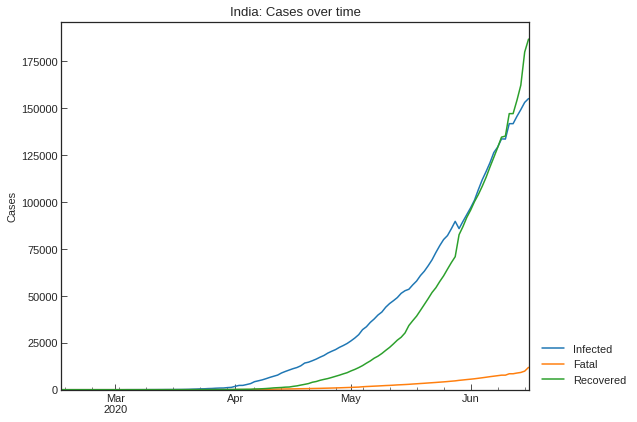

Date  Confirmed  Infected  Fatal  Recovered
134 2020-06-12     297535    141842   8498     147195
135 2020-06-13     308993    145779   8884     154330
136 2020-06-14     320922    149348   9195     162379
137 2020-06-15     343091    153178   9900     180013
138 2020-06-16     354065    155227  11903     186935

In [175]:
ind_scenario = cs.Scenario(jhu_data, pop_data, "India")
ind_scenario.records().tail()

## S-R Trend analysis

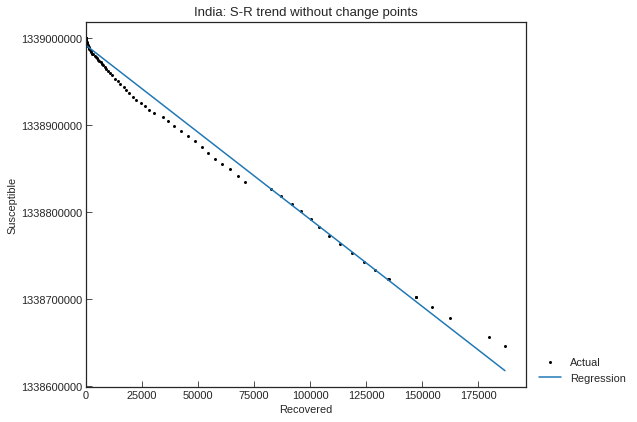

In [176]:
ind_scenario.trend()

**We will find the time-points, assuming that there are two change points.**

Finding change points of S-R trend...
Finished 120 trials in 0 min 38 sec.


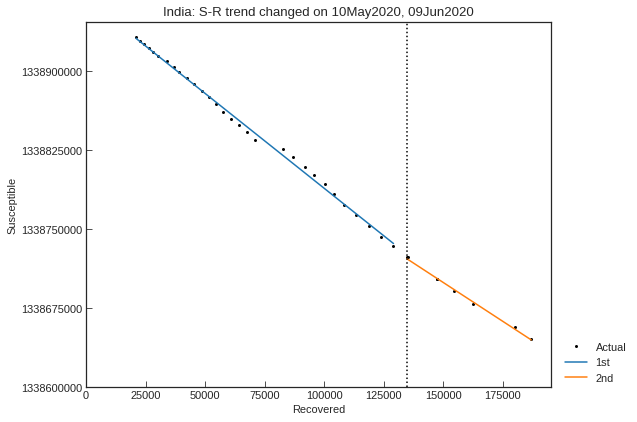

In [177]:
ind_scenario.trend(n_points=2)

## Phases in India
We will use the change points as the start date of phases. For each phase, will apply SIR-F model. $\tau$ values will be the same value.

In [178]:
ind_scenario.summary()

Type      Start        End  Population
1st  Past  10May2020  08Jun2020  1339000000
2nd  Past  09Jun2020  16Jun2020  1339000000

In [179]:
ind_scenario.estimate(cs.SIRF)

1st phase with SIR-F model:
	Running optimization...
	Finished 36 trials in 1 min 7 sec.
2nd phase with SIR-F model:
	Running optimization...
	Finished 159 trials in 1 min 7 sec.


### 1st phase

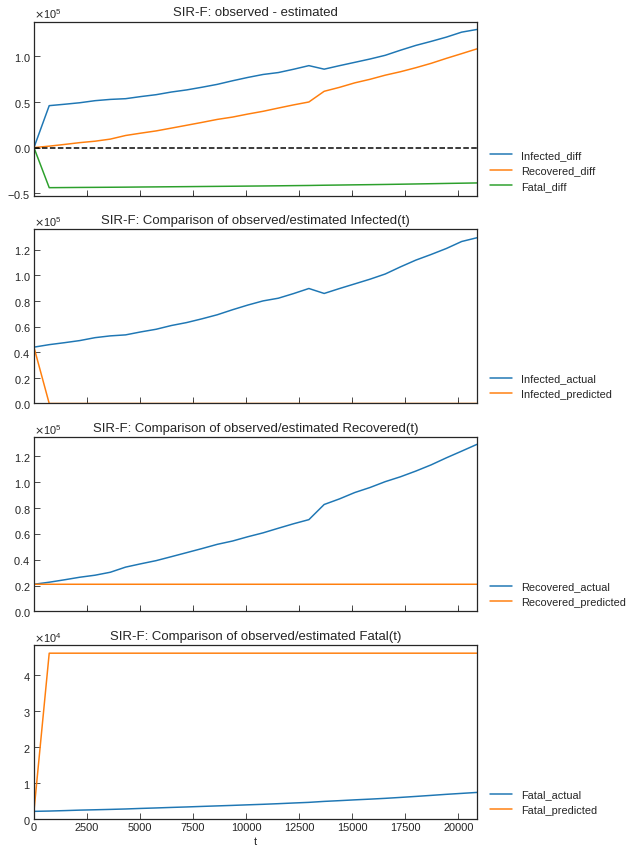

In [180]:
ind_scenario.estimate_accuracy(phase="1st")

### 2nd phase

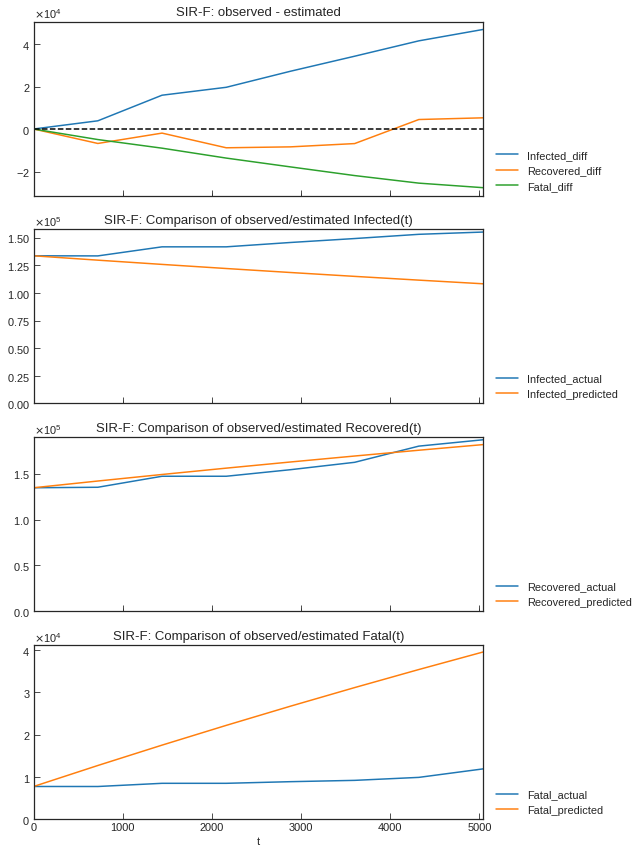

In [181]:
ind_scenario.estimate_accuracy(phase="2nd")

### Compare parameters

In [182]:
ind_scenario.summary()

Type      Start        End  Population    ODE  tau       rho     sigma  \
1st  Past  10May2020  08Jun2020  1339000000  SIR-F    2  0.000112  0.000058   
2nd  Past  09Jun2020  16Jun2020  1339000000  SIR-F    2  0.000088  0.000077   

        theta     kappa    Rt  alpha1 [-]  1/alpha2 [day]  1/beta [day]  \
1st  0.684445  0.969128  0.00       0.684               0            12   
2nd  0.366144  0.000020  0.57       0.366              69            15   

     1/gamma [day]      RMSLE  Trials      Runtime  
1st             24  13.531353      36  1 min 7 sec  
2nd             17   0.607735     159  1 min 7 sec

## Predict the future with the last parameters

In a week,

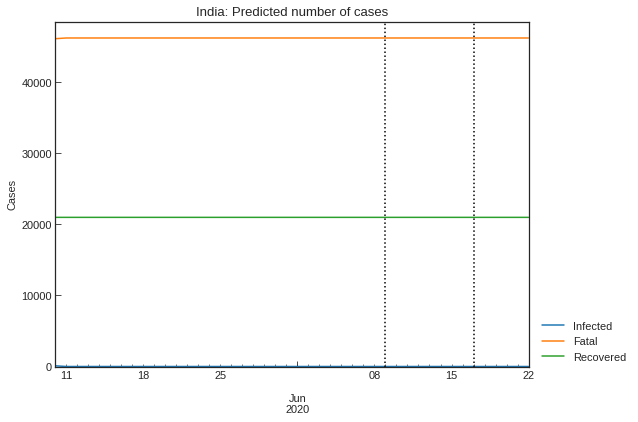

In [183]:
ind_scenario.clear()
ind_scenario.add_phase(days=7)
ind_scenario.simulate().tail(7).style.background_gradient(axis=0)

In 30 days,

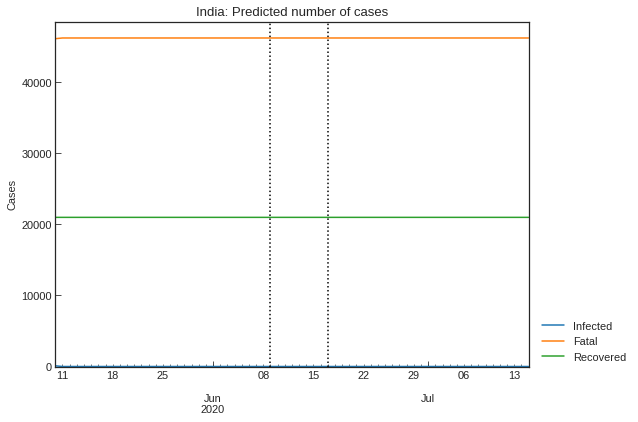

In [184]:
ind_scenario.clear()
ind_scenario.add_phase(days=30)
ind_scenario.simulate().tail(7).style.background_gradient(axis=0)

In the long-term,

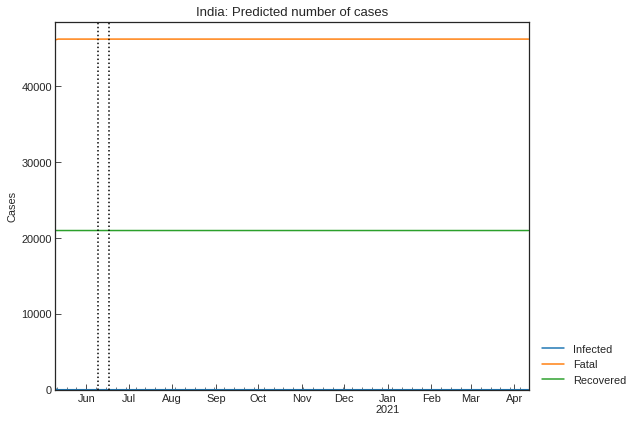

In [185]:
ind_scenario.clear()
ind_scenario.add_phase(days=300)
_ = ind_scenario.simulate()

# Scenario in USA<a id="14"></a>
In this section, we will perform scenario analysis using the records of USA (United States of America, US).

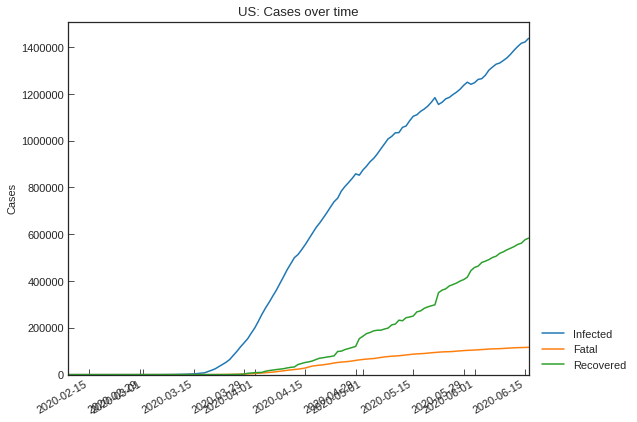

Date  Confirmed  Infected   Fatal  Recovered
142 2020-06-12    2048986   1386931  114669     547386
143 2020-06-13    2074526   1402484  115436     556606
144 2020-06-14    2094058   1416510  115732     561816
145 2020-06-15    2114026   1421565  116127     576334
146 2020-06-16    2137731   1437265  116963     583503

In [186]:
usa_scenario = cs.Scenario(jhu_data, pop_data, "US")
usa_scenario.records().tail()

## S-R Trend analysis

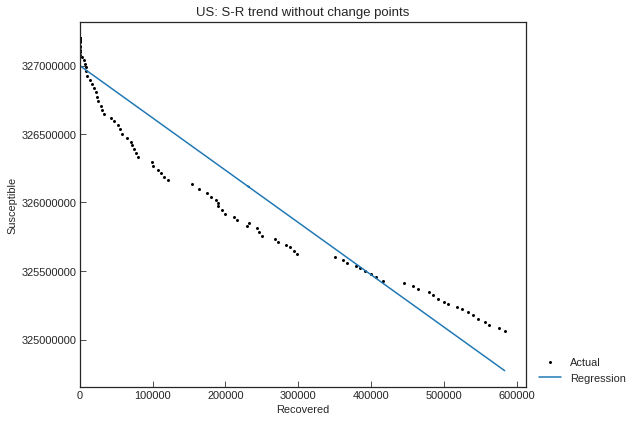

In [187]:
_ = usa_scenario.trend()

**We will find the time-points, assuming that there are three change points.**

Finding change points of S-R trend...


/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10



Performed 10 trials in 0 min 3 sec.

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10



Performed 20 trials in 0 min 7 sec.

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

divide by zero encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10



Performed 30 trials in 0 min 12 sec.

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10



Performed 40 trials in 0 min 17 sec.

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

divide by zero encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/c

Performed 50 trials in 0 min 22 sec.

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

divide by zero encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/c

Performed 60 trials in 0 min 26 sec.

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

divide by zero encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

divide by zero encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

divide by zero encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10



Performed 70 trials in 0 min 31 sec.

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

divide by zero encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10



Performed 80 trials in 0 min 35 sec.

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

divide by zero encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10



Performed 90 trials in 0 min 39 sec.

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

divide by zero encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10



Performed 110 trials in 0 min 49 sec.

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

divide by zero encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

divide by zero encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

divide by zero encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10



Performed 120 trials in 0 min 54 sec.

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

divide by zero encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

divide by zero encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

divide by zero encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10



Performed 130 trials in 0 min 59 sec.

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

divide by zero encountered in log10

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10



Finished 140 trials in 1 min 3 sec.


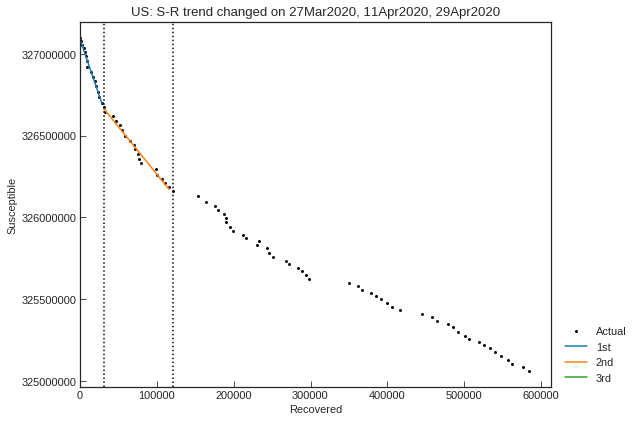

In [188]:
usa_scenario.trend(n_points=3)

## Phases in USA
We will use the change points as the start date of phases. For each phase, will apply SIR-F model. $\tau$ values will be the same value.

In [189]:
usa_scenario.summary()

Type      Start        End  Population
1st  Past  27Mar2020  10Apr2020   327200000
2nd  Past  11Apr2020  28Apr2020   327200000
3rd  Past  29Apr2020  16Jun2020   327200000

In [190]:
usa_scenario.estimate(cs.SIRF)

1st phase with SIR-F model:
	Running optimization...
	Finished 66 trials in 1 min 11 sec.
2nd phase with SIR-F model:
	Running optimization...
	Finished 20 trials in 1 min 16 sec.
3rd phase with SIR-F model:
	Running optimization...
	Finished 10 trials in 1 min 11 sec.


### 1st phase

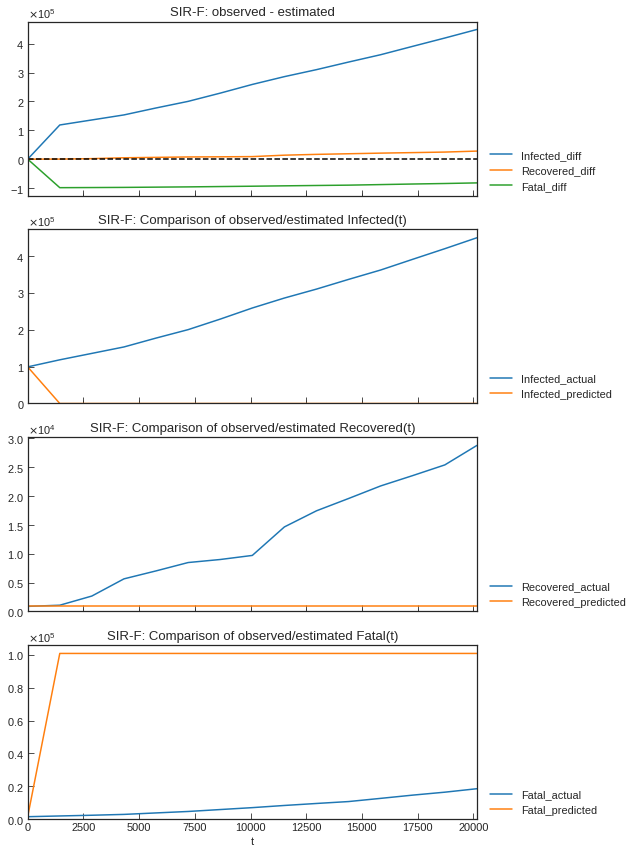

In [191]:
usa_scenario.estimate_accuracy(phase="1st")

### 2nd phase

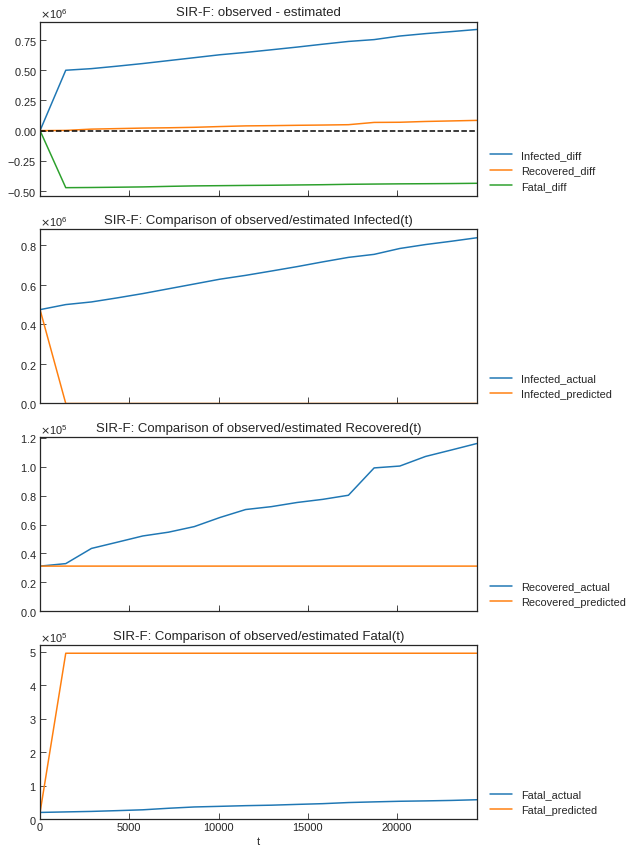

In [192]:
usa_scenario.estimate_accuracy(phase="2nd")

### 3rd phase

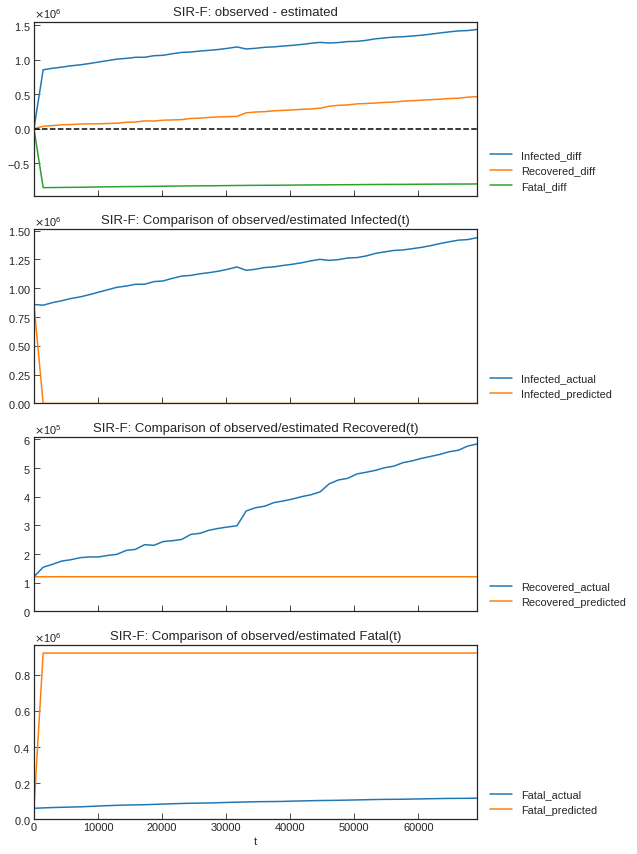

In [193]:
usa_scenario.estimate_accuracy(phase="3rd")

### Compare parameters

In [194]:
usa_scenario.summary()

Type      Start        End  Population    ODE  tau       rho     sigma  \
1st  Past  27Mar2020  10Apr2020   327200000  SIR-F    1  0.000061  0.000003   
2nd  Past  11Apr2020  28Apr2020   327200000  SIR-F    1  0.000028  0.000005   
3rd  Past  29Apr2020  16Jun2020   327200000  SIR-F    1  0.000013  0.000007   

        theta     kappa   Rt  alpha1 [-]  1/alpha2 [day]  1/beta [day]  \
1st  0.070698  0.829737  0.0       0.071               0            11   
2nd  0.629235  0.875411  0.0       0.629               0            24   
3rd  0.783687  0.259135  0.0       0.784               0            51   

     1/gamma [day]      RMSLE  Trials       Runtime  
1st            216  10.575909      66  1 min 11 sec  
2nd            141  12.238234      20  1 min 16 sec  
3rd            106  21.351136      10  1 min 11 sec

## Predict the future with the last parameters

In a week,

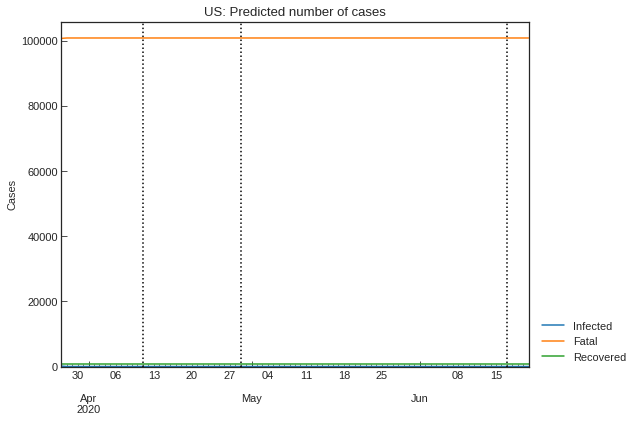

In [195]:
usa_scenario.clear()
usa_scenario.add_phase(days=7)
usa_scenario.simulate().tail(7).style.background_gradient(axis=0)

In 30 days,

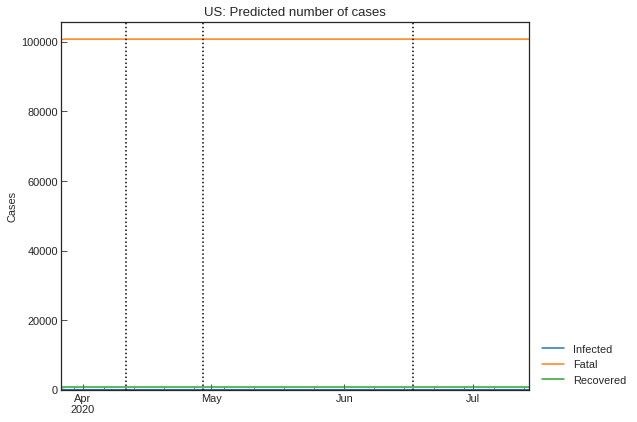

In [196]:
usa_scenario.clear()
usa_scenario.add_phase(days=30)
usa_scenario.simulate().tail(7).style.background_gradient(axis=0)

In the long-term,

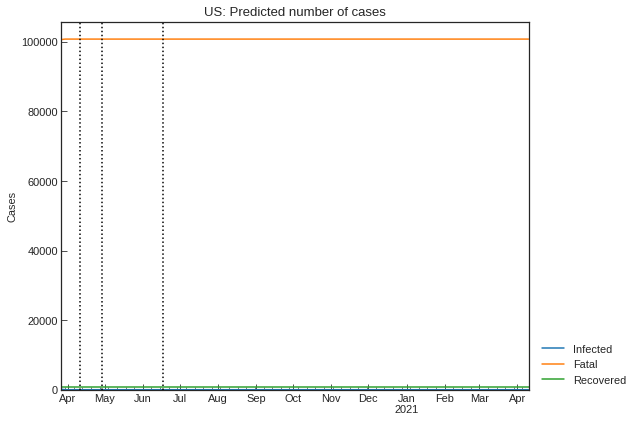

In [197]:
usa_scenario.clear()
usa_scenario.add_phase(days=300)
_ = usa_scenario.simulate()

# Scenario in New Zealand<a id="15"></a>
In this section, we will perform scenario analysis using the records of New Zealand.

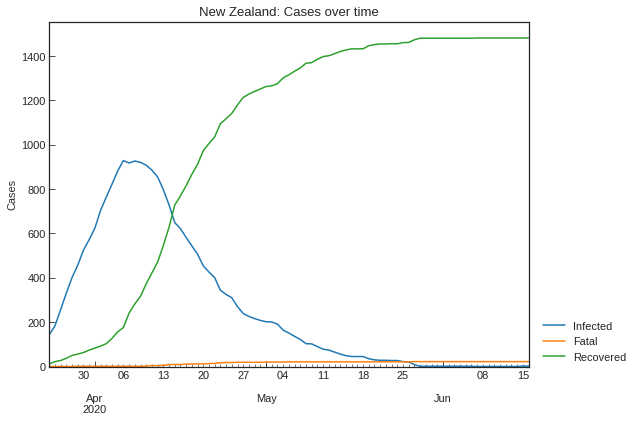

Date  Confirmed  Infected  Fatal  Recovered
105 2020-06-12       1504         0     22       1482
106 2020-06-13       1504         0     22       1482
107 2020-06-14       1504         0     22       1482
108 2020-06-15       1506         2     22       1482
109 2020-06-16       1506         2     22       1482

In [198]:
nzl_scenario = cs.Scenario(jhu_data, pop_data, "New Zealand")
nzl_scenario.records().tail()

## S-R Trend analysis

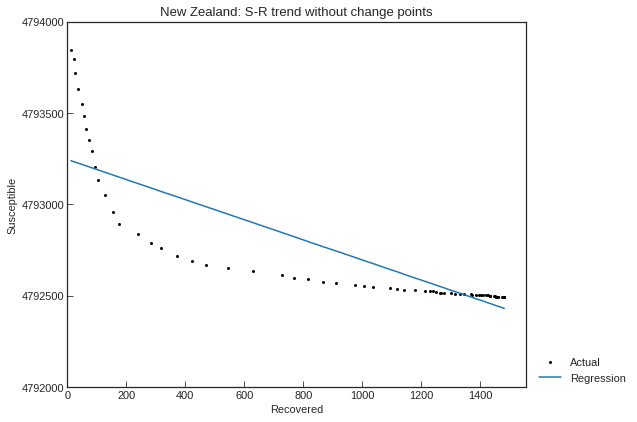

In [199]:
nzl_scenario.trend()

**We will find the time-points, assuming that there are three change points.**

Finding change points of S-R trend...
Finished 90 trials in 0 min 29 sec.


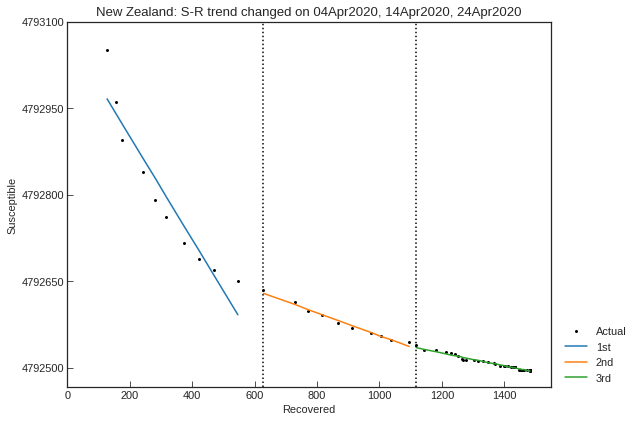

In [200]:
nzl_scenario.trend(n_points=3)

## Phases in New Zealand
We will use the change points as the start date of phases. For each phase, will apply SIR-F model. $\tau$ values will be the same value.

In [201]:
nzl_scenario.summary()

Type      Start        End  Population
1st  Past  04Apr2020  13Apr2020     4794000
2nd  Past  14Apr2020  23Apr2020     4794000
3rd  Past  24Apr2020  16Jun2020     4794000

In [202]:
nzl_scenario.estimate(cs.SIRF)

1st phase with SIR-F model:
	Running optimization...
	Finished 189 trials in 1 min 6 sec.
2nd phase with SIR-F model:
	Running optimization...
	Finished 274 trials in 1 min 4 sec.
3rd phase with SIR-F model:
	Running optimization...
	Finished 136 trials in 0 min 32 sec.


### 1st phase

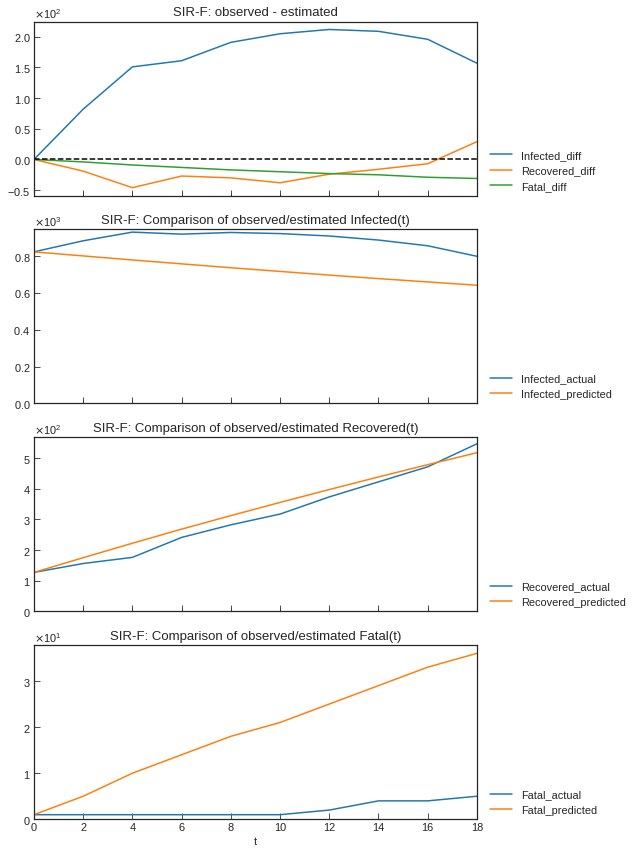

In [203]:
nzl_scenario.estimate_accuracy(phase="1st")

### 2nd phase

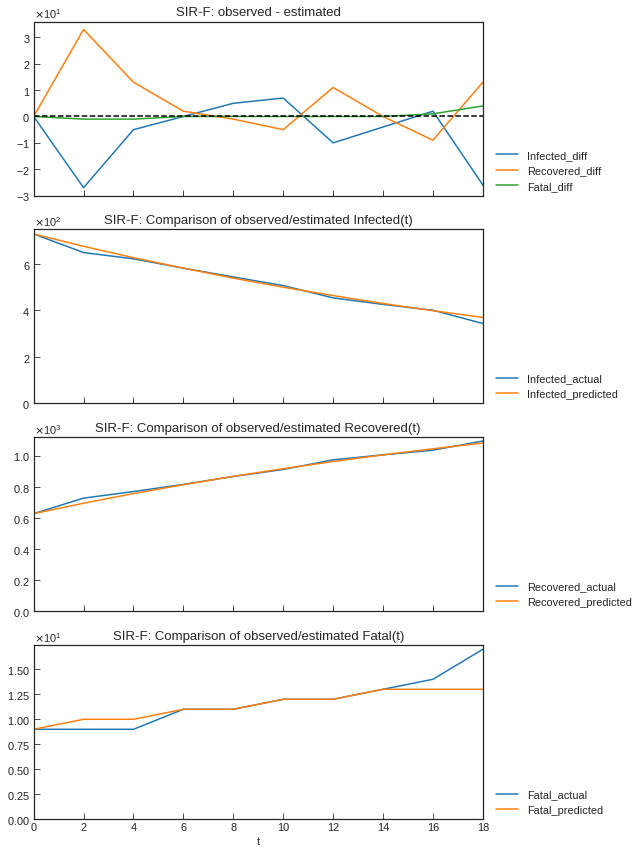

In [204]:
nzl_scenario.estimate_accuracy(phase="2nd")

### 3rd phase

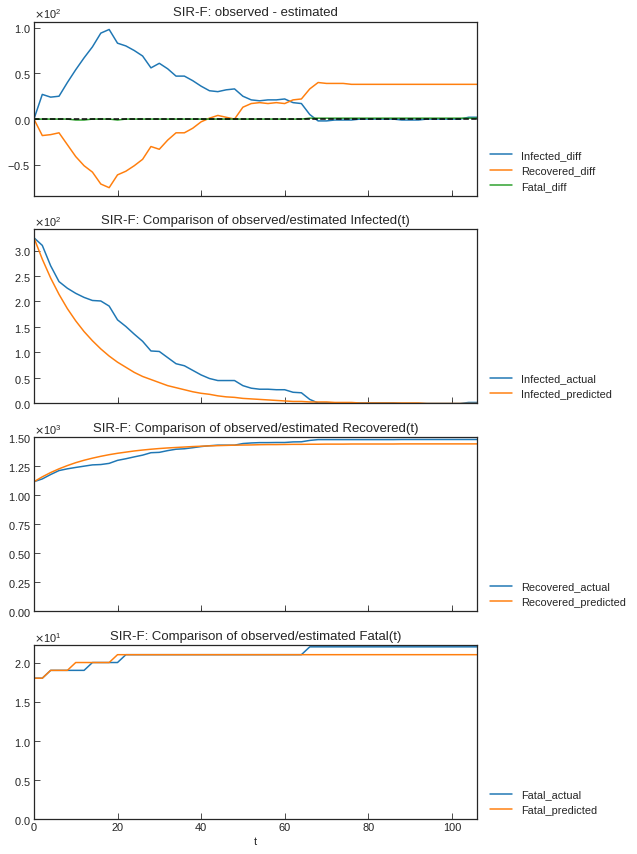

In [205]:
nzl_scenario.estimate_accuracy(phase="3rd")

### Compare parameters

In [206]:
nzl_scenario.summary()

Type      Start        End  Population    ODE  tau       rho     sigma  \
1st  Past  04Apr2020  13Apr2020     4794000  SIR-F  720  0.018597  0.029755   
2nd  Past  14Apr2020  23Apr2020     4794000  SIR-F  720  0.010402  0.047604   
3rd  Past  24Apr2020  16Jun2020     4794000  SIR-F  720  0.000999  0.069699   

        theta     kappa    Rt  alpha1 [-]  1/alpha2 [day]  1/beta [day]  \
1st  0.006262  0.002554  0.57       0.006             195            26   
2nd  0.000913  0.000442  0.22       0.001            1132            48   
3rd  0.483066  0.000245  0.01       0.483            2042           500   

     1/gamma [day]     RMSLE  Trials       Runtime  
1st             16  1.273793     189   1 min 6 sec  
2nd             10  0.067549     274   1 min 4 sec  
3rd              7  1.294045     136  0 min 32 sec

## Predict the future with the last parameters

In a week,

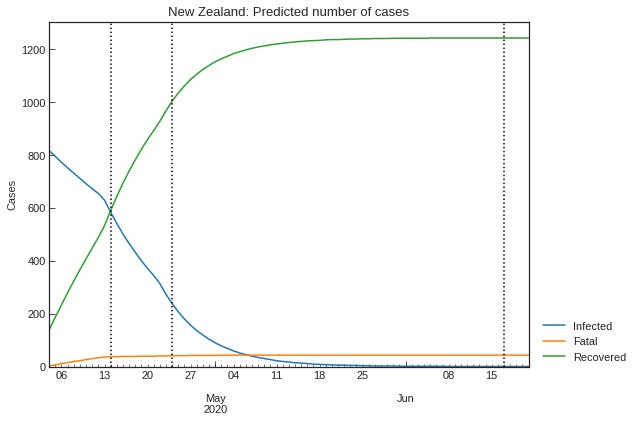

In [207]:
nzl_scenario.clear()
nzl_scenario.add_phase(days=7)
nzl_scenario.simulate().tail(7).style.background_gradient(axis=0)

In 30 days,

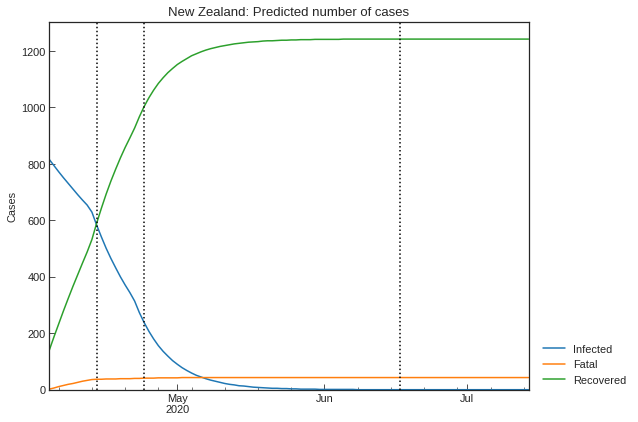

In [208]:
nzl_scenario.clear()
nzl_scenario.add_phase(days=30)
nzl_scenario.simulate().tail(7).style.background_gradient(axis=0)

In the long-term,

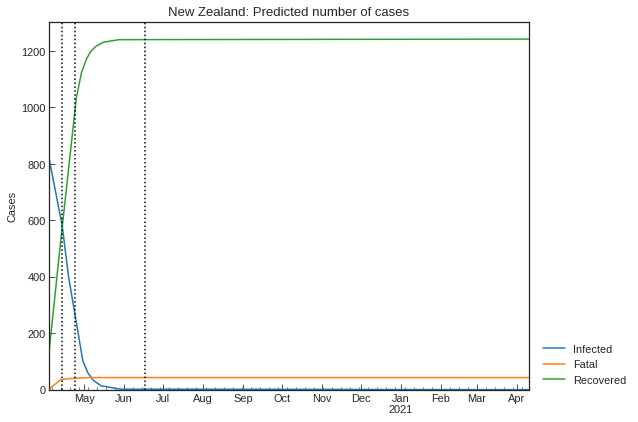

In [209]:
nzl_scenario.clear()
nzl_scenario.add_phase(days=300)
_ = nzl_scenario.simulate()

# Remarks<a id="9"></a>
Thank you for reading!  
Lisphilar from Japan

## Conclusion
(Will be updated)

## Acknowledgement<a id="3"></a>
### Datasets in kaggle
* The number of cases: [Novel Corona Virus 2019 Dataset](https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset)
* Total population: [covid19-global-forecasting-locations-population](https://www.kaggle.com/dgrechka/covid19-global-forecasting-locations-population/metadata)
* Population pyramid: [Population Pyramid 2019](https://www.kaggle.com/hotessy/population-pyramid-2019)
* Mesaures in each country: [COVID-19 containment and mitigation measures](https://www.kaggle.com/paultimothymooney/covid19-containment-and-mitigation-measures)
* Measures in Italy: [COVID-19 Prevention in Italy](https://www.kaggle.com/marcoferrante/covid19-prevention-in-italy)

#### Datasets created by the notebook auther
[COVID-19 dataset in Japan](https://www.kaggle.com/lisphilar/covid19-dataset-in-japan)
* The number of cases in Japan: PCR-tested, with/without symptoms, mild/severe, hospitalized or not etc.
* The number of cases at prefecture level: PCR-test, confirmed, discharged, fatal
* Basic information of each prefecture: Population, area, the number of beds

Data is from HP of Ministry of Health, Labour and Welefare, Japan:  
[Ministry of Health, Labour and Welefare HP (in Japanese)](https://www.mhlw.go.jp/)  
[Ministry of Health, Labour and Welefare HP (in English)](https://www.mhlw.go.jp/english/)  
[COVID-19 Japan 都道府県別 感染症病床数 (CC BY)](https://code4sabae.github.io/bedforinfection/)  
[Wikipedia](https://ja.wikipedia.org/wiki/)  

### Data provided by kagglers as a comment on this notebook
* The number of days persons of each age group usually go out provided by [Marco Ferrante](https://www.kaggle.com/marcoferrante)

### External resources
* Population pyramid: [PopulationPyramid.net](https://www.populationpyramid.net/) licensed under [Creative Commons license CC BY 3.0](https://creativecommons.org/licenses/by/3.0/)
* Movility report in Italy: [COVID-19 Mobility Monitoring project](https://covid19mm.github.io/) licenced under [Creative Commons license CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)
* Movility reports: [Google: COVID-19 Community Mobility Reports](https://www.google.com/covid19/mobility/)
* Gomperz curve: [Jia, Lin, et al. "Prediction and analysis of Coronavirus Disease 2019." arXiv preprint arXiv:2003.05447 (2020).](https://arxiv.org/ftp/arxiv/papers/2003/2003.05447.pdf)

(In Japanese)
* Mobility: [Report of 1st survey by Ministry of Health, Labor and Welfare & LINE Corporation](https://www.mhlw.go.jp/stf/newpage_10695.html)  
* Mobility: [Detailed report of 1st survey by Ministry of Health, Labor and Welfare & LINE Corporation](https://www.mhlw.go.jp/stf/newpage_10798.html)
* @ClusterJapan (expert team to prevent COVID-19 outbreak in Japan) comments: [Twitter @ClusterJapan on 11Apr2020](https://twitter.com/ClusterJapan/status/1248884086581514242?s=20)
* Gomperz curve: [(In Japanese) ゴンペルツ曲線とは何か？（3）](https://qiita.com/BMJr/items/4e2782e8f1d3c1db6801)

### References and reading materials

#### Papers
* Basic reproduction number: [Van den Driessche, P., & Watmough, J. (2002).](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6002118/)
* Curve fitting with Logistic function and Gompertz function: [Jia, Lin, et al., 2020.](https://arxiv.org/ftp/arxiv/papers/2003/2003.05447.pdf)
* S-R place: [Balkew, Teshome Mogessie, "The SIR Model When S(t) is a Multi-Exponential Function." (2010).Electronic Theses and Dissertations.Paper 1747](https://dc.etsu.edu/cgi/viewcontent.cgi?article=3102&context=etd)
* Un-controlled clinical study of Remdesivir: [Grein, Jonathan, et al., 2020](https://www.nejm.org/doi/full/10.1056/NEJMoa2007016?query=RP)

#### KEGG
* KEGG DRUG DATABASE: [Remdesivir (USAN)](https://www.kegg.jp/dbget-bin/www_bget?dr:D11472)
* KEGG DRUG DATABASE: [Favipiravir (AVIGAN)](https://www.kegg.jp/dbget-bin/www_bget?dr:D09537)
* Medical package insert of AVIGAN (In Japanese): [KEGG database "AVIGAN"](https://www.kegg.jp/medicus-bin/japic_med?japic_code=00066852)

#### Kaggle
Curve fitting with Gamma PDF etc. by [Bill Holst](https://www.kaggle.com/wjholst). 
* [COVID-19 Growth Patterns in Critical Countries](https://www.kaggle.com/wjholst/covid-19-growth-patterns-in-critical-countries#Gaussian-Approximation-of-Active-Cases)
* [COVID-19 - Growth of Virus in Specific Countries](https://www.kaggle.com/wjholst/covid-19-growth-of-virus-in-specific-countries#Gaussian-Approximation-of-Active-Cases)
* [Prediction With a Gamma PDF](https://www.kaggle.com/wjholst/prediction-with-a-gamma-pdf)

#### YouTube
* Growth Factor: [YouTube "Exponential growth and epidemics"](https://www.youtube.com/watch?v=Kas0tIxDvrg)
* Physical distancing (social distancing): [YouTube "Simulating an epidemic"](https://www.youtube.com/watch?v=gxAaO2rsdIs)
* $\Delta$Confirmed vs. Confirmed plot: [YouTube: How To Tell If We're Beating COVID-19](https://www.youtube.com/watch?v=54XLXg4fYsc)

#### Other online resources
* Simple SIR model: [The SIR epidemic model](https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/)
* SEIR model: [Introduction to SEIR model Models](http://indico.ictp.it/event/7960/session/3/contribution/19/material/slides/)
* Basic reproduction number: [Estimating the Impact of a Pathogen via Monte Carlo Simulation](https://towardsdatascience.com/infection-modeling-part-1-87e74645568a)
* RMSLE score: [What’s the Difference Between RMSE and RMSLE?](https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a)


## Change log<a id="11"></a>

### In Feb2020
 * 13Feb2020: SIR model
 * 15Feb2020: SIR-D model
 * 22Feb2020: SIR-F model
 * 23Feb2020: Changed the dataset from 2019_ncov_data.csv to covid_19_data.csv
 * 23Feb2020: $\tau$ was fixed as "1 day" because the time format of ObservationDate is MM/DD/YYYY
 * 23Feb2020: SIR-F model with other countries
 * 23Feb2020: How to minimize the damage (Change of parameter, Vacctination)
 * 24Feb2020: Use $\tau$ again

### In Mar2020
 * 01Mar2020: $\tau$ definition was changed. $1\leq \tau \mathrm{[hour]} \leq 24$ $\to$ $1\leq \tau \mathrm{[min]} \leq 1440$ 
 * 01Mar2020: Added "Test of hyperparameter optimization using example data" in SIR model section
 * 02Mar2020: Analysis of Linelist (estimation of Effective contact/Recovery/Death rate using case reports)
 * 03Mar2020: Trend analysis
 * 03Mar2020: Update estimator error function; Exponential Weighted Moving Average (span=14days) of |observed - estimated|
 * 04Mar2020: "Analysis of Linelist" was moved to [EDA of linelist](https://www.kaggle.com/lisphilar/eda-of-linelist?scriptVersionId=29640733#Remarks)
 * 04Mar2020: Data in Hubei and China will be analysed in another notebook. Please refer to [Data in China with SIR model](https://www.kaggle.com/lisphilar/data-in-china-with-sir-model?scriptVersionId=29646940).
 * 06Mar2020: Random seed was fixed as 2019
 * 06Mar2020: Update estimator error function; Weighted Average of |Exponential Weighted Moving Average (span=14days) of observed - estimated|
 * 07Mar2020: Update estimator error function; Total population $\times$ Wighted Average of |observed - estimated| with step number t
 * 07Mar2020: Priorities of variables in estimator error function was set as $(x, y, z, w) = (1, 10, 10, 1)$ in SIR-F model.
 * 09Mar2020: Update estimator error function; $(\mathrm{Population})^2$ $\times$ (Wighted Average of |observed - estimated|/[observed $\times$ Population + 1] with step number t)
 * 09Mar2020: Priorities of variables in estimator error function were set as $(x, y, z, w) = (1, 10, 10, 2)$ in SIR-F model.
 * 11Mar2020: Update model.param_dict(); each parametor range was limited to 30%-70% quantiles of the estimated values ($\frac{\mathrm{d}z}{\mathrm{d}t}\left(\frac{1}{y}\right)$ for $\sigma$) of training dataset.
 * 12Mar2020: Update model.param_dict(); each parameter range was limited to 5%-95% quantiles
 * 12Mar2020: Detailed scenario analysis. Thank you, Marco Ferrante!
 * 13Mar2020: Update model.param_dict(); each parameter range was limited to 0%-100% quantiles
 * 13Mar2020: Update "Detailed scenario analysis" > "Real factors of effective contact rate $\beta$"
 * 14Mar2020: Update model.param_dict(); rho/sigma range was limited to 30%-70% quantiles of their estimated values
 * 14Mar2020: Applied trend analysis on country level data to use only a part of records for estimation
 * 14Mar2020: Recovered without confirmation was added to "Real factors of effective contact rate $\beta$"
 * 15Mar2020: Merge "How to minimize the damage (Change of parameter, Vacctination)" with "Scenario analysis" section
 * 15Mar2020: Update Estimator, int to np.int. Thank you Enrico Papalini!
 * 15Mar2020: Update Estimator, some parameters can be fixed. Some of SIR parameters can be applied to SIR-F model.
 * 17Mar2020: The number of exposed cases and waiting cases
 * 17Mar2020: Update Scenario analysis
 * 18Mar2020: Scenario analysis in Italy
 * 19Mar2020: Estimation of new drugs effect in "Scenario analysis in Italy" section
 * 29Mar2020: Grouping of countries by growth factor
 * 29Mar2020: Update "Scenario in Italy" section to include confirmed national lockdown effect

### In Apr2020
 * 05Apr2020: Update simulation() fucntion, dense_ouput=False
 * 05Apr2020: Create Scenario() class
 * 06Apr2020: Update Scenario() class to reduce running time
 * 11Apr2020: Italy entered 4th phase
 * 11Apr2020: Add "How to make way by 31May2020 for the number of cases peaking out" in Japan
 * 13Apr2020: "excluded_places" was used for SEWIR-F and showed incorrected graph in the previous versions. Replaced with "places"
 * 17Apr2020: Prepare the dataset in Japan
 * 18Apr2020: Update RMSLE score fucntion of Estimator, $\ln(x)$ to $log_{10}(x)$
 * 18Apr2020: Add explanation of accuracy index of hyperparameter estimation
 * 18Apr2020: Japan entered 3rd phase
 * 18Apr2020: Data in "Expalanation of concept part" was changed from actual data to example data
 * 27Apr2020: "S-R trend analysis" section
 * 28Apr2020: In scenario analysis, Exponential trend analysis was replaced with S-R trend analysis
 * 28Apr2020: Add scenario analysis in India and USA
 * 29Apr2020: Add scenario analysis in New Zealand

### In May2020
 * 01May2020: Change assumed parameter values in "Factors of model parameters" section
 * 01May2020: Fix bag of SIR-FV model, calculation of Vaccinated (Immuned)
 * 03May2020: Random seed was fixed in S-R trend analysis
 * 03May2020: Error function of S-R trend anaysis was changed from squared error to weghtend squared error with day numbers
 * 03May2020: Fix bag of Scenario class, the start point of prediction
 * 03May2020: The result of un-controlled clinical study of Remdesivir was applied to scenario analysis in Italy
 * 06May2020: Error function of S-R trend anaysis was changed from weghtend squared error to squared error
 * 06May2020: Update Trend class, S-R trend in recent days will be valued, the last change point will be searched at first